### Из изменений в сравнении с NeuralNetwork_12 // короткое diff-содержание .ipynb
I. Обучаются только трёхслойные модели (layer == 'third')

II. Много тестирования моделей:
1. def predict // возможны проблемы из-за assert
2. def statistics

III. Отбор лучших моделей (best_models), на основе метрик

IV. Сохранение моделей вручную (nn.model.save), а не порцией как в tools.save_models(models, ...

V. Сохранение метрик: 
1. /model_metrics/third/_1/df_metrics_1.db (tools.save_to_db)

VI. Используется create_train_df_from_diff // видимо, как этап дообучения

VII. Визуализация метрик моделей на графиках

// аналогично NeuralNetwork_12: 
1. дообучение моделей v = 1-5
2. tools.plot_emotions
3. сравниваем метрики

// не "докликал". Сложности:
2. df_clear_metrics (df_clear_metrics_1.db) - к сожалению, только часть метрик (для 113 моделей) сохранена. Если нужны все, то нужно загружать модели из save_models + вычислять заново
3. 'stat' метрика вычисляется по какой-то иной формуле. Раньше была в диапазоне 0.32 - 0.37, теперь: 0.46 - 0.54

In [1]:
import os
import sys
import sqlite3
import pandas as pd
import numpy as np

In [2]:
project_dir_path = os.environ["NIR_1_sem_magistracy"]
data_dir = 'Data'
db_dir = 'databases'
db_dir_path = os.path.join(project_dir_path, data_dir, db_dir)
lib_dir = 'lib'
lib_dir_path = os.path.join(project_dir_path, lib_dir)
sys.path.append(lib_dir_path)
import nn_train.tools as tools
from nn_train.tools import pa_fields, seven_fields, fields
from nn_train.neural_network import NeuralNetwork

In [3]:
databases = list(os.walk(db_dir_path))[0]
databases

('/home/ivan/Рабочий стол/Учёба/Git/NIR_1_sem_magistracy/Data/databases',
 [],
 ['Aleksashina_Керов_Андрей.db', 'train.db', 'clear_emotions.db', 'other.db'])

In [4]:
df = pd.DataFrame()
for db_file in databases[2]:
    if db_file in ['train.db', 'clear_emotions.db']:
        continue
    db_path = os.path.join(db_dir_path, db_file)
    name_db = db_file[:-3]
    connection = sqlite3.connect(db_path)
    df_2 = pd.read_sql(f'select * from {name_db}', con=connection)
    df = pd.concat([df, df_2], axis=0)
df

Index_    Video_Time    Neutral        Happy  \
0         00:00:00.000_Керов Андрей_3  00:00:00.000  0.9878594  0.003336495   
1         00:00:00.030_Керов Андрей_3  00:00:00.030  0.9878824  0.003385304   
2         00:00:00.060_Керов Андрей_3  00:00:00.060  0.9879055  0.003434114   
3         00:00:00.090_Керов Андрей_3  00:00:00.090  0.9879286  0.003482923   
4         00:00:00.121_Керов Андрей_3  00:00:00.121  0.9880258  0.003506238   
...                               ...           ...        ...          ...   
20842  00:01:51.700_Куликов Алексей_1  00:01:51.700  0.9315634   3.7894e-05   
20843  00:01:51.800_Куликов Алексей_1  00:01:51.800  0.9356429   3.1707e-05   
20844  00:01:51.900_Куликов Алексей_1  00:01:51.900  0.9384109   2.6894e-05   
20845  00:01:52.000_Куликов Алексей_1  00:01:52.000  0.9407817   2.3125e-05   
20846  00:01:52.100_Куликов Алексей_1  00:01:52.100  0.9421062   2.0179e-05   

               Sad        Angry    Surprised       Scared    Disgusted  \
0      0.008397053  0.001824096  0.007600656   6.9452e-05  0.000141165   
1      0.008362157  0.001782566  0.007644675   8.0761e-05  0.000138702   
2      0.008327262  0.001741036  0.007688694    9.207e-05   0.00013624   
3      0.008292366  0.001699506  0.007732714  0.000103379  0.000133777   
4      0.008183754   0.00164466   0.00778434  0.000113112  0.000130297   
...            ...          ...          ...          ...          ...   
20842   0.02397099   0.06796286   0.02635098  0.000250268  0.000691861   
20843    0.0237766   0.06259692   0.02374056  0.000229404  0.000798602   
20844     0.023437   0.05935737   0.02117987  0.000212627  0.000848645   
20845   0.02303489   0.05651735   0.01901644  0.000197417  0.000877875   
20846   0.02311718    0.0544879   0.01772361  0.000184181  0.000897447   

            Valence  ... Action_Unit_12___Right___Lip_Corner_Puller  \
0      -0.005060558  ...                                        0.0   
1      -0.004976853  ...                                        0.0   
2      -0.004893148  ...                                        0.0   
3      -0.004809443  ...                                        0.0   
4      -0.004677515  ...                                        0.0   
...             ...  ...                                        ...   
20842   -0.06792496  ...                                        0.0   
20843   -0.06256521  ...                                        0.0   
20844   -0.05933048  ...                                        0.0   
20845   -0.05649422  ...                                        0.0   
20846   -0.05446772  ...                                        0.0   

      Action_Unit_14___Right___Dimpler  \
0                                  0.0   
1                                  0.0   
2                                  0.0   
3                                  0.0   
4                                  0.0   
...                                ...   
20842                              0.0   
20843                              0.0   
20844                              0.0   
20845                              0.0   
20846                              0.0   

      Action_Unit_15___Right___Lip_Corner_Depressor  \
0                                               0.0   
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   
...                                             ...   
20842                                           0.0   
20843                                           0.0   
20844                                           0.0   
20845                                           0.0   
20846                                           0.0   

      Action_Unit_20___Right___Lip_Stretcher  \
0                                        0.0   
1                                        0.0   
2                             

In [5]:
tools.make_valid_df(df, fields)

In [6]:
df

Index_    Video_Time  \
Index_                                                                         
00:00:00.000_Керов Андрей_3        00:00:00.000_Керов Андрей_3  00:00:00.000   
00:00:00.030_Керов Андрей_3        00:00:00.030_Керов Андрей_3  00:00:00.030   
00:00:00.060_Керов Андрей_3        00:00:00.060_Керов Андрей_3  00:00:00.060   
00:00:00.090_Керов Андрей_3        00:00:00.090_Керов Андрей_3  00:00:00.090   
00:00:00.121_Керов Андрей_3        00:00:00.121_Керов Андрей_3  00:00:00.121   
...                                                        ...           ...   
00:01:51.700_Куликов Алексей_1  00:01:51.700_Куликов Алексей_1  00:01:51.700   
00:01:51.800_Куликов Алексей_1  00:01:51.800_Куликов Алексей_1  00:01:51.800   
00:01:51.900_Куликов Алексей_1  00:01:51.900_Куликов Алексей_1  00:01:51.900   
00:01:52.000_Куликов Алексей_1  00:01:52.000_Куликов Алексей_1  00:01:52.000   
00:01:52.100_Куликов Алексей_1  00:01:52.100_Куликов Алексей_1  00:01:52.100   

                                 Neutral     Happy       Sad     Angry  \
Index_                                                                   
00:00:00.000_Керов Андрей_3     0.987859  0.003336  0.008397  0.001824   
00:00:00.030_Керов Андрей_3     0.987882  0.003385  0.008362  0.001783   
00:00:00.060_Керов Андрей_3     0.987905  0.003434  0.008327  0.001741   
00:00:00.090_Керов Андрей_3     0.987929  0.003483  0.008292  0.001700   
00:00:00.121_Керов Андрей_3     0.988026  0.003506  0.008184  0.001645   
...                                  ...       ...       ...       ...   
00:01:51.700_Куликов Алексей_1  0.931563  0.000038  0.023971  0.067963   
00:01:51.800_Куликов Алексей_1  0.935643  0.000032  0.023777  0.062597   
00:01:51.900_Куликов Алексей_1  0.938411  0.000027  0.023437  0.059357   
00:01:52.000_Куликов Алексей_1  0.940782  0.000023  0.023035  0.056517   
00:01:52.100_Куликов Алексей_1  0.942106  0.000020  0.023117  0.054488   

                                Surprised    Scared  Disgusted   Valence  ...  \
Index_                                                                    ...   
00:00:00.000_Керов Андрей_3      0.007601  0.000069   0.000141 -0.005061  ...   
00:00:00.030_Керов Андрей_3      0.007645  0.000081   0.000139 -0.004977  ...   
00:00:00.060_Керов Андрей_3      0.007689  0.000092   0.000136 -0.004893  ...   
00:00:00.090_Керов Андрей_3      0.007733  0.000103   0.000134 -0.004809  ...   
00:00:00.121_Керов Андрей_3      0.007784  0.000113   0.000130 -0.004678  ...   
...                                   ...       ...        ...       ...  ...   
00:01:51.700_Куликов Алексей_1   0.026351  0.000250   0.000692 -0.067925  ...   
00:01:51.800_Куликов Алексей_1   0.023741  0.000229   0.000799 -0.062565  ...   
00:01:51.900_Куликов Алексей_1   0.021180  0.000213   0.000849 -0.059330  ...   
00:01:52.000_Куликов Алексей_1   0.019016  0.000197   0.000878 -0.056494  ...   
00:01:52.100_Куликов Алексей_1   0.017724  0.000184   0.000897 -0.054468  ...   

                                Action_Unit_12___Right___Lip_Corner_Puller  \
Index_                                                                       
00:00:00.000_Керов Андрей_3                                            0.0   
00:00:00.030_Керов Андрей_3                                            0.0   
00:00:00.060_Керов Андрей_3                                            0.0   
00:00:00.090_Керов Андрей_3                                            0.0   
00:00:00.121_Керов Андрей_3                                            0.0   
...                                                                    ...   
00:01:51.700_Куликов Алексей_1                                         0.0   
00:01:51.800_Куликов Алексей_1                                         0.0   
00:01:51.900_Куликов Алексей_1                                         0.0   
00:01:52.000_Куликов Алексей_1                                         0.0   
00:01:52.100_Куликов Алексей_1                                

In [7]:
df_train, df_other = tools.groupby(df, other=True)
df_train

Neutral  Happy   Sad  Angry  Surprised  \
Index_                                                                     
00:01:44.700_Балакин Владислав_1     0.99   0.00  0.00   0.00       0.01   
00:00:10.121_Боим_1                  0.99   0.00  0.00   0.00       0.01   
00:01:38.700_Лебедев Андрей_1        0.99   0.00  0.00   0.00       0.01   
00:00:11.181_Боим_1                  0.99   0.00  0.00   0.00       0.01   
00:00:03.909_Боим_1                  0.99   0.00  0.01   0.01       0.01   
...                                   ...    ...   ...    ...        ...   
00:00:17.500_Смолин Александр_1      0.02   0.96  0.00   0.00       0.00   
00:00:20.900_Aleksashina_1           0.01   0.98  0.00   0.00       0.00   
00:00:16.900_Смолин Александр_1      0.02   0.97  0.00   0.00       0.00   
00:00:17.000_Смолин Александр_1      0.02   0.97  0.00   0.00       0.00   
00:00:15.000_Aleksashina_1           0.01   0.99  0.00   0.00       0.00   

                                  Scared  Disgusted  Valence  Arousal  
Index_                                                                 
00:01:44.700_Балакин Владислав_1     0.0        0.0    -0.00     0.25  
00:00:10.121_Боим_1                  0.0        0.0    -0.00     0.25  
00:01:38.700_Лебедев Андрей_1        0.0        0.0    -0.00     0.25  
00:00:11.181_Боим_1                  0.0        0.0    -0.00     0.25  
00:00:03.909_Боим_1                  0.0        0.0    -0.01     0.25  
...                                  ...        ...      ...      ...  
00:00:17.500_Смолин Александр_1      0.0        0.0     0.96     0.90  
00:00:20.900_Aleksashina_1           0.0        0.0     0.97     0.67  
00:00:16.900_Смолин Александр_1      0.0        0.0     0.97     0.87  
00:00:17.000_Смолин Александр_1      0.0        0.0     0.97     0.89  
00:00:15.000_Aleksashina_1           0.0        0.0     0.98     0.79  

[6481 rows x 9 columns]

In [8]:
df_other

Neutral  Happy  Sad  Angry  Surprised  Scared  \
Index_                                                                       
00:00:00.030_Керов Андрей_3     0.99   0.00  0.0    0.0       0.01     0.0   
00:00:00.060_Керов Андрей_3     0.99   0.00  0.0    0.0       0.01     0.0   
00:00:00.090_Керов Андрей_3     0.99   0.00  0.0    0.0       0.01     0.0   
00:00:00.121_Керов Андрей_3     0.99   0.00  0.0    0.0       0.01     0.0   
00:00:00.151_Керов Андрей_3     0.99   0.00  0.0    0.0       0.01     0.0   
...                              ...    ...  ...    ...        ...     ...   
00:00:11.696_Fomin_6            0.05   0.93  0.0    0.0       0.00     0.0   
00:00:04.060_Керов Андрей_2     0.04   0.94  0.0    0.0       0.00     0.0   
00:00:11.878_Fomin_6            0.03   0.95  0.0    0.0       0.00     0.0   
00:00:11.969_Fomin_6            0.03   0.95  0.0    0.0       0.00     0.0   
00:00:13.100_Aleksashina_1      0.02   0.97  0.0    0.0       0.00     0.0   

                             Disgusted  Valence  Arousal  
Index_                                                    
00:00:00.030_Керов Андрей_3        0.0    -0.00     0.25  
00:00:00.060_Керов Андрей_3        0.0    -0.00     0.25  
00:00:00.090_Керов Андрей_3        0.0    -0.00     0.25  
00:00:00.121_Керов Андрей_3        0.0    -0.00     0.25  
00:00:00.151_Керов Андрей_3        0.0    -0.00     0.25  
...                                ...      ...      ...  
00:00:11.696_Fomin_6               0.0     0.93     0.78  
00:00:04.060_Керов Андрей_2        0.0     0.94     0.53  
00:00:11.878_Fomin_6               0.0     0.95     0.83  
00:00:11.969_Fomin_6               0.0     0.95     0.84  
00:00:13.100_Aleksashina_1         0.0     0.97     0.80  

[18840 rows x 9 columns]

In [9]:
name_db = 'clear_emotions'
db_file = f"{name_db}.db"
db_path = os.path.join(db_dir_path, db_file)
db_path

'/home/ivan/Рабочий стол/Учёба/Git/NIR_1_sem_magistracy/Data/databases/clear_emotions.db'

In [10]:
connection = sqlite3.connect(db_path)
df_clear = pd.read_sql(f'select * from {name_db}', con=connection)
df_clear

Index_ Neutral Happy   Sad Angry Surprised  \
0    00:00:01.300_Смолин Александр_1    0.97   0.0  0.02  0.03      0.01   
1        00:00:07.575_Керов Андрей_8    0.97  0.01   0.0   0.0      0.04   
2                00:00:03.000_Боим_9    0.97  0.01   0.0   0.0      0.04   
3          00:00:05.700_Provotorov_3    0.97   0.0  0.02  0.03      0.01   
4            00:00:09.848_Korsakov_9    0.97   0.0   0.0  0.01      0.01   
..                               ...     ...   ...   ...   ...       ...   
525           00:00:07.700_Nasyrov_7    0.01   0.0   0.0  0.01       0.0   
526           00:00:08.200_Nasyrov_7    0.01   0.0   0.0  0.01       0.0   
527           00:00:07.300_Nasyrov_7    0.01   0.0   0.0   0.0       0.0   
528           00:00:08.900_Nasyrov_7     0.0   0.0   0.0  0.01       0.0   
529           00:00:09.100_Nasyrov_7     0.0   0.0   0.0  0.01       0.0   

    Scared Disgusted Valence Arousal  
0      0.0      0.01   -0.03    0.23  
1      0.0       0.0    0.01    0.31  
2      0.0       0.0    0.01    0.31  
3      0.0      0.01   -0.03    0.23  
4      0.0      0.01   -0.01     0.3  
..     ...       ...     ...     ...  
525    0.0      0.99   -0.99    0.63  
526    0.0      0.99   -0.99    0.63  
527    0.0      0.99   -0.99    0.62  
528    0.0       1.0    -1.0    0.63  
529    0.0       1.0    -1.0    0.63  

[530 rows x 10 columns]

In [11]:
tools.make_valid_df(df_clear, fields)

In [12]:
df_clear

Index_  Neutral  \
Index_                                                                      
00:00:01.300_Смолин Александр_1  00:00:01.300_Смолин Александр_1     0.97   
00:00:07.575_Керов Андрей_8          00:00:07.575_Керов Андрей_8     0.97   
00:00:03.000_Боим_9                          00:00:03.000_Боим_9     0.97   
00:00:05.700_Provotorov_3              00:00:05.700_Provotorov_3     0.97   
00:00:09.848_Korsakov_9                  00:00:09.848_Korsakov_9     0.97   
...                                                          ...      ...   
00:00:07.700_Nasyrov_7                    00:00:07.700_Nasyrov_7     0.01   
00:00:08.200_Nasyrov_7                    00:00:08.200_Nasyrov_7     0.01   
00:00:07.300_Nasyrov_7                    00:00:07.300_Nasyrov_7     0.01   
00:00:08.900_Nasyrov_7                    00:00:08.900_Nasyrov_7     0.00   
00:00:09.100_Nasyrov_7                    00:00:09.100_Nasyrov_7     0.00   

                                 Happy   Sad  Angry  Surprised  Scared  \
Index_                                                                   
00:00:01.300_Смолин Александр_1   0.00  0.02   0.03       0.01     0.0   
00:00:07.575_Керов Андрей_8       0.01  0.00   0.00       0.04     0.0   
00:00:03.000_Боим_9               0.01  0.00   0.00       0.04     0.0   
00:00:05.700_Provotorov_3         0.00  0.02   0.03       0.01     0.0   
00:00:09.848_Korsakov_9           0.00  0.00   0.01       0.01     0.0   
...                                ...   ...    ...        ...     ...   
00:00:07.700_Nasyrov_7            0.00  0.00   0.01       0.00     0.0   
00:00:08.200_Nasyrov_7            0.00  0.00   0.01       0.00     0.0   
00:00:07.300_Nasyrov_7            0.00  0.00   0.00       0.00     0.0   
00:00:08.900_Nasyrov_7            0.00  0.00   0.01       0.00     0.0   
00:00:09.100_Nasyrov_7            0.00  0.00   0.01       0.00     0.0   

                                 Disgusted  Valence  Arousal  
Index_                                                        
00:00:01.300_Смолин Александр_1       0.01    -0.03     0.23  
00:00:07.575_Керов Андрей_8           0.00     0.01     0.31  
00:00:03.000_Боим_9                   0.00     0.01     0.31  
00:00:05.700_Provotorov_3             0.01    -0.03     0.23  
00:00:09.848_Korsakov_9               0.01    -0.01     0.30  
...                                    ...      ...      ...  
00:00:07.700_Nasyrov_7                0.99    -0.99     0.63  
00:00:08.200_Nasyrov_7                0.99    -0.99     0.63  
00:00:07.300_Nasyrov_7                0.99    -0.99     0.62  
00:00:08.900_Nasyrov_7                1.00    -1.00     0.63  
00:00:09.100_Nasyrov_7                1.00    -1.00     0.63  

[530 rows x 10 columns]

In [13]:
full_df_list = [df_train, df_clear]
percent_df_list = [df_other]

In [14]:
nn = NeuralNetwork(df[pa_fields], df[seven_fields])

/home/ivan/Рабочий стол/Учёба/Git/NIR_1_sem_magistracy/lib/nn_train/neural_network.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_x[field] = self.df_x[field].apply(lambda entry: float(entry))
/home/ivan/Рабочий стол/Учёба/Git/NIR_1_sem_magistracy/lib/nn_train/neural_network.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_y[field] = self.df_y[field].apply(lambda entry: float(entry))


In [15]:
df_train_, df_test = nn.train_test_split(full_df_list, percent_df_list)
df_train_

Neutral  Happy   Sad  Angry  Surprised  Scared  \
Index_                                                                          
00:00:59.000_Aleksashina_1        0.95   0.01  0.02   0.04       0.01     0.0   
00:00:11.500_Provotorov_8         0.97   0.00  0.01   0.03       0.00     0.0   
00:00:10.100_Provotorov_5         0.97   0.00  0.01   0.03       0.00     0.0   
00:01:16.100_Бушунов Виктор_1     0.01   0.00  0.00   0.97       0.00     0.0   
00:01:43.500_Лебедев Андрей_1     0.95   0.01  0.02   0.04       0.01     0.0   
...                                ...    ...   ...    ...        ...     ...   
00:00:07.700_Nasyrov_7            0.01   0.00  0.00   0.01       0.00     0.0   
00:00:08.200_Nasyrov_7            0.01   0.00  0.00   0.01       0.00     0.0   
00:00:07.300_Nasyrov_7            0.01   0.00  0.00   0.00       0.00     0.0   
00:00:08.900_Nasyrov_7            0.00   0.00  0.00   0.01       0.00     0.0   
00:00:09.100_Nasyrov_7            0.00   0.00  0.00   0.01       0.00     0.0   

                               Disgusted  Valence  Arousal  \
Index_                                                       
00:00:59.000_Aleksashina_1          0.00    -0.04     0.25   
00:00:11.500_Provotorov_8           0.00    -0.03     0.25   
00:00:10.100_Provotorov_5           0.00    -0.03     0.25   
00:01:16.100_Бушунов Виктор_1       0.02    -0.97     0.68   
00:01:43.500_Лебедев Андрей_1       0.01    -0.05     0.25   
...                                  ...      ...      ...   
00:00:07.700_Nasyrov_7              0.99    -0.99     0.63   
00:00:08.200_Nasyrov_7              0.99    -0.99     0.63   
00:00:07.300_Nasyrov_7              0.99    -0.99     0.62   
00:00:08.900_Nasyrov_7              1.00    -1.00     0.63   
00:00:09.100_Nasyrov_7              1.00    -1.00     0.63   

                                               Index_  
Index_                                                 
00:00:59.000_Aleksashina_1                        NaN  
00:00:11.500_Provotorov_8                         NaN  
00:00:10.100_Provotorov_5                         NaN  
00:01:16.100_Бушунов Виктор_1                     NaN  
00:01:43.500_Лебедев Андрей_1                     NaN  
...                                               ...  
00:00:07.700_Nasyrov_7         00:00:07.700_Nasyrov_7  
00:00:08.200_Nasyrov_7         00:00:08.200_Nasyrov_7  
00:00:07.300_Nasyrov_7         00:00:07.300_Nasyrov_7  
00:00:08.900_Nasyrov_7         00:00:08.900_Nasyrov_7  
00:00:09.100_Nasyrov_7         00:00:09.100_Nasyrov_7  

[18315 rows x 10 columns]

In [16]:
df_test

Neutral  Happy   Sad  Angry  Surprised  \
Index_                                                                    
00:00:18.400_Aleksashina_1          0.01   0.98  0.00   0.00       0.00   
00:00:12.666_Korsakov_4             0.60   0.00  0.01   0.14       0.02   
00:00:10.515_Керов Андрей_9         0.43   0.37  0.00   0.02       0.00   
00:00:32.800_Бондаренко Денис_2     0.95   0.00  0.03   0.04       0.01   
00:01:00.400_Смолин Александр_1     0.99   0.00  0.00   0.00       0.01   
...                                  ...    ...   ...    ...        ...   
00:00:08.000_Куликов Алексей_1      0.93   0.01  0.03   0.05       0.02   
00:00:09.272_Боим_1                 0.99   0.00  0.01   0.01       0.01   
00:00:08.121_Керов Андрей_9         0.95   0.04  0.00   0.00       0.01   
00:01:36.800_Бондаренко Денис_2     0.99   0.00  0.00   0.00       0.01   
00:00:00.030_Korsakov_5             0.98   0.00  0.01   0.02       0.00   

                                 Scared  Disgusted  Valence  Arousal  
Index_                                                                
00:00:18.400_Aleksashina_1          0.0       0.00     0.98     0.71  
00:00:12.666_Korsakov_4             0.0       0.16    -0.21     0.52  
00:00:10.515_Керов Андрей_9         0.0       0.00     0.35     0.45  
00:00:32.800_Бондаренко Денис_2     0.0       0.00    -0.04     0.30  
00:01:00.400_Смолин Александр_1     0.0       0.00    -0.00     0.25  
...                                 ...        ...      ...      ...  
00:00:08.000_Куликов Алексей_1      0.0       0.00    -0.05     0.26  
00:00:09.272_Боим_1                 0.0       0.00    -0.01     0.25  
00:00:08.121_Керов Андрей_9         0.0       0.00     0.03     0.36  
00:01:36.800_Бондаренко Денис_2     0.0       0.00    -0.00     0.26  
00:00:00.030_Korsakov_5             0.0       0.00    -0.02     0.25  

[7536 rows x 9 columns]

In [17]:
from keras.models import Model
from keras.layers import Input, Dense

2024-03-14 12:10:36.275469: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-14 12:10:36.275513: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [18]:
models = []

In [19]:
metrics = ['mean', 'norm', 'stat']

In [20]:
test = nn.get_test()
test

Neutral     Happy       Sad     Angry  \
Index_                                                                   
00:00:00.000_Керов Андрей_3     0.987859  0.003336  0.008397  0.001824   
00:00:00.030_Керов Андрей_3     0.987882  0.003385  0.008362  0.001783   
00:00:00.060_Керов Андрей_3     0.987905  0.003434  0.008327  0.001741   
00:00:00.090_Керов Андрей_3     0.987929  0.003483  0.008292  0.001700   
00:00:00.121_Керов Андрей_3     0.988026  0.003506  0.008184  0.001645   
...                                  ...       ...       ...       ...   
00:01:51.700_Куликов Алексей_1  0.931563  0.000038  0.023971  0.067963   
00:01:51.800_Куликов Алексей_1  0.935643  0.000032  0.023777  0.062597   
00:01:51.900_Куликов Алексей_1  0.938411  0.000027  0.023437  0.059357   
00:01:52.000_Куликов Алексей_1  0.940782  0.000023  0.023035  0.056517   
00:01:52.100_Куликов Алексей_1  0.942106  0.000020  0.023117  0.054488   

                                Surprised    Scared  Disgusted   Valence  \
Index_                                                                     
00:00:00.000_Керов Андрей_3      0.007601  0.000069   0.000141 -0.005061   
00:00:00.030_Керов Андрей_3      0.007645  0.000081   0.000139 -0.004977   
00:00:00.060_Керов Андрей_3      0.007689  0.000092   0.000136 -0.004893   
00:00:00.090_Керов Андрей_3      0.007733  0.000103   0.000134 -0.004809   
00:00:00.121_Керов Андрей_3      0.007784  0.000113   0.000130 -0.004678   
...                                   ...       ...        ...       ...   
00:01:51.700_Куликов Алексей_1   0.026351  0.000250   0.000692 -0.067925   
00:01:51.800_Куликов Алексей_1   0.023741  0.000229   0.000799 -0.062565   
00:01:51.900_Куликов Алексей_1   0.021180  0.000213   0.000849 -0.059330   
00:01:52.000_Куликов Алексей_1   0.019016  0.000197   0.000878 -0.056494   
00:01:52.100_Куликов Алексей_1   0.017724  0.000184   0.000897 -0.054468   

                                 Arousal  
Index_                                    
00:00:00.000_Керов Андрей_3     0.247500  
00:00:00.030_Керов Андрей_3     0.247500  
00:00:00.060_Керов Андрей_3     0.247500  
00:00:00.090_Керов Андрей_3     0.247500  
00:00:00.121_Керов Андрей_3     0.247500  
...                                  ...  
00:01:51.700_Куликов Алексей_1  0.287489  
00:01:51.800_Куликов Алексей_1  0.287139  
00:01:51.900_Куликов Алексей_1  0.286695  
00:01:52.000_Куликов Алексей_1  0.286170  
00:01:52.100_Куликов Алексей_1  0.285693  

[25321 rows x 9 columns]

In [21]:
df_metrics = pd.DataFrame(columns = ['model', 'layer', 'N'] + metrics)
df_metrics

Empty DataFrame
Columns: [model, layer, N, mean, norm, stat]
Index: []

### "Трёхмерные" модели

In [22]:
test

Neutral     Happy       Sad     Angry  \
Index_                                                                   
00:00:00.000_Керов Андрей_3     0.987859  0.003336  0.008397  0.001824   
00:00:00.030_Керов Андрей_3     0.987882  0.003385  0.008362  0.001783   
00:00:00.060_Керов Андрей_3     0.987905  0.003434  0.008327  0.001741   
00:00:00.090_Керов Андрей_3     0.987929  0.003483  0.008292  0.001700   
00:00:00.121_Керов Андрей_3     0.988026  0.003506  0.008184  0.001645   
...                                  ...       ...       ...       ...   
00:01:51.700_Куликов Алексей_1  0.931563  0.000038  0.023971  0.067963   
00:01:51.800_Куликов Алексей_1  0.935643  0.000032  0.023777  0.062597   
00:01:51.900_Куликов Алексей_1  0.938411  0.000027  0.023437  0.059357   
00:01:52.000_Куликов Алексей_1  0.940782  0.000023  0.023035  0.056517   
00:01:52.100_Куликов Алексей_1  0.942106  0.000020  0.023117  0.054488   

                                Surprised    Scared  Disgusted   Valence  \
Index_                                                                     
00:00:00.000_Керов Андрей_3      0.007601  0.000069   0.000141 -0.005061   
00:00:00.030_Керов Андрей_3      0.007645  0.000081   0.000139 -0.004977   
00:00:00.060_Керов Андрей_3      0.007689  0.000092   0.000136 -0.004893   
00:00:00.090_Керов Андрей_3      0.007733  0.000103   0.000134 -0.004809   
00:00:00.121_Керов Андрей_3      0.007784  0.000113   0.000130 -0.004678   
...                                   ...       ...        ...       ...   
00:01:51.700_Куликов Алексей_1   0.026351  0.000250   0.000692 -0.067925   
00:01:51.800_Куликов Алексей_1   0.023741  0.000229   0.000799 -0.062565   
00:01:51.900_Куликов Алексей_1   0.021180  0.000213   0.000849 -0.059330   
00:01:52.000_Куликов Алексей_1   0.019016  0.000197   0.000878 -0.056494   
00:01:52.100_Куликов Алексей_1   0.017724  0.000184   0.000897 -0.054468   

                                 Arousal  
Index_                                    
00:00:00.000_Керов Андрей_3     0.247500  
00:00:00.030_Керов Андрей_3     0.247500  
00:00:00.060_Керов Андрей_3     0.247500  
00:00:00.090_Керов Андрей_3     0.247500  
00:00:00.121_Керов Андрей_3     0.247500  
...                                  ...  
00:01:51.700_Куликов Алексей_1  0.287489  
00:01:51.800_Куликов Алексей_1  0.287139  
00:01:51.900_Куликов Алексей_1  0.286695  
00:01:52.000_Куликов Алексей_1  0.286170  
00:01:52.100_Куликов Алексей_1  0.285693  

[25321 rows x 9 columns]

In [23]:
df_train

Neutral  Happy   Sad  Angry  Surprised  \
Index_                                                                     
00:01:44.700_Балакин Владислав_1     0.99   0.00  0.00   0.00       0.01   
00:00:10.121_Боим_1                  0.99   0.00  0.00   0.00       0.01   
00:01:38.700_Лебедев Андрей_1        0.99   0.00  0.00   0.00       0.01   
00:00:11.181_Боим_1                  0.99   0.00  0.00   0.00       0.01   
00:00:03.909_Боим_1                  0.99   0.00  0.01   0.01       0.01   
...                                   ...    ...   ...    ...        ...   
00:00:17.500_Смолин Александр_1      0.02   0.96  0.00   0.00       0.00   
00:00:20.900_Aleksashina_1           0.01   0.98  0.00   0.00       0.00   
00:00:16.900_Смолин Александр_1      0.02   0.97  0.00   0.00       0.00   
00:00:17.000_Смолин Александр_1      0.02   0.97  0.00   0.00       0.00   
00:00:15.000_Aleksashina_1           0.01   0.99  0.00   0.00       0.00   

                                  Scared  Disgusted  Valence  Arousal  
Index_                                                                 
00:01:44.700_Балакин Владислав_1     0.0        0.0    -0.00     0.25  
00:00:10.121_Боим_1                  0.0        0.0    -0.00     0.25  
00:01:38.700_Лебедев Андрей_1        0.0        0.0    -0.00     0.25  
00:00:11.181_Боим_1                  0.0        0.0    -0.00     0.25  
00:00:03.909_Боим_1                  0.0        0.0    -0.01     0.25  
...                                  ...        ...      ...      ...  
00:00:17.500_Смолин Александр_1      0.0        0.0     0.96     0.90  
00:00:20.900_Aleksashina_1           0.0        0.0     0.97     0.67  
00:00:16.900_Смолин Александр_1      0.0        0.0     0.97     0.87  
00:00:17.000_Смолин Александр_1      0.0        0.0     0.97     0.89  
00:00:15.000_Aleksashina_1           0.0        0.0     0.98     0.79  

[6481 rows x 9 columns]

In [24]:
models

[]

In [34]:
for i in range(6, 10):
    for j in range(2, 11):
        for k in range(2, 10):
            a = Input(shape=(2,))
            first = Dense(i, activation='relu')(a)
            second = Dense(j, activation='relu')(first)
            third = Dense(k, activation='relu')(second)
            b = Dense(7, activation='sigmoid')(third)
            model = Model(inputs=a, outputs=b)
            model.compile(optimizer='adam', loss='mse')
            nn = NeuralNetwork(df[pa_fields], df[seven_fields], model)
            models.append((str(i)+'.'+str(j)+'.'+str(k), str(i)+'.'+str(j)+'.'+str(k), nn))
            print('fit', models[-1][0])
            nn.fit(df_train, epochs=20, batch_size=20)
            entry_dict = {'model': models[-1][0], 'layer': 'third', 'N': str(i)+'.'+str(j)+'.'+str(k)}
            entry_dict.update({metric: nn.model_metric(test, metric) for metric in metrics})
            df_metrics = df_metrics.append(entry_dict, ignore_index = True)
            print(entry_dict)

/home/ivan/Рабочий стол/Учёба/Git/NIR_1_sem_magistracy/NeuralNetwork/../NeuralNetwork/neural_network.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_x[field] = self.df_x[field].apply(lambda entry: float(entry))
/home/ivan/Рабочий стол/Учёба/Git/NIR_1_sem_magistracy/NeuralNetwork/../NeuralNetwork/neural_network.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_y[field] = self.df_y[field].apply(lambda entry: float(entry))


fit 6.2.2
Epoch 1/20
916/916 [==============================] - 2s 2ms/step - loss: 0.1403
Epoch 2/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0682
Epoch 3/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0449
Epoch 4/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0363
Epoch 5/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0327
Epoch 6/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0310
Epoch 7/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0302
Epoch 8/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0298
Epoch 9/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0295
Epoch 10/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0294
Epoch 11/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0294
Epoch 12/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0294
Epoch 13/20
916

916/916 [==============================] - 1s 2ms/step - loss: 0.0150
Epoch 7/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0144
Epoch 8/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0140
Epoch 9/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0136
Epoch 10/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0107
Epoch 11/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0093
Epoch 12/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0092
Epoch 13/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0091
Epoch 14/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0091
Epoch 15/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0090
Epoch 16/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0090
Epoch 17/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0089
Epoch 18/20
916/916 [==========

916/916 [==============================] - 1s 2ms/step - loss: 0.0073
Epoch 12/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0072
Epoch 13/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0072
Epoch 14/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0072
Epoch 15/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0071
Epoch 16/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0070
Epoch 17/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0069
Epoch 18/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0067
Epoch 19/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0065
Epoch 20/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0064
{'model': '6.4.4', 'layer': 'third', 'N': '6.4.4', 'mean': 0.05799526270190751, 'norm': 0.15551780465199375, 'stat': 0.34747323}
fit 6.4.5
Epoch 1/20
916/916 [==============================] -

916/916 [==============================] - 1s 2ms/step - loss: 0.0140
Epoch 4/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0105
Epoch 5/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0086
Epoch 6/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0077
Epoch 7/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0075
Epoch 8/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0074
Epoch 9/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0073
Epoch 10/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0071
Epoch 11/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0070
Epoch 12/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0069
Epoch 13/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0064
Epoch 14/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0059
Epoch 15/20
916/916 [=============

916/916 [==============================] - 1s 2ms/step - loss: 0.0091
Epoch 9/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0089
Epoch 10/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0088
Epoch 11/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0087
Epoch 12/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0087
Epoch 13/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0086
Epoch 14/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0086
Epoch 15/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0085
Epoch 16/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0085
Epoch 17/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0085
Epoch 18/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0085
Epoch 19/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0085
Epoch 20/20
916/916 [========

Epoch 1/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0470
Epoch 2/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0097
Epoch 3/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0086
Epoch 4/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0082
Epoch 5/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0077
Epoch 6/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0072
Epoch 7/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0065
Epoch 8/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0062
Epoch 9/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0061
Epoch 10/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0060
Epoch 11/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0059
Epoch 12/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0059
Epoch 13/20
916/916 [====

916/916 [==============================] - 1s 2ms/step - loss: 0.0075
Epoch 7/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0074
Epoch 8/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0069
Epoch 9/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0066
Epoch 10/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0065
Epoch 11/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0065
Epoch 12/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0064
Epoch 13/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0064
Epoch 14/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0063
Epoch 15/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0063
Epoch 16/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0063
Epoch 17/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0062
Epoch 18/20
916/916 [==========

916/916 [==============================] - 2s 2ms/step - loss: 0.0059
Epoch 12/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0059
Epoch 13/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0058
Epoch 14/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0058
Epoch 15/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0058
Epoch 16/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0057
Epoch 17/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0057
Epoch 18/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0057
Epoch 19/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0057
Epoch 20/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0057
{'model': '6.8.9', 'layer': 'third', 'N': '6.8.9', 'mean': 0.05311796532522412, 'norm': 0.14633558134805352, 'stat': 0.35859326}
fit 6.9.2
Epoch 1/20
916/916 [==============================] -

916/916 [==============================] - 1s 2ms/step - loss: 0.0176
Epoch 4/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0143
Epoch 5/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0108
Epoch 6/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0095
Epoch 7/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0094
Epoch 8/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0092
Epoch 9/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0092
Epoch 10/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0091
Epoch 11/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0090
Epoch 12/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0090
Epoch 13/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0088
Epoch 14/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0083
Epoch 15/20
916/916 [=============

Epoch 8/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0071
Epoch 9/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0067
Epoch 10/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0064
Epoch 11/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0062
Epoch 12/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0061
Epoch 13/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0061
Epoch 14/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0060
Epoch 15/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0060
Epoch 16/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0059
Epoch 17/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0059
Epoch 18/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0058
Epoch 19/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0058
Epoch 20/20
916/91

Epoch 1/20
916/916 [==============================] - 2s 2ms/step - loss: 0.1402
Epoch 2/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0682
Epoch 3/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0449
Epoch 4/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0363
Epoch 5/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0327
Epoch 6/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0310
Epoch 7/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0302
Epoch 8/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0298
Epoch 9/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0295
Epoch 10/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0294
Epoch 11/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0294
Epoch 12/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0294
Epoch 13/20
916/916 [====

916/916 [==============================] - 1s 1ms/step - loss: 0.0088
Epoch 7/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0085
Epoch 8/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0083
Epoch 9/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0079
Epoch 10/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0077
Epoch 11/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0077
Epoch 12/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0076
Epoch 13/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0076
Epoch 14/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0075
Epoch 15/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0074
Epoch 16/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0074
Epoch 17/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0073
Epoch 18/20
916/916 [==========

916/916 [==============================] - 1s 1ms/step - loss: 0.0073
Epoch 12/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0069
Epoch 13/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0063
Epoch 14/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0061
Epoch 15/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0060
Epoch 16/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0059
Epoch 17/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0059
Epoch 18/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0058
Epoch 19/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0058
Epoch 20/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0058
{'model': '7.4.6', 'layer': 'third', 'N': '7.4.6', 'mean': 0.05235803532640891, 'norm': 0.14538401769999598, 'stat': 0.35104614}
fit 7.4.7
Epoch 1/20
916/916 [==============================] -

916/916 [==============================] - 1s 1ms/step - loss: 0.0287
Epoch 4/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0234
Epoch 5/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0195
Epoch 6/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0169
Epoch 7/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0153
Epoch 8/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0144
Epoch 9/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0137
Epoch 10/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0132
Epoch 11/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0128
Epoch 12/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0126
Epoch 13/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0124
Epoch 14/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0123
Epoch 15/20
916/916 [=============

916/916 [==============================] - 2s 2ms/step - loss: 0.0075
Epoch 9/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0070
Epoch 10/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0068
Epoch 11/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0066
Epoch 12/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0065
Epoch 13/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0064
Epoch 14/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0063
Epoch 15/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0062
Epoch 16/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0062
Epoch 17/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0061
Epoch 18/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0061
Epoch 19/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0061
Epoch 20/20
916/916 [========

Epoch 1/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0392
Epoch 2/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0097
Epoch 3/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0075
Epoch 4/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0070
Epoch 5/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0063
Epoch 6/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0059
Epoch 7/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0058
Epoch 8/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0058
Epoch 9/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0057
Epoch 10/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0057
Epoch 11/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0057
Epoch 12/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0056
Epoch 13/20
916/916 [====

916/916 [==============================] - 1s 2ms/step - loss: 0.0084
Epoch 7/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0081
Epoch 8/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0079
Epoch 9/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0077
Epoch 10/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0076
Epoch 11/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0075
Epoch 12/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0074
Epoch 13/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0074
Epoch 14/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0073
Epoch 15/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0073
Epoch 16/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0073
Epoch 17/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0072
Epoch 18/20
916/916 [==========

916/916 [==============================] - 1s 2ms/step - loss: 0.0059
Epoch 12/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0059
Epoch 13/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0058
Epoch 14/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0058
Epoch 15/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0058
Epoch 16/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0058
Epoch 17/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0058
Epoch 18/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0058
Epoch 19/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0058
Epoch 20/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0058
{'model': '7.9.3', 'layer': 'third', 'N': '7.9.3', 'mean': 0.053134417031741016, 'norm': 0.14686396504022572, 'stat': 0.36065134}
fit 7.9.4
Epoch 1/20
916/916 [==============================] 

916/916 [==============================] - 1s 2ms/step - loss: 0.0072
Epoch 4/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0071
Epoch 5/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0069
Epoch 6/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0067
Epoch 7/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0061
Epoch 8/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0057
Epoch 9/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0056
Epoch 10/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0055
Epoch 11/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0055
Epoch 12/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 13/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0055
Epoch 14/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 15/20
916/916 [=============

Epoch 8/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0055
Epoch 9/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 10/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0054
Epoch 11/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0054
Epoch 12/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 13/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 14/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 15/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0052
Epoch 16/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0052
Epoch 17/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0052
Epoch 18/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0052
Epoch 19/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0051
Epoch 20/20
916/91

Epoch 1/20
916/916 [==============================] - 2s 1ms/step - loss: 0.0609
Epoch 2/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0237
Epoch 3/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0181
Epoch 4/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0150
Epoch 5/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0134
Epoch 6/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0127
Epoch 7/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0124
Epoch 8/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0122
Epoch 9/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0122
Epoch 10/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0121
Epoch 11/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0120
Epoch 12/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0120
Epoch 13/20
916/916 [====

916/916 [==============================] - 1s 1ms/step - loss: 0.0076
Epoch 7/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0073
Epoch 8/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0071
Epoch 9/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0070
Epoch 10/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0069
Epoch 11/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0068
Epoch 12/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0068
Epoch 13/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0068
Epoch 14/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0067
Epoch 15/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0067
Epoch 16/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0067
Epoch 17/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0067
Epoch 18/20
916/916 [==========

916/916 [==============================] - 1s 1ms/step - loss: 0.0060
Epoch 12/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0059
Epoch 13/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0058
Epoch 14/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0058
Epoch 15/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0057
Epoch 16/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0057
Epoch 17/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0057
Epoch 18/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0056
Epoch 19/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0056
Epoch 20/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0056
{'model': '8.4.8', 'layer': 'third', 'N': '8.4.8', 'mean': 0.05349229398981365, 'norm': 0.1479559553021744, 'stat': 0.3515359}
fit 8.4.9
Epoch 1/20
916/916 [==============================] - 2

916/916 [==============================] - 1s 1ms/step - loss: 0.0090
Epoch 4/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0080
Epoch 5/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0075
Epoch 6/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0074
Epoch 7/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0072
Epoch 8/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0072
Epoch 9/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0071
Epoch 10/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0070
Epoch 11/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0070
Epoch 12/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0069
Epoch 13/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0069
Epoch 14/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0069
Epoch 15/20
916/916 [=============

916/916 [==============================] - 1s 1ms/step - loss: 0.0063
Epoch 9/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0058
Epoch 10/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0057
Epoch 11/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0057
Epoch 12/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0057
Epoch 13/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0056
Epoch 14/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0056
Epoch 15/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0056
Epoch 16/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0055
Epoch 17/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0055
Epoch 18/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0055
Epoch 19/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0055
Epoch 20/20
916/916 [========

Epoch 1/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0792
Epoch 2/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0219
Epoch 3/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0189
Epoch 4/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0140
Epoch 5/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0101
Epoch 6/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0091
Epoch 7/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0086
Epoch 8/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0083
Epoch 9/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0081
Epoch 10/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0080
Epoch 11/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0078
Epoch 12/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0077
Epoch 13/20
916/916 [====

916/916 [==============================] - 1s 1ms/step - loss: 0.0074
Epoch 7/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0073
Epoch 8/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0073
Epoch 9/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0073
Epoch 10/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0072
Epoch 11/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0072
Epoch 12/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0071
Epoch 13/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0069
Epoch 14/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0066
Epoch 15/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0063
Epoch 16/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0062
Epoch 17/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0061
Epoch 18/20
916/916 [==========

916/916 [==============================] - 1s 1ms/step - loss: 0.0057
Epoch 12/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0057
Epoch 13/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0057
Epoch 14/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0057
Epoch 15/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0057
Epoch 16/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0057
Epoch 17/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0056
Epoch 18/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0056
Epoch 19/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0056
Epoch 20/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0056
{'model': '8.9.5', 'layer': 'third', 'N': '8.9.5', 'mean': 0.05351613408830615, 'norm': 0.14625594714620022, 'stat': 0.35636267}
fit 8.9.6
Epoch 1/20
916/916 [==============================] -

916/916 [==============================] - 1s 1ms/step - loss: 0.0113
Epoch 4/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0100
Epoch 5/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0091
Epoch 6/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0085
Epoch 7/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0082
Epoch 8/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0079
Epoch 9/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0077
Epoch 10/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0075
Epoch 11/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0074
Epoch 12/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0073
Epoch 13/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0072
Epoch 14/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0072
Epoch 15/20
916/916 [=============

Epoch 8/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0298
Epoch 9/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0295
Epoch 10/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0294
Epoch 11/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0294
Epoch 12/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0294
Epoch 13/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0294
Epoch 14/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0293
Epoch 15/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0293
Epoch 16/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0293
Epoch 17/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0293
Epoch 18/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0293
Epoch 19/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0293
Epoch 20/20
916/91

Epoch 1/20
916/916 [==============================] - 2s 1ms/step - loss: 0.0762
Epoch 2/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0114
Epoch 3/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0083
Epoch 4/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0075
Epoch 5/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0073
Epoch 6/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0071
Epoch 7/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0070
Epoch 8/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0070
Epoch 9/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0069
Epoch 10/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0068
Epoch 11/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0068
Epoch 12/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0067
Epoch 13/20
916/916 [====

916/916 [==============================] - 1s 1ms/step - loss: 0.0075
Epoch 7/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0073
Epoch 8/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0071
Epoch 9/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0070
Epoch 10/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0069
Epoch 11/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0067
Epoch 12/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0066
Epoch 13/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0064
Epoch 14/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0063
Epoch 15/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0061
Epoch 16/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0061
Epoch 17/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0060
Epoch 18/20
916/916 [==========

916/916 [==============================] - 1s 1ms/step - loss: 0.0081
Epoch 12/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0079
Epoch 13/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0078
Epoch 14/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0077
Epoch 15/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0076
Epoch 16/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0076
Epoch 17/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0075
Epoch 18/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0075
Epoch 19/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0074
Epoch 20/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0074
{'model': '9.5.2', 'layer': 'third', 'N': '9.5.2', 'mean': 0.05699390694024441, 'norm': 0.15935971579773342, 'stat': 0.32099652}
fit 9.5.3
Epoch 1/20
916/916 [==============================] -

916/916 [==============================] - 1s 1ms/step - loss: 0.0078
Epoch 4/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0076
Epoch 5/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0075
Epoch 6/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0074
Epoch 7/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0073
Epoch 8/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0072
Epoch 9/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0072
Epoch 10/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0071
Epoch 11/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0070
Epoch 12/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0069
Epoch 13/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0067
Epoch 14/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0065
Epoch 15/20
916/916 [=============

916/916 [==============================] - 1s 1ms/step - loss: 0.0058
Epoch 9/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0057
Epoch 10/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0056
Epoch 11/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0055
Epoch 12/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0054
Epoch 13/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0054
Epoch 14/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0053
Epoch 15/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0053
Epoch 16/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0053
Epoch 17/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0053
Epoch 18/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0052
Epoch 19/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0052
Epoch 20/20
916/916 [========

Epoch 1/20
916/916 [==============================] - 2s 1ms/step - loss: 0.0537
Epoch 2/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0093
Epoch 3/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0077
Epoch 4/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0075
Epoch 5/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0074
Epoch 6/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0074
Epoch 7/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0073
Epoch 8/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0072
Epoch 9/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0072
Epoch 10/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0071
Epoch 11/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0070
Epoch 12/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0068
Epoch 13/20
916/916 [====

916/916 [==============================] - 1s 1ms/step - loss: 0.0082
Epoch 7/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0077
Epoch 8/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0076
Epoch 9/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0075
Epoch 10/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0073
Epoch 11/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0072
Epoch 12/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0071
Epoch 13/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0069
Epoch 14/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0068
Epoch 15/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0067
Epoch 16/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0065
Epoch 17/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0063
Epoch 18/20
916/916 [==========

916/916 [==============================] - 2s 2ms/step - loss: 0.0058
Epoch 12/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0057
Epoch 13/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0057
Epoch 14/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0057
Epoch 15/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0057
Epoch 16/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0057
Epoch 17/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0056
Epoch 18/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0056
Epoch 19/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0056
Epoch 20/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0056
{'model': '9.9.7', 'layer': 'third', 'N': '9.9.7', 'mean': 0.0515856315621703, 'norm': 0.1439044089942505, 'stat': 0.34900478}
fit 9.9.8
Epoch 1/20
916/916 [==============================] - 2

Epoch 3/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0119
Epoch 4/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0116
Epoch 5/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0097
Epoch 6/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0075
Epoch 7/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0072
Epoch 8/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0071
Epoch 9/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0070
Epoch 10/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0069
Epoch 11/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0067
Epoch 12/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0066
Epoch 13/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0063
Epoch 14/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0062
Epoch 15/20
916/916 [==

In [156]:
# for i in range(1, 9):
#     df_metrics.at[i, 'N'] = i + 1

In [37]:
df_metrics

model  layer       N      mean      norm      stat
0     6.2.2  third   6.2.2  0.137588  0.372505  0.462031
1     6.2.3  third   6.2.3  0.062971  0.175059  0.465435
2     6.2.4  third   6.2.4  0.071391  0.206440  0.492294
3     6.2.5  third   6.2.5  0.064195  0.172972  0.474699
4     6.2.6  third   6.2.6  0.058391  0.158985  0.468113
..      ...    ...     ...       ...       ...       ...
283  9.10.5  third  9.10.5  0.053820  0.147042  0.507153
284  9.10.6  third  9.10.6  0.052137  0.143601  0.506155
285  9.10.7  third  9.10.7  0.051378  0.141924  0.511227
286  9.10.8  third  9.10.8  0.051994  0.144095  0.503683
287  9.10.9  third  9.10.9  0.052117  0.142763  0.535004

[288 rows x 6 columns]

In [49]:
len(models)

288

In [39]:
df_metrics['N']

0       6.2.2
1       6.2.3
2       6.2.4
3       6.2.5
4       6.2.6
        ...  
283    9.10.5
284    9.10.6
285    9.10.7
286    9.10.8
287    9.10.9
Name: N, Length: 288, dtype: object

In [40]:
df_metrics.sort_values(by=['norm'])[:50]

model  layer       N      mean      norm      stat
253   9.6.7  third   9.6.7  0.050416  0.139019  0.514882
254   9.6.8  third   9.6.8  0.050386  0.139357  0.572891
143  7.10.9  third  7.10.9  0.050654  0.139693  0.541245
71   6.10.9  third  6.10.9  0.050951  0.139834  0.498099
206   8.9.8  third   8.9.8  0.051052  0.140405  0.528448
215  8.10.9  third  8.10.9  0.050880  0.140440  0.529089
214  8.10.8  third  8.10.8  0.050540  0.140494  0.533615
141  7.10.7  third  7.10.7  0.050636  0.140505  0.504504
133   7.9.7  third   7.9.7  0.051187  0.140624  0.520899
202   8.9.4  third   8.9.4  0.051154  0.141142  0.519538
263   9.7.9  third   9.7.9  0.050955  0.141234  0.512682
134   7.9.8  third   7.9.8  0.051319  0.141455  0.537480
167   8.4.9  third   8.4.9  0.051311  0.141488  0.510630
111   7.6.9  third   7.6.9  0.051270  0.141862  0.517106
285  9.10.7  third  9.10.7  0.051378  0.141924  0.511227
187   8.7.5  third   8.7.5  0.051468  0.142045  0.517175
237   9.4.7  third   9.4.7  0.051523  0.142129  0.503228
247   9.5.9  third   9.5.9  0.051848  0.142379  0.507718
246   9.5.8  third   9.5.8  0.051581  0.142451  0.513583
191   8.7.9  third   8.7.9  0.051657  0.142614  0.525159
287  9.10.9  third  9.10.9  0.052117  0.142763  0.535004
180   8.6.6  third   8.6.6  0.051754  0.142941  0.522308
103   7.5.9  third   7.5.9  0.051553  0.142942  0.503261
278   9.9.8  third   9.9.8  0.051751  0.142970  0.496069
230   9.3.8  third   9.3.8  0.052083  0.143144  0.506971
95    7.4.9  third   7.4.9  0.051393  0.143263  0.536423
62    6.9.8  third   6.9.8  0.052138  0.143341  0.533846
271   9.8.9  third   9.8.9  0.051936  0.143346  0.513937
244   9.5.6  third   9.5.6  0.052345  0.143405  0.511574
87    7.3.9  third   7.3.9  0.051881  0.143465  0.514210
183   8.6.9  third   8.6.9  0.052106  0.143478  0.504837
284  9.10.6  third  9.10.6  0.052137  0.143601  0.506155
29    6.5.7  third   6.5.7  0.052145  0.143679  0.501936
110   7.6.8  third   7.6.8  0.052308  0.143816  0.493711
277   9.9.7  third   9.9.7  0.051586  0.143904  0.506512
204   8.9.6  third   8.9.6  0.051978  0.143918  0.532527
140  7.10.6  third  7.10.6  0.051851  0.143968  0.539107
213  8.10.7  third  8.10.7  0.052321  0.144092  0.501114
286  9.10.8  third  9.10.8  0.051994  0.144095  0.503683
37    6.6.7  third   6.6.7  0.052292  0.144110  0.514285
31    6.5.9  third   6.5.9  0.052377  0.144182  0.520895
142  7.10.8  third  7.10.8  0.052384  0.144225  0.524600
255   9.6.9  third   9.6.9  0.051961  0.144260  0.554574
261   9.7.7  third   9.7.7  0.052485  0.144391  0.530304
197   8.8.7  third   8.8.7  0.052409  0.144459  0.492378
181   8.6.7  third   8.6.7  0.052406  0.144603  0.503280
125   7.8.7  third   7.8.7  0.052429  0.144682  0.534334
119   7.7.9  third   7.7.9  0.052448  0.144735  0.524504
109   7.6.7  third   7.6.7  0.051865  0.144825  0.512021
235   9.4.5  third   9.4.5  0.052064  0.144958  0.504011

In [42]:
def count_freq(df_):
    freq = {}
    for el in df_:
        if el not in freq:
            freq[el] = 0
        freq[el] += 1
    return freq

In [50]:
l = df_metrics.sort_values(by=['norm'])[:5]['N'].apply(lambda x: int(x.split('.')[2]))
count_freq(l)

{7: 1, 8: 2, 9: 2}

### Тестирование моделей (def predict, def statistics)

In [62]:
models

[('6.2.2', '6.2.2', <nn_train.neural_network.NeuralNetwork at 0x7f36fd6208b0>),
 ('6.2.3', '6.2.3', <nn_train.neural_network.NeuralNetwork at 0x7f36fd620a30>),
 ('6.2.4', '6.2.4', <nn_train.neural_network.NeuralNetwork at 0x7f36fd620f10>),
 ('6.2.5', '6.2.5', <nn_train.neural_network.NeuralNetwork at 0x7f36fd652250>),
 ('6.2.6', '6.2.6', <nn_train.neural_network.NeuralNetwork at 0x7f36fd652370>),
 ('6.2.7', '6.2.7', <nn_train.neural_network.NeuralNetwork at 0x7f36fd652fd0>),
 ('6.2.8', '6.2.8', <nn_train.neural_network.NeuralNetwork at 0x7f36fd652340>),
 ('6.2.9', '6.2.9', <nn_train.neural_network.NeuralNetwork at 0x7f36fd652400>),
 ('6.3.2', '6.3.2', <nn_train.neural_network.NeuralNetwork at 0x7f36fd652eb0>),
 ('6.3.3', '6.3.3', <nn_train.neural_network.NeuralNetwork at 0x7f36fd60b2b0>),
 ('6.3.4', '6.3.4', <nn_train.neural_network.NeuralNetwork at 0x7f36fd60b5b0>),
 ('6.3.5', '6.3.5', <nn_train.neural_network.NeuralNetwork at 0x7f36fd652a30>),
 ('6.3.6', '6.3.6', <nn_train.neural_net

In [103]:
models[120]

('7.8.2', '7.8.2', <nn_train.neural_network.NeuralNetwork at 0x7f36fc9f6700>)

In [104]:
models[120][2].statistics(test, with_mean=True)

/home/ivan/Рабочий стол/Учёба/Git/NIR_1_sem_magistracy/lib/nn_train/neural_network.py:173: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  statistics_df = statistics_df.append(entry_dict, ignore_index = True)


min_Neutral max_Neutral mean_abs_Neutral min_Happy max_Happy mean_abs_Happy  \
0   -0.399617    0.751406         0.079208 -0.544033  0.081309       0.026127   

    min_Sad   max_Sad mean_abs_Sad min_Angry  ... mean_abs_Angry  \
0 -0.838662  0.135061     0.034629 -0.571777  ...       0.048886   

  min_Surprised max_Surprised mean_abs_Surprised min_Scared max_Scared  \
0     -0.996275        0.0141           0.033087  -0.550826   0.010789   

  mean_abs_Scared min_Disgusted max_Disgusted mean_abs_Disgusted  
0         0.00682     -0.556499      0.435091           0.032746  

[1 rows x 21 columns]

In [105]:
models[120][2].predict(df_clear.sort_values('Sad')[-14:][fields])

Neutral     Happy       Sad     Angry  Surprised  \
Index_                                                                       
00:00:09.100_Zaharova_3  0.154263  0.027533  0.122243  0.501528   0.004562   
00:00:04.500_Zaharova_3  0.149521  0.027999  0.120678  0.501007   0.004702   
00:00:09.300_Zaharova_3  0.139014  0.028605  0.120776  0.509231   0.005703   
00:00:03.500_Zaharova_3  0.139301  0.028677  0.120108  0.507301   0.005548   
00:00:09.400_Zaharova_3  0.134219  0.028972  0.120290  0.511798   0.006144   
00:00:03.600_Zaharova_3  0.129863  0.029424  0.119077  0.512243   0.006420   
00:00:09.600_Zaharova_3  0.129565  0.029343  0.119806  0.514365   0.006618   
00:00:03.700_Zaharova_3  0.120975  0.030189  0.118053  0.517182   0.007428   
00:00:04.400_Zaharova_3  0.116817  0.030606  0.117315  0.518975   0.007913   
00:00:03.800_Zaharova_3  0.112592  0.030966  0.117102  0.522310   0.008617   
00:00:03.900_Zaharova_3  0.112616  0.030974  0.117037  0.522117   0.008593   
00:00:04.000_Zaharova_3  0.108641  0.031378  0.116499  0.524487   0.009229   
00:00:04.100_Zaharova_3  0.104766  0.031778  0.116029  0.527049   0.009939   
00:00:04.300_Zaharova_3  0.104789  0.031786  0.115964  0.526856   0.009912   

                           Scared  Disgusted  
Index_                                        
00:00:09.100_Zaharova_3  0.001890   0.343345  
00:00:04.500_Zaharova_3  0.001980   0.346675  
00:00:09.300_Zaharova_3  0.002667   0.361864  
00:00:03.500_Zaharova_3  0.002555   0.360089  
00:00:09.400_Zaharova_3  0.002991   0.368132  
00:00:03.600_Zaharova_3  0.003200   0.372465  
00:00:09.600_Zaharova_3  0.003354   0.374445  
00:00:03.700_Zaharova_3  0.004008   0.385010  
00:00:04.400_Zaharova_3  0.004418   0.390700  
00:00:03.800_Zaharova_3  0.005039   0.397894  
00:00:03.900_Zaharova_3  0.005017   0.397710  
00:00:04.000_Zaharova_3  0.005601   0.404021  
00:00:04.100_Zaharova_3  0.006280   0.410550  
00:00:04.300_Zaharova_3  0.006253   0.410363

In [106]:
models[120][2].predict(df_clear[fields]).max()

Neutral      0.988476
Happy        0.931990
Sad          0.122243
Angry        0.543331
Surprised    0.014333
Scared       0.011054
Disgusted    0.441145
dtype: float32

In [107]:
models[208]

('8.10.2', '8.10.2', <nn_train.neural_network.NeuralNetwork at 0x7f36fc7ff820>)

In [108]:
models[208][2].statistics(test, with_mean=True)

/home/ivan/Рабочий стол/Учёба/Git/NIR_1_sem_magistracy/lib/nn_train/neural_network.py:173: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  statistics_df = statistics_df.append(entry_dict, ignore_index = True)


min_Neutral max_Neutral mean_abs_Neutral min_Happy max_Happy mean_abs_Happy  \
0    -0.41133    0.744823         0.078074 -0.557434  0.092705       0.016711   

    min_Sad   max_Sad mean_abs_Sad min_Angry  ... mean_abs_Angry  \
0 -0.825613  0.133755     0.033432 -0.568056  ...       0.049905   

  min_Surprised max_Surprised mean_abs_Surprised min_Scared max_Scared  \
0     -0.996275      0.006849           0.032969  -0.550609   0.013466   

  mean_abs_Scared min_Disgusted max_Disgusted mean_abs_Disgusted  
0        0.006866     -0.610394      0.383412           0.031544  

[1 rows x 21 columns]

In [109]:
models[208][2].predict(df_clear.sort_values('Sad')[-14:][fields])

Neutral     Happy       Sad     Angry  Surprised  \
Index_                                                                       
00:00:09.100_Zaharova_3  0.124167  0.022845  0.109823  0.499852   0.001045   
00:00:04.500_Zaharova_3  0.160096  0.018795  0.121746  0.498287   0.001741   
00:00:09.300_Zaharova_3  0.112247  0.023629  0.111924  0.515619   0.001665   
00:00:03.500_Zaharova_3  0.134804  0.020773  0.118905  0.511358   0.002079   
00:00:09.400_Zaharova_3  0.108501  0.023896  0.112632  0.520870   0.001945   
00:00:03.600_Zaharova_3  0.128471  0.020975  0.121127  0.521436   0.002899   
00:00:09.600_Zaharova_3  0.104866  0.024166  0.113343  0.526115   0.002272   
00:00:03.700_Zaharova_3  0.122393  0.021178  0.123386  0.531496   0.004041   
00:00:04.400_Zaharova_3  0.127354  0.020341  0.127162  0.535032   0.005155   
00:00:03.800_Zaharova_3  0.114431  0.021661  0.124930  0.541954   0.005508   
00:00:03.900_Zaharova_3  0.116565  0.021383  0.125680  0.541530   0.005631   
00:00:04.000_Zaharova_3  0.114799  0.021349  0.127220  0.546324   0.006719   
00:00:04.100_Zaharova_3  0.113762  0.021398  0.127561  0.547988   0.007086   
00:00:04.300_Zaharova_3  0.115843  0.021126  0.128331  0.547617   0.007255   

                           Scared  Disgusted  
Index_                                        
00:00:09.100_Zaharova_3  0.003712   0.311597  
00:00:04.500_Zaharova_3  0.006046   0.313420  
00:00:09.300_Zaharova_3  0.004816   0.332056  
00:00:03.500_Zaharova_3  0.006187   0.328907  
00:00:09.400_Zaharova_3  0.005251   0.339025  
00:00:03.600_Zaharova_3  0.007541   0.342529  
00:00:09.600_Zaharova_3  0.005727   0.346063  
00:00:03.700_Zaharova_3  0.009190   0.356416  
00:00:04.400_Zaharova_3  0.011068   0.362301  
00:00:03.800_Zaharova_3  0.010920   0.370880  
00:00:03.900_Zaharova_3  0.011195   0.370548  
00:00:04.000_Zaharova_3  0.012509   0.377532  
00:00:04.100_Zaharova_3  0.012902   0.379908  
00:00:04.300_Zaharova_3  0.013237   0.379645

In [110]:
models[208][2].predict(df_clear[fields]).max()

Neutral      0.984692
Happy        0.942482
Sad          0.131847
Angry        0.554947
Surprised    0.007671
Scared       0.014520
Disgusted    0.386585
dtype: float32

In [111]:
models[208][2].predict(df_clear.sort_values('Sad')[-14:][fields])['Sad'].max()

0.12833112

In [113]:
models[211]

('8.10.5', '8.10.5', <nn_train.neural_network.NeuralNetwork at 0x7f36fcef0e50>)

In [72]:
models[211][2].statistics(test)

/home/ivan/Рабочий стол/Учёба/Git/NIR_1_sem_magistracy/lib/nn_train/neural_network.py:173: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  statistics_df = statistics_df.append(entry_dict, ignore_index = True)


min_Neutral max_Neutral min_Happy max_Happy   min_Sad   max_Sad min_Angry  \
0   -0.436514    0.746656 -0.558298  0.116968 -0.806898  0.146572 -0.567691   

  max_Angry min_Surprised max_Surprised min_Scared max_Scared min_Disgusted  \
0   0.52334     -0.996275      0.006535  -0.550766   0.008794     -0.606328   

  max_Disgusted  
0      0.398043

In [135]:
models[211][2].predict(df_clear.sort_values('Sad')[-14:][fields])['Sad'].max()

0.14720607

In [80]:
models[211][2].predict(df_clear[fields]).max()

Neutral      0.971317
Happy        0.906909
Sad          0.148008
Angry        0.535595
Surprised    0.007729
Scared       0.009427
Disgusted    0.408667
dtype: float32

In [117]:
models[197]

('8.8.7', '8.8.7', <nn_train.neural_network.NeuralNetwork at 0x7f36fd3c8220>)

In [112]:
models[197][2].statistics(test, with_mean=True)

min_Neutral  max_Neutral  mean_abs_Neutral  min_Happy  max_Happy  \
0    -0.436978     0.748499          0.078087  -0.559166   0.089458   

   mean_abs_Happy   min_Sad   max_Sad  mean_abs_Sad  min_Angry  ...  \
0        0.013681 -0.880022  0.109746      0.031662  -0.557841  ...   

   mean_abs_Angry  min_Surprised  max_Surprised  mean_abs_Surprised  \
0        0.051716      -0.838362       0.559384            0.027189   

   min_Scared  max_Scared  mean_abs_Scared  min_Disgusted  max_Disgusted  \
0   -0.524157    0.032945         0.010297      -0.631923       0.396995   

   mean_abs_Disgusted  
0            0.029211  

[1 rows x 21 columns]

In [113]:
models[197][2].predict(df_clear.sort_values('Sad')[-14:][fields])

Neutral         Happy       Sad     Angry  \
Index_                                                                
00:00:09.100_Zaharova_3  0.121638  2.623940e-09  0.091141  0.471929   
00:00:04.500_Zaharova_3  0.148504  1.275284e-09  0.086529  0.457864   
00:00:09.300_Zaharova_3  0.110648  1.493648e-09  0.087265  0.480568   
00:00:03.500_Zaharova_3  0.128120  1.070010e-09  0.085241  0.469956   
00:00:09.400_Zaharova_3  0.107182  1.237883e-09  0.086006  0.483450   
00:00:03.600_Zaharova_3  0.122125  7.108295e-10  0.082598  0.474650   
00:00:09.600_Zaharova_3  0.103812  1.025918e-09  0.084764  0.486334   
00:00:03.700_Zaharova_3  0.116373  4.722167e-10  0.080030  0.479348   
00:00:04.400_Zaharova_3  0.119586  3.424749e-10  0.078123  0.477982   
00:00:03.800_Zaharova_3  0.109228  3.243434e-10  0.077718  0.485113   
00:00:03.900_Zaharova_3  0.110858  3.137031e-10  0.077535  0.484050   
00:00:04.000_Zaharova_3  0.108993  2.514577e-10  0.076223  0.485871   
00:00:04.100_Zaharova_3  0.105573  2.083994e-10  0.075111  0.488755   
00:00:04.300_Zaharova_3  0.107155  2.015631e-10  0.074933  0.487692   

                            Surprised    Scared  Disgusted  
Index_                                                      
00:00:09.100_Zaharova_3  2.327318e-08  0.013384   0.378698  
00:00:04.500_Zaharova_3  1.438289e-08  0.010633   0.366029  
00:00:09.300_Zaharova_3  1.222496e-08  0.011959   0.376335  
00:00:03.500_Zaharova_3  1.034832e-08  0.010602   0.368903  
00:00:09.400_Zaharova_3  9.863852e-09  0.011518   0.375548  
00:00:03.600_Zaharova_3  6.625650e-09  0.009716   0.366605  
00:00:09.600_Zaharova_3  7.958746e-09  0.011093   0.374762  
00:00:03.700_Zaharova_3  4.242139e-09  0.008903   0.364313  
00:00:04.400_Zaharova_3  3.202073e-09  0.008170   0.360600  
00:00:03.800_Zaharova_3  2.761724e-09  0.008257   0.362762  
00:00:03.900_Zaharova_3  2.716082e-09  0.008158   0.362027  
00:00:04.000_Zaharova_3  2.155280e-09  0.007762   0.360520  
00:00:04.100_Zaharova_3  1.739006e-09  0.007474   0.359748  
00:00:04.300_Zaharova_3  1.710263e-09  0.007385   0.359016

In [182]:
models[197][2].predict(df_clear[fields]).max()

Neutral      0.996094
Happy        0.927986
Sad          0.091294
Angry        0.531717
Surprised    0.682820
Scared       0.031180
Disgusted    0.385753
dtype: float32

In [121]:
models[253]

('9.6.7', '9.6.7', <nn_train.neural_network.NeuralNetwork at 0x7f36fd345700>)

In [121]:
models[253][2].statistics(df_clear[fields], with_mean=True)

min_Neutral  max_Neutral  mean_abs_Neutral  min_Happy  max_Happy  \
0    -0.262985     0.525713          0.055678  -0.108185   0.034865   

   mean_abs_Happy   min_Sad   max_Sad  mean_abs_Sad  min_Angry  ...  \
0        0.014156 -0.851989  0.102627      0.038489  -0.444855  ...   

   mean_abs_Angry  min_Surprised  max_Surprised  mean_abs_Surprised  \
0        0.076776      -0.871082       0.322042            0.025389   

   min_Scared  max_Scared  mean_abs_Scared  min_Disgusted  max_Disgusted  \
0   -0.496755    0.065372         0.014759      -0.684276       0.447782   

   mean_abs_Disgusted  
0            0.072222  

[1 rows x 21 columns]

In [130]:
models[253][2].predict(df_clear.sort_values('Sad')[-14:][fields])

Neutral     Happy       Sad     Angry  Surprised  \
Index_                                                                       
00:00:09.100_Zaharova_3  0.181268  0.001078  0.083918  0.513659   0.000031   
00:00:04.500_Zaharova_3  0.215739  0.002273  0.095528  0.402469   0.000012   
00:00:09.300_Zaharova_3  0.167116  0.001050  0.084976  0.519801   0.000023   
00:00:03.500_Zaharova_3  0.190000  0.001683  0.091915  0.448428   0.000013   
00:00:09.400_Zaharova_3  0.162600  0.001040  0.085332  0.521847   0.000021   
00:00:03.600_Zaharova_3  0.182425  0.001733  0.093407  0.445405   0.000010   
00:00:09.600_Zaharova_3  0.158182  0.001031  0.085688  0.523893   0.000019   
00:00:03.700_Zaharova_3  0.175086  0.001785  0.094919  0.442387   0.000008   
00:00:04.400_Zaharova_3  0.179413  0.002137  0.098324  0.416347   0.000006   
00:00:03.800_Zaharova_3  0.165811  0.001754  0.095706  0.446436   0.000007   
00:00:03.900_Zaharova_3  0.167982  0.001838  0.096454  0.439373   0.000006   
00:00:04.000_Zaharova_3  0.165594  0.001910  0.097608  0.434347   0.000005   
00:00:04.100_Zaharova_3  0.161110  0.001894  0.098011  0.436363   0.000005   
00:00:04.300_Zaharova_3  0.163233  0.001985  0.098775  0.429335   0.000005   

                           Scared  Disgusted  
Index_                                        
00:00:09.100_Zaharova_3  0.020403   0.290536  
00:00:04.500_Zaharova_3  0.011943   0.418906  
00:00:09.300_Zaharova_3  0.020390   0.320093  
00:00:03.500_Zaharova_3  0.014600   0.394377  
00:00:09.400_Zaharova_3  0.020386   0.330291  
00:00:03.600_Zaharova_3  0.014113   0.424690  
00:00:09.600_Zaharova_3  0.020382   0.340652  
00:00:03.700_Zaharova_3  0.013642   0.455579  
00:00:04.400_Zaharova_3  0.011926   0.499521  
00:00:03.800_Zaharova_3  0.013636   0.478715  
00:00:03.900_Zaharova_3  0.013186   0.486815  
00:00:04.000_Zaharova_3  0.012749   0.506541  
00:00:04.100_Zaharova_3  0.012746   0.518153  
00:00:04.300_Zaharova_3  0.012325   0.526247

In [185]:
models[253][2].predict(df_clear[fields]).max()

Neutral      0.983495
Happy        0.940344
Sad          0.102627
Angry        0.669330
Surprised    0.802557
Scared       0.172595
Disgusted    0.554978
dtype: float32

In [127]:
models[254]

('9.6.8', '9.6.8', <nn_train.neural_network.NeuralNetwork at 0x7f36fd3458b0>)

In [186]:
models[254][2].predict(df_clear[fields]).max()

Neutral      0.967498
Happy        0.937298
Sad          0.124065
Angry        0.730126
Surprised    0.824604
Scared       0.415297
Disgusted    0.637826
dtype: float32

In [127]:
models[254][2].statistics(df_clear[fields], with_mean=True)

min_Neutral  max_Neutral  mean_abs_Neutral  min_Happy  max_Happy  \
0    -0.342424     0.490162          0.049572  -0.062706   0.046519   

   mean_abs_Happy  min_Sad   max_Sad  mean_abs_Sad  min_Angry  ...  \
0        0.015334 -0.85115  0.113695      0.040035  -0.388969  ...   

   mean_abs_Angry  min_Surprised  max_Surprised  mean_abs_Surprised  \
0        0.072024      -0.783706       0.344112            0.024141   

   min_Scared  max_Scared  mean_abs_Scared  min_Disgusted  max_Disgusted  \
0   -0.383374    0.027408         0.006193      -0.833058       0.450491   

   mean_abs_Disgusted  
0            0.061897  

[1 rows x 21 columns]

In [128]:
models[254][2].predict(df_clear.sort_values('Sad')[-14:][fields])

Neutral         Happy       Sad     Angry  \
Index_                                                                
00:00:09.100_Zaharova_3  0.080584  5.833996e-23  0.108062  0.595020   
00:00:04.500_Zaharova_3  0.130583  2.675772e-22  0.124065  0.400347   
00:00:09.300_Zaharova_3  0.070070  9.790583e-24  0.106176  0.620297   
00:00:03.500_Zaharova_3  0.097421  3.173196e-23  0.116659  0.518711   
00:00:09.400_Zaharova_3  0.066857  5.400359e-24  0.105553  0.628587   
00:00:03.600_Zaharova_3  0.093426  1.486402e-23  0.115477  0.473406   
00:00:09.600_Zaharova_3  0.063781  2.978791e-24  0.104934  0.636801   
00:00:03.700_Zaharova_3  0.089578  6.962613e-24  0.114307  0.428535   
00:00:04.400_Zaharova_3  0.100968  1.373486e-23  0.109927  0.300444   
00:00:03.800_Zaharova_3  0.083354  3.352047e-24  0.108327  0.387694   
00:00:03.900_Zaharova_3  0.086738  4.421521e-24  0.107721  0.358709   
00:00:04.000_Zaharova_3  0.087240  4.308959e-24  0.103201  0.307340   
00:00:04.100_Zaharova_3  0.084327  3.183500e-24  0.099412  0.284909   
00:00:04.300_Zaharova_3  0.087746  4.199199e-24  0.098850  0.260341   

                            Surprised    Scared  Disgusted  
Index_                                                      
00:00:09.100_Zaharova_3  5.598993e-09  0.016756   0.235856  
00:00:04.500_Zaharova_3  7.873389e-10  0.001598   0.488862  
00:00:09.300_Zaharova_3  2.137790e-09  0.013526   0.246391  
00:00:03.500_Zaharova_3  8.238236e-10  0.003787   0.384081  
00:00:09.400_Zaharova_3  1.550904e-09  0.012592   0.249972  
00:00:03.600_Zaharova_3  3.383662e-10  0.002099   0.434151  
00:00:09.600_Zaharova_3  1.125132e-09  0.011722   0.253587  
00:00:03.700_Zaharova_3  1.389749e-10  0.001163   0.485602  
00:00:04.400_Zaharova_3  6.767557e-11  0.000425   0.560491  
00:00:03.800_Zaharova_3  7.326705e-11  0.000800   0.496639  
00:00:03.900_Zaharova_3  6.684567e-11  0.000652   0.512783  
00:00:04.000_Zaharova_3  4.574854e-11  0.000443   0.529334  
00:00:04.100_Zaharova_3  3.431725e-11  0.000368   0.529768  
00:00:04.300_Zaharova_3  3.130968e-11  0.000300   0.545821

In [189]:
models[143][2].predict(df_clear[fields]).max()

Neutral      0.993581
Happy        0.923687
Sad          0.187532
Angry        0.845664
Surprised    0.764002
Scared       0.060451
Disgusted    0.568246
dtype: float32

In [195]:
models[71][2].predict(df_clear[fields]).max()

array([0.97579265, 0.95661634, 0.13167915, 0.5673673 , 0.8602447 ,
       0.02486759, 0.39080977], dtype=float32)

In [191]:
models[206][2].predict(df_clear[fields]).max()

Neutral      0.967273
Happy        0.922493
Sad          0.154884
Angry        0.700593
Surprised    0.790319
Scared       0.026163
Disgusted    0.579727
dtype: float32

In [136]:
df_clear.columns[:-2]

Index(['Index_', 'Neutral', 'Happy', 'Sad', 'Angry', 'Surprised', 'Scared',
       'Disgusted'],
      dtype='object')

### Отбор лучших моделей (best_models), на основе метрик

In [65]:
import matplotlib.pyplot as plt

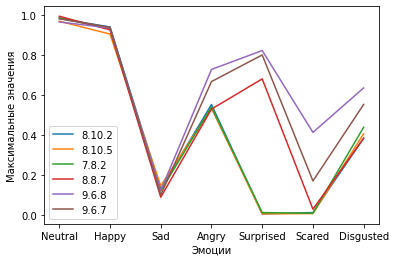

In [148]:
best_models = [208, 211, 120, 197, 254, 253]
x = seven_fields
for i in best_models:
    plt.plot(x, models[i][2].predict(df_clear[fields]).max().values, label=models[i][0])
plt.xlabel("Эмоции")
plt.ylabel("Максимальные значения")
plt.legend()
plt.show()

In [149]:
x

['Neutral', 'Happy', 'Sad', 'Angry', 'Surprised', 'Scared', 'Disgusted']

In [150]:
set(df_metrics.sort_values(by=['norm'])[:50].index).intersection(set(best_models))

{197, 253, 254}

In [151]:
best_models[:3]

[208, 211, 120]

In [46]:
set(best_models[:3]).intersection(set(df_metrics.sort_values(by=['stat'])[:25].index))

{120, 208, 211}

In [49]:
df_clear_metrics = pd.DataFrame(columns = ['model'] + list(x) + metrics)
df_clear_metrics

Empty DataFrame
Columns: [model, Neutral, Happy, Sad, Angry, Surprised, Scared, Disgusted, mean, norm, stat]
Index: []

In [348]:
# best_models[:3] + list(df_metrics.sort_values(by=['norm'])[:50].index)

In [52]:
best_models_sort = [set(df_metrics.sort_values(by=[metric])[:50].index) for metric in metrics]
best_models_sort = set(best_models_sort[0]).union(*best_models_sort[1:])
# best_models_sort

In [53]:
len(best_models_sort)

103

In [55]:
df_metrics.iloc[1]

model       6.2.3
layer       third
N           6.2.3
mean     0.062971
norm     0.175059
stat     0.465435
Name: 1, dtype: object

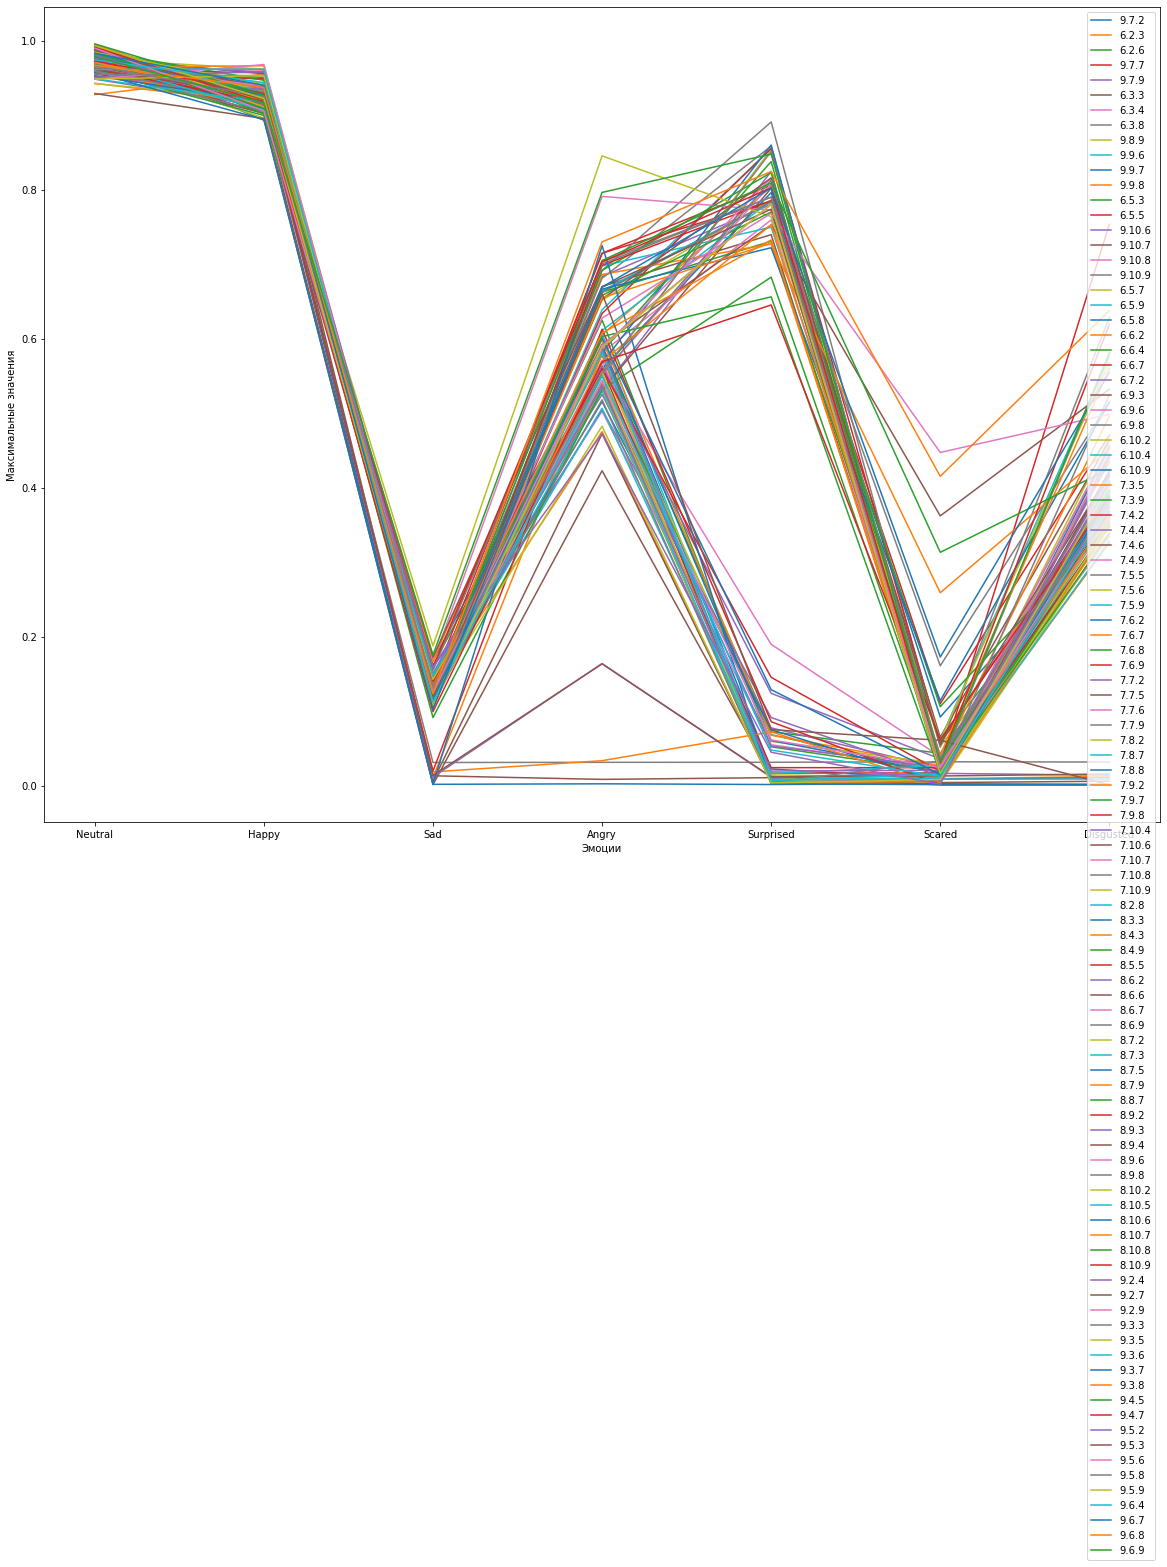

In [373]:
plt.figure(figsize=(20, 15))
for i in best_models_sort:
    values = models[i][2].predict(df_clear[fields]).max().values
    plt.plot(x, values, label=models[i][0])
    entry_dict = {'model': models[i][0]}
    entry_dict.update({metric: df_metrics.iloc[i][metric] for metric in metrics})
    entry_dict.update({emotion: values[j] for j, emotion in enumerate(x)})
    df_clear_metrics = df_clear_metrics.append(entry_dict, ignore_index = True)
plt.xlabel("Эмоции")
plt.ylabel("Максимальные значения")
plt.legend()
plt.show()

In [381]:
df_clear_metrics.sort_values('stat')[30:40]

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
89   9.3.6  0.961710  0.962105  0.117271  0.582350   0.006612  0.015289   
21   6.6.2  0.955223  0.923593  0.010677  0.579935   0.009324  0.009224   
13   6.5.5  0.952739  0.949657  0.121294  0.560909   0.016713  0.017005   
38   7.5.6  0.942629  0.922295  0.126012  0.564554   0.059296  0.029513   
73   8.9.2  0.962152  0.918583  0.019572  0.612856   0.085735  0.001400   
25   6.9.3  0.984796  0.937874  0.013104  0.008302   0.010608  0.008623   
69   8.7.3  0.949114  0.917922  0.126104  0.506689   0.016221  0.026795   
29  6.10.4  0.959091  0.909585  0.121980  0.607451   0.008704  0.008715   
12   6.5.3  0.967371  0.947930  0.122256  0.551379   0.068260  0.017474   
90   9.3.7  0.980606  0.926534  0.114784  0.601173   0.128741  0.014770   

    Disgusted      mean      norm      stat  
89   0.389558  0.061345  0.168894  0.326113  
21   0.012220  0.055746  0.165186  0.326185  
13   0.394262  0.057121  0.162428  0.326190  
38   0.357791  0.061393  0.168072  0.326604  
73   0.001121  0.061258  0.172503  0.326763  
25   0.010556  0.067190  0.204588  0.326836  
69   0.394597  0.056950  0.160440  0.326878  
29   0.008754  0.056118  0.160981  0.327152  
12   0.347244  0.057991  0.158568  0.327209  
90   0.387822  0.058702  0.157873  0.327413

In [420]:
df_clear_metrics.sort_values('Scared')[-15:]

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
95    9.5.3  0.988857  0.921005  0.118003  0.660735   0.075102  0.060767   
49    7.8.7  0.989357  0.925310  0.112902  0.697790   0.749906  0.061434   
93    9.4.7  0.991911  0.916810  0.099230  0.569186   0.645487  0.061706   
35    7.4.6  0.972272  0.902327  0.112989  0.531319   0.802246  0.064977   
10    9.9.7  0.961022  0.921614  0.105901  0.663687   0.783989  0.092087   
62    8.4.9  0.992448  0.902187  0.130918  0.658275   0.770267  0.106013   
3     9.7.7  0.972760  0.930563  0.140573  0.714888   0.785160  0.109959   
70    8.7.5  0.989269  0.907586  0.125115  0.666672   0.722299  0.113952   
47    7.7.9  0.959390  0.905078  0.127081  0.703282   0.790263  0.160914   
100   9.6.7  0.983495  0.940344  0.102627  0.669330   0.802557  0.172595   
71    8.7.9  0.965326  0.961618  0.110757  0.655136   0.728304  0.259006   
82   8.10.8  0.982175  0.909494  0.123550  0.705157   0.809288  0.313259   
55   7.10.6  0.986265  0.925153  0.129795  0.592408   0.753001  0.362147   
101   9.6.8  0.967498  0.937298  0.124065  0.730126   0.824604  0.415297   
76    8.9.6  0.990963  0.921514  0.130379  0.627817   0.768453  0.447355   

     Disgusted      mean      norm      stat  
95    0.000848  0.055570  0.157173  0.327781  
49    0.575871  0.052429  0.144682  0.367822  
93    0.388040  0.051523  0.142129  0.346822  
35    0.463123  0.052358  0.145384  0.351046  
10    0.348348  0.051586  0.143904  0.349005  
62    0.349670  0.051311  0.141488  0.351699  
3     0.470668  0.052485  0.144391  0.365122  
70    0.514801  0.051468  0.142045  0.356153  
47    0.515105  0.052448  0.144735  0.361276  
100   0.554978  0.050416  0.139019  0.354406  
71    0.452033  0.051657  0.142614  0.361524  
82    0.425297  0.050540  0.140494  0.366824  
55    0.532289  0.051851  0.143968  0.370717  
101   0.637826  0.050386  0.139357  0.392956  
76    0.498598  0.051978  0.143918  0.366416

In [424]:
best_models = best_models.union(df_clear_metrics.sort_values('Scared')[-15:].index)
best_models

{3, 10, 35, 47, 49, 55, 62, 70, 71, 76, 82, 93, 95, 100, 101}

In [427]:
df_clear_metrics.sort_values('Sad')[-15:]

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
74    8.9.3  0.970909  0.958090  0.147654  0.587524   0.008563  0.006265   
79   8.10.5  0.971317  0.906909  0.148008  0.535595   0.007729  0.009427   
54   7.10.4  0.951834  0.934896  0.150532  0.563158   0.123878  0.035806   
77    8.9.8  0.967273  0.922493  0.154884  0.700593   0.790319  0.026163   
17   9.10.9  0.980976  0.933078  0.155704  0.691760   0.891243  0.051588   
24    6.7.2  0.990157  0.934608  0.157898  0.525252   0.077484  0.023375   
83   8.10.9  0.973292  0.929226  0.158965  0.703314   0.802793  0.031261   
94    9.5.2  0.981100  0.915648  0.159202  0.472870   0.044703  0.001849   
2     6.2.6  0.978866  0.917742  0.161467  0.585235   0.072355  0.043326   
36    7.4.9  0.980619  0.911853  0.166144  0.791268   0.772844  0.020537   
41    7.6.7  0.956371  0.911821  0.167554  0.686317   0.727500  0.033499   
0     9.7.2  0.988509  0.893460  0.167613  0.589569   0.022283  0.008661   
75    8.9.4  0.993474  0.917996  0.172448  0.669409   0.774161  0.018572   
102   9.6.9  0.978979  0.916994  0.175512  0.796627   0.848060  0.029850   
58   7.10.9  0.993581  0.923687  0.187532  0.845664   0.764002  0.060451   

     Disgusted      mean      norm      stat  
74    0.402861  0.057895  0.159875  0.322888  
79    0.408667  0.054284  0.152386  0.319964  
54    0.415910  0.059251  0.160626  0.327974  
77    0.579727  0.051052  0.140405  0.363628  
17    0.628569  0.052117  0.142763  0.368249  
24    0.414912  0.058525  0.158504  0.324471  
83    0.619397  0.050880  0.140440  0.363934  
94    0.441755  0.056994  0.159360  0.320997  
2     0.361784  0.058391  0.158985  0.325186  
36    0.457293  0.051393  0.143263  0.368951  
41    0.496139  0.051865  0.144825  0.352762  
0     0.453447  0.058159  0.162023  0.329179  
75    0.422542  0.051154  0.141142  0.357687  
102   0.581666  0.051961  0.144260  0.381113  
58    0.568246  0.050654  0.139693  0.371961

In [429]:
best_models = best_models.union(df_clear_metrics.sort_values('Sad')[-15:].index)
len(best_models)

30

In [393]:
df_clear_metrics.sort_values('Surprised')[-10:]

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
14   9.10.6  0.971364  0.915065  0.139100  0.530987   0.824813  0.017781   
42    7.6.8  0.960673  0.899938  0.145601  0.582463   0.837933  0.021503   
102   9.6.9  0.978979  0.916994  0.175512  0.796627   0.848060  0.029850   
97    9.5.8  0.966680  0.925174  0.133612  0.554692   0.851548  0.036516   
18    6.5.7  0.969668  0.896648  0.142883  0.552666   0.854485  0.015722   
9     9.9.6  0.973330  0.911681  0.114911  0.638975   0.855440  0.018681   
23    6.6.7  0.994951  0.920159  0.114332  0.633943   0.855644  0.059677   
27    6.9.8  0.984199  0.916804  0.119630  0.681251   0.858752  0.022430   
30   6.10.9  0.975793  0.956616  0.131679  0.567367   0.860245  0.024868   
17   9.10.9  0.980976  0.933078  0.155704  0.691760   0.891243  0.051588   

     Disgusted      mean      norm      stat  
14    0.434978  0.052137  0.143601  0.348921  
42    0.384833  0.052308  0.143816  0.340692  
102   0.581666  0.051961  0.144260  0.381113  
97    0.379859  0.051581  0.142451  0.353738  
18    0.467296  0.052145  0.143679  0.346148  
9     0.366194  0.052343  0.145941  0.343012  
23    0.395521  0.052292  0.144110  0.354441  
27    0.455252  0.052138  0.143341  0.367451  
30    0.390810  0.050951  0.139834  0.343409  
17    0.628569  0.052117  0.142763  0.368249

In [430]:
best_models = best_models.union(df_clear_metrics.sort_values('Surprised')[-15:].index)
len(best_models)

42

In [394]:
df_clear_metrics.sort_values('Disgusted')[-10:]

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
100   9.6.7  0.983495  0.940344  0.102627  0.669330   0.802557  0.172595   
81   8.10.7  0.971217  0.921129  0.121600  0.569653   0.753080  0.040904   
58   7.10.9  0.993581  0.923687  0.187532  0.845664   0.764002  0.060451   
49    7.8.7  0.989357  0.925310  0.112902  0.697790   0.749906  0.061434   
77    8.9.8  0.967273  0.922493  0.154884  0.700593   0.790319  0.026163   
102   9.6.9  0.978979  0.916994  0.175512  0.796627   0.848060  0.029850   
83   8.10.9  0.973292  0.929226  0.158965  0.703314   0.802793  0.031261   
17   9.10.9  0.980976  0.933078  0.155704  0.691760   0.891243  0.051588   
101   9.6.8  0.967498  0.937298  0.124065  0.730126   0.824604  0.415297   
53    7.9.8  0.967150  0.915840  0.108265  0.698731   0.785487  0.027918   

     Disgusted      mean      norm      stat  
100   0.554978  0.050416  0.139019  0.354406  
81    0.560488  0.052321  0.144092  0.345615  
58    0.568246  0.050654  0.139693  0.371961  
49    0.575871  0.052429  0.144682  0.367822  
77    0.579727  0.051052  0.140405  0.363628  
102   0.581666  0.051961  0.144260  0.381113  
83    0.619397  0.050880  0.140440  0.363934  
17    0.628569  0.052117  0.142763  0.368249  
101   0.637826  0.050386  0.139357  0.392956  
53    0.753780  0.051319  0.141455  0.369703

In [431]:
best_models = best_models.union(df_clear_metrics.sort_values('Disgusted')[-15:].index)
len(best_models)

45

In [433]:
for emotion in seven_fields:
    best_models = best_models.union(df_clear_metrics.sort_values(emotion)[-15:].index)

In [437]:
df_metrics.sort_values('mean')[:50]

model  layer       N      mean      norm      stat
254   9.6.8  third   9.6.8  0.050386  0.139357  0.392956
253   9.6.7  third   9.6.7  0.050416  0.139019  0.354406
214  8.10.8  third  8.10.8  0.050540  0.140494  0.366824
141  7.10.7  third  7.10.7  0.050636  0.140505  0.347470
143  7.10.9  third  7.10.9  0.050654  0.139693  0.371961
215  8.10.9  third  8.10.9  0.050880  0.140440  0.363934
71   6.10.9  third  6.10.9  0.050951  0.139834  0.343409
263   9.7.9  third   9.7.9  0.050955  0.141234  0.352974
206   8.9.8  third   8.9.8  0.051052  0.140405  0.363628
202   8.9.4  third   8.9.4  0.051154  0.141142  0.357687
133   7.9.7  third   7.9.7  0.051187  0.140624  0.358597
111   7.6.9  third   7.6.9  0.051270  0.141862  0.356003
167   8.4.9  third   8.4.9  0.051311  0.141488  0.351699
134   7.9.8  third   7.9.8  0.051319  0.141455  0.369703
285  9.10.7  third  9.10.7  0.051378  0.141924  0.352204
95    7.4.9  third   7.4.9  0.051393  0.143263  0.368951
187   8.7.5  third   8.7.5  0.051468  0.142045  0.356153
237   9.4.7  third   9.4.7  0.051523  0.142129  0.346822
103   7.5.9  third   7.5.9  0.051553  0.142942  0.346870
246   9.5.8  third   9.5.8  0.051581  0.142451  0.353738
277   9.9.7  third   9.9.7  0.051586  0.143904  0.349005
191   8.7.9  third   8.7.9  0.051657  0.142614  0.361524
278   9.9.8  third   9.9.8  0.051751  0.142970  0.342110
180   8.6.6  third   8.6.6  0.051754  0.142941  0.359557
247   9.5.9  third   9.5.9  0.051848  0.142379  0.349948
140  7.10.6  third  7.10.6  0.051851  0.143968  0.370717
109   7.6.7  third   7.6.7  0.051865  0.144825  0.352762
87    7.3.9  third   7.3.9  0.051881  0.143465  0.354207
271   9.8.9  third   9.8.9  0.051936  0.143346  0.354032
255   9.6.9  third   9.6.9  0.051961  0.144260  0.381113
204   8.9.6  third   8.9.6  0.051978  0.143918  0.366416
286  9.10.8  third  9.10.8  0.051994  0.144095  0.347209
235   9.4.5  third   9.4.5  0.052064  0.144958  0.347438
230   9.3.8  third   9.3.8  0.052083  0.143144  0.349500
183   8.6.9  third   8.6.9  0.052106  0.143478  0.348081
287  9.10.9  third  9.10.9  0.052117  0.142763  0.368249
284  9.10.6  third  9.10.6  0.052137  0.143601  0.348921
62    6.9.8  third   6.9.8  0.052138  0.143341  0.367451
29    6.5.7  third   6.5.7  0.052145  0.143679  0.346148
37    6.6.7  third   6.6.7  0.052292  0.144110  0.354441
110   7.6.8  third   7.6.8  0.052308  0.143816  0.340692
213  8.10.7  third  8.10.7  0.052321  0.144092  0.345615
276   9.9.6  third   9.9.6  0.052343  0.145941  0.343012
244   9.5.6  third   9.5.6  0.052345  0.143405  0.352696
92    7.4.6  third   7.4.6  0.052358  0.145384  0.351046
31    6.5.9  third   6.5.9  0.052377  0.144182  0.358860
142  7.10.8  third  7.10.8  0.052384  0.144225  0.361267
181   8.6.7  third   8.6.7  0.052406  0.144603  0.347073
197   8.8.7  third   8.8.7  0.052409  0.144459  0.339769
30    6.5.8  third   6.5.8  0.052418  0.145193  0.340610

In [438]:
best_models = best_models.union(df_metrics.sort_values('mean')[:50].index)

In [439]:
len(best_models)

110

In [441]:
best_models = best_models.union(df_metrics.sort_values('norm')[:50].index)

In [442]:
len(best_models)

113

In [443]:
best_models

{0,
 1,
 2,
 3,
 6,
 7,
 9,
 10,
 14,
 17,
 18,
 22,
 23,
 24,
 27,
 28,
 29,
 30,
 31,
 33,
 35,
 36,
 37,
 41,
 42,
 43,
 47,
 49,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 61,
 62,
 64,
 65,
 67,
 68,
 70,
 71,
 72,
 74,
 75,
 76,
 77,
 79,
 80,
 81,
 82,
 83,
 84,
 86,
 87,
 88,
 89,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 100,
 101,
 102,
 103,
 109,
 110,
 111,
 119,
 125,
 133,
 134,
 140,
 141,
 142,
 143,
 167,
 180,
 181,
 183,
 187,
 191,
 197,
 202,
 204,
 206,
 213,
 214,
 215,
 230,
 235,
 237,
 244,
 246,
 247,
 253,
 254,
 255,
 261,
 263,
 271,
 276,
 277,
 278,
 284,
 285,
 286,
 287}

### Сохранение всех моделей

In [94]:
path_to_saved_models = os.path.join(project_dir_path, dir_model, layer, '_1')
save_name = 'model_third_'
path = os.path.join(path_to_saved_models, save_name)
path

'/home/ivan/Рабочий стол/Учёба/Git/NIR_1_sem_magistracy/saved_models/third/_1/model_third_'

In [95]:
path + models[0][0]

'/home/ivan/Рабочий стол/Учёба/Git/NIR_1_sem_magistracy/saved_models/third/_1/model_third_6.2.2'

In [398]:
for model_tuple in models:
    nn = model_tuple[2]
    cur_path = path + model_tuple[0]
    nn.model.save(cur_path)

INFO:tensorflow:Assets written to: ../saved_models/third/model_third_6.2.2/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_6.2.3/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_6.2.4/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_6.2.5/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_6.2.6/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_6.2.7/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_6.2.8/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_6.2.9/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_6.3.2/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_6.3.3/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_6.3.4/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_6.3.5/assets
INFO:tensorflow:

INFO:tensorflow:Assets written to: ../saved_models/third/model_third_7.5.6/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_7.5.7/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_7.5.8/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_7.5.9/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_7.6.2/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_7.6.3/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_7.6.4/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_7.6.5/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_7.6.6/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_7.6.7/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_7.6.8/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_7.6.9/assets
INFO:tensorflow:

INFO:tensorflow:Assets written to: ../saved_models/third/model_third_8.9.2/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_8.9.3/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_8.9.4/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_8.9.5/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_8.9.6/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_8.9.7/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_8.9.8/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_8.9.9/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_8.10.2/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_8.10.3/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_8.10.4/assets
INFO:tensorflow:Assets written to: ../saved_models/third/model_third_8.10.5/assets
INFO:tensorf

### Сохранение метрик df_metrics_1.db

In [110]:
v = 1
prefix = f'_{v}'
name_db = 'df_metrics'
db_file = f"{name_db}{prefix}.db"
metrics_dir = 'model_metrics'
metrics_dir_path = os.path.join(project_dir_path, metrics_dir, layer, prefix)
db_path = os.path.join(metrics_dir_path, db_file)
db_path

'/home/ivan/Рабочий стол/Учёба/Git/NIR_1_sem_magistracy/model_metrics/third/_1/df_metrics_1.db'

In [115]:
tools.save_to_db(db_path, name_db, df_metrics)

In [120]:
connection = sqlite3.connect(db_path)
pd.read_sql(f'select * from {name_db}', con=connection)

model  layer       N                mean               norm  \
0     6.2.2  third   6.2.2   0.137588111946182  0.372504504249433   
1     6.2.3  third   6.2.3  0.0629709893273934  0.175059110148287   
2     6.2.4  third   6.2.4  0.0713908746516161  0.206439730546283   
3     6.2.5  third   6.2.5  0.0641953191556134  0.172972058430538   
4     6.2.6  third   6.2.6  0.0583913929079195  0.158985445984666   
..      ...    ...     ...                 ...                ...   
283  9.10.5  third  9.10.5  0.0538203694473672   0.14704192892132   
284  9.10.6  third  9.10.6  0.0521365433459382   0.14360060549378   
285  9.10.7  third  9.10.7  0.0513782497023927  0.141923995187477   
286  9.10.8  third  9.10.8  0.0519940261682849  0.144094985574321   
287  9.10.9  third  9.10.9  0.0521168519865639  0.142762948981966   

                  stat  
0    0.462031185626984  
1    0.465435355901718  
2    0.492294490337372  
3    0.474698573350906  
4    0.468112796545029  
..                 ...  
283  0.507153332233429  
284  0.506155431270599  
285  0.511227428913116  
286   0.50368344783783  
287  0.535004019737244  

[288 rows x 6 columns]

In [121]:
df_metrics

model  layer       N      mean      norm      stat
0     6.2.2  third   6.2.2  0.137588  0.372505  0.462031
1     6.2.3  third   6.2.3  0.062971  0.175059  0.465435
2     6.2.4  third   6.2.4  0.071391  0.206440  0.492294
3     6.2.5  third   6.2.5  0.064195  0.172972  0.474699
4     6.2.6  third   6.2.6  0.058391  0.158985  0.468113
..      ...    ...     ...       ...       ...       ...
283  9.10.5  third  9.10.5  0.053820  0.147042  0.507153
284  9.10.6  third  9.10.6  0.052137  0.143601  0.506155
285  9.10.7  third  9.10.7  0.051378  0.141924  0.511227
286  9.10.8  third  9.10.8  0.051994  0.144095  0.503683
287  9.10.9  third  9.10.9  0.052117  0.142763  0.535004

[288 rows x 6 columns]

In [122]:
metrics

['mean', 'norm', 'stat']

In [123]:
df_metrics.iloc[0]

model       6.2.2
layer       third
N           6.2.2
mean     0.137588
norm     0.372505
stat     0.462031
Name: 0, dtype: object

In [128]:
best_models_ = [208, 211, 120, 197, 254, 253]

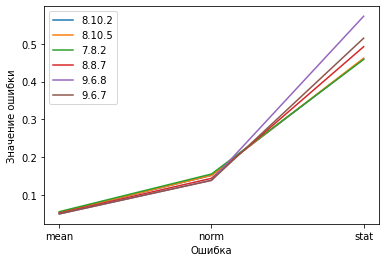

In [131]:
for i in best_models_:
    plt.plot(metrics, df_metrics.iloc[i][metrics], label=models[i][0])
plt.xlabel("Ошибка")
plt.ylabel("Значение ошибки")
plt.legend()
plt.show()

In [218]:
# best_models_diff = []

In [219]:
# for i in best_models:
#     best_models_diff.append((i, models[i][2].get_diff(test)))

In [132]:
best_models_

[208, 211, 120, 197, 254, 253]

In [133]:
train_diff = models[254][2].create_train_df_from_diff(test)
train_diff

Neutral  Happy   Sad  Angry  Surprised  \
Index_                                                                     
00:00:09.848_Fomin_5                 0.79   0.05  0.01   0.01       0.01   
00:00:08.757_Fomin_5                 0.79   0.05  0.01   0.01       0.01   
00:00:08.424_Fomin_5                 0.79   0.05  0.01   0.01       0.01   
00:00:02.909_Korsakov_5              0.98   0.00  0.00   0.02       0.02   
00:00:02.878_Korsakov_5              0.98   0.00  0.00   0.02       0.02   
...                                   ...    ...   ...    ...        ...   
00:01:28.300_Турчина Екатерина_1     0.33   0.79  0.00   0.00       0.00   
00:01:26.900_Турчина Екатерина_1     0.28   0.79  0.00   0.00       0.00   
00:01:28.000_Турчина Екатерина_1     0.28   0.80  0.00   0.00       0.00   
00:01:33.700_Aleksashina_1           0.13   0.82  0.00   0.00       0.00   
00:00:17.100_Турчина Екатерина_1     0.23   0.89  0.00   0.00       0.00   

                                  Scared  Disgusted  Valence  Arousal  
Index_                                                                 
00:00:09.848_Fomin_5                 0.0        0.0     0.04     0.28  
00:00:08.757_Fomin_5                 0.0        0.0     0.04     0.28  
00:00:08.424_Fomin_5                 0.0        0.0     0.04     0.28  
00:00:02.909_Korsakov_5              0.0        0.0    -0.02     0.41  
00:00:02.878_Korsakov_5              0.0        0.0    -0.02     0.41  
...                                  ...        ...      ...      ...  
00:01:28.300_Турчина Екатерина_1     0.0        0.0     0.79     0.45  
00:01:26.900_Турчина Екатерина_1     0.0        0.0     0.79     0.47  
00:01:28.000_Турчина Екатерина_1     0.0        0.0     0.80     0.46  
00:01:33.700_Aleksashina_1           0.0        0.0     0.82     0.33  
00:00:17.100_Турчина Екатерина_1     0.0        0.0     0.89     0.49  

[4660 rows x 9 columns]

In [135]:
train_diffs = []

In [136]:
for i in best_models_:
    train_df_from_diff = models[i][2].create_train_df_from_diff(test)
    set_from_diff = {entry[0] for entry in list(train_df_from_diff.groupby(by=fields))}
    train_diffs.append(set_from_diff)

In [137]:
outliers = train_diffs[0].intersection(*train_diffs[1:])
outliers

{(0.92, 0.04, 0.0, 0.01, 0.0, 0.01, 0.0, 0.03, 0.51),
 (0.59, 0.55, 0.0, 0.0, 0.0, 0.0, 0.0, 0.54, 0.44),
 (0.83, 0.0, 0.0, 0.3, 0.0, 0.0, 0.0, -0.3, 0.68),
 (0.22, 0.61, 0.0, 0.04, 0.0, 0.0, 0.0, 0.56, 0.32),
 (0.55, 0.34, 0.0, 0.01, 0.0, 0.0, 0.0, 0.34, 0.44),
 (0.65, 0.0, 0.0, 0.18, 0.05, 0.03, 0.0, -0.18, 0.6),
 (0.04, 0.0, 0.0, 0.01, 0.0, 0.0, 0.96, -0.96, 0.62),
 (0.35, 0.0, 0.02, 0.01, 0.0, 0.0, 0.64, -0.63, 0.28),
 (0.07, 0.0, 0.0, 0.0, 0.95, 0.0, 0.0, 0.0, 0.63),
 (0.06, 0.01, 0.0, 0.03, 0.0, 0.0, 0.91, -0.9, 0.42),
 (0.88, 0.21, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21, 0.27),
 (0.61, 0.0, 0.01, 0.39, 0.0, 0.0, 0.0, -0.39, 0.32),
 (0.28, 0.0, 0.05, 0.65, 0.0, 0.0, 0.0, -0.65, 0.69),
 (0.86, 0.0, 0.16, 0.13, 0.0, 0.0, 0.0, -0.24, 0.31),
 (0.71, 0.41, 0.0, 0.0, 0.0, 0.0, 0.0, 0.41, 0.49),
 (0.96, 0.01, 0.02, 0.01, 0.02, 0.0, 0.0, -0.02, 0.55),
 (0.39, 0.28, 0.03, 0.01, 0.0, 0.0, 0.0, 0.25, 0.5),
 (0.48, 0.0, 0.05, 0.54, 0.0, 0.0, 0.02, -0.54, 0.65),
 (0.79, 0.0, 0.01, 0.01, 0.22, 0.0, 0.0

In [139]:
test_groupby = tools.groupby(df)
test_groupby

Neutral  Happy   Sad  Angry  Surprised  \
Index_                                                                    
00:01:48.200_Бондаренко Денис_2     0.99   0.00  0.00   0.00       0.01   
00:00:01.878_Керов Андрей_5         0.99   0.00  0.00   0.00       0.01   
00:00:07.500_Provotorov_8           0.99   0.00  0.00   0.00       0.01   
00:00:02.200_Боим_10                0.99   0.00  0.00   0.00       0.01   
00:00:00.575_Керов Андрей_8         0.99   0.00  0.01   0.01       0.01   
...                                  ...    ...   ...    ...        ...   
00:00:17.500_Смолин Александр_1     0.02   0.96  0.00   0.00       0.00   
00:00:20.900_Aleksashina_1          0.01   0.98  0.00   0.00       0.00   
00:00:16.900_Смолин Александр_1     0.02   0.97  0.00   0.00       0.00   
00:00:17.000_Смолин Александр_1     0.02   0.97  0.00   0.00       0.00   
00:00:15.000_Aleksashina_1          0.01   0.99  0.00   0.00       0.00   

                                 Scared  Disgusted  Valence  Arousal  
Index_                                                                
00:01:48.200_Бондаренко Денис_2     0.0        0.0    -0.00     0.25  
00:00:01.878_Керов Андрей_5         0.0        0.0    -0.00     0.25  
00:00:07.500_Provotorov_8           0.0        0.0    -0.00     0.25  
00:00:02.200_Боим_10                0.0        0.0    -0.00     0.25  
00:00:00.575_Керов Андрей_8         0.0        0.0    -0.01     0.25  
...                                 ...        ...      ...      ...  
00:00:17.500_Смолин Александр_1     0.0        0.0     0.96     0.90  
00:00:20.900_Aleksashina_1          0.0        0.0     0.97     0.67  
00:00:16.900_Смолин Александр_1     0.0        0.0     0.97     0.87  
00:00:17.000_Смолин Александр_1     0.0        0.0     0.97     0.89  
00:00:15.000_Aleksashina_1          0.0        0.0     0.98     0.79  

[6481 rows x 9 columns]

In [140]:
df_worst_metrics = pd.DataFrame(columns = ['model'] + metrics)
df_worst_metrics

Empty DataFrame
Columns: [model, mean, norm, stat]
Index: []

In [141]:
for i in best_models_:
    df_train = models[i][2].create_train_df_from_diff(test)
    entry_dict = {'model': models[i][0]}
    entry_dict.update({metric: models[i][2].model_metric(df_train, metric) for metric in metrics})
    df_worst_metrics = df_worst_metrics.append(entry_dict, ignore_index = True)

/home/ivan/Рабочий стол/Учёба/Git/NIR_1_sem_magistracy/lib/nn_train/neural_network.py:173: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  statistics_df = statistics_df.append(entry_dict, ignore_index = True)
/tmp/ipykernel_4976/3627592075.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_worst_metrics = df_worst_metrics.append(entry_dict, ignore_index = True)
/home/ivan/Рабочий стол/Учёба/Git/NIR_1_sem_magistracy/lib/nn_train/neural_network.py:173: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  statistics_df = statistics_df.append(entry_dict, ignore_index = True)
/tmp/ipykernel_4976/3627592075.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat

In [143]:
df_worst_metrics

model      mean      norm      stat
0  8.10.2  0.105436  0.295817  0.438815
1  8.10.5  0.104304  0.291916  0.436405
2   7.8.2  0.105862  0.293802  0.435804
3   8.8.7  0.101151  0.279237  0.471739
4   9.6.8  0.097597  0.270529  0.557169
5   9.6.7  0.103206   0.28545  0.498441

In [297]:
# {entry[0] for entry in list(train_diffs[0].groupby(by=fields))}

In [144]:
list(train_diff.groupby(by=fields))[0][0]

(0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 1.0, -1.0, 0.63)

In [145]:
models[253][2].create_train_df_from_diff(test)

Neutral  Happy   Sad  Angry  Surprised  \
Index_                                                                     
00:00:09.060_Fomin_5                 0.79   0.05  0.01   0.01       0.01   
00:00:10.060_Fomin_5                 0.79   0.05  0.01   0.01       0.01   
00:00:10.363_Fomin_5                 0.79   0.05  0.01   0.01       0.01   
00:00:11.696_Fomin_5                 0.78   0.07  0.01   0.03       0.02   
00:00:12.727_Fomin_5                 0.78   0.07  0.01   0.03       0.02   
...                                   ...    ...   ...    ...        ...   
00:01:28.400_Турчина Екатерина_1     0.35   0.78  0.00   0.00       0.00   
00:01:26.800_Турчина Екатерина_1     0.29   0.78  0.00   0.00       0.00   
00:01:28.300_Турчина Екатерина_1     0.33   0.79  0.00   0.00       0.00   
00:01:26.900_Турчина Екатерина_1     0.28   0.79  0.00   0.00       0.00   
00:01:28.000_Турчина Екатерина_1     0.28   0.80  0.00   0.00       0.00   

                                  Scared  Disgusted  Valence  Arousal  
Index_                                                                 
00:00:09.060_Fomin_5                 0.0        0.0     0.04     0.28  
00:00:10.060_Fomin_5                 0.0        0.0     0.04     0.28  
00:00:10.363_Fomin_5                 0.0        0.0     0.04     0.28  
00:00:11.696_Fomin_5                 0.0        0.0     0.04     0.27  
00:00:12.727_Fomin_5                 0.0        0.0     0.04     0.27  
...                                  ...        ...      ...      ...  
00:01:28.400_Турчина Екатерина_1     0.0        0.0     0.78     0.45  
00:01:26.800_Турчина Екатерина_1     0.0        0.0     0.78     0.47  
00:01:28.300_Турчина Екатерина_1     0.0        0.0     0.79     0.45  
00:01:26.900_Турчина Екатерина_1     0.0        0.0     0.79     0.47  
00:01:28.000_Турчина Екатерина_1     0.0        0.0     0.80     0.46  

[4535 rows x 9 columns]

In [146]:
models[197][2].create_train_df_from_diff(test)

Neutral  Happy   Sad  Angry  Surprised  \
Index_                                                                     
00:00:09.272_Fomin_5                 0.79   0.05  0.01   0.01       0.01   
00:00:10.454_Fomin_5                 0.79   0.05  0.01   0.01       0.01   
00:00:09.151_Fomin_5                 0.79   0.05  0.01   0.01       0.01   
00:00:11.484_Fomin_5                 0.78   0.07  0.01   0.03       0.02   
00:00:11.757_Fomin_5                 0.78   0.07  0.01   0.03       0.02   
...                                   ...    ...   ...    ...        ...   
00:01:28.300_Турчина Екатерина_1     0.33   0.79  0.00   0.00       0.00   
00:01:27.000_Турчина Екатерина_1     0.27   0.79  0.00   0.00       0.00   
00:01:26.900_Турчина Екатерина_1     0.28   0.79  0.00   0.00       0.00   
00:01:28.000_Турчина Екатерина_1     0.28   0.80  0.00   0.00       0.00   
00:00:17.100_Турчина Екатерина_1     0.23   0.89  0.00   0.00       0.00   

                                  Scared  Disgusted  Valence  Arousal  
Index_                                                                 
00:00:09.272_Fomin_5                 0.0        0.0     0.04     0.28  
00:00:10.454_Fomin_5                 0.0        0.0     0.04     0.28  
00:00:09.151_Fomin_5                 0.0        0.0     0.04     0.28  
00:00:11.484_Fomin_5                 0.0        0.0     0.04     0.27  
00:00:11.757_Fomin_5                 0.0        0.0     0.04     0.27  
...                                  ...        ...      ...      ...  
00:01:28.300_Турчина Екатерина_1     0.0        0.0     0.79     0.45  
00:01:27.000_Турчина Екатерина_1     0.0        0.0     0.79     0.46  
00:01:26.900_Турчина Екатерина_1     0.0        0.0     0.79     0.47  
00:01:28.000_Турчина Екатерина_1     0.0        0.0     0.80     0.46  
00:00:17.100_Турчина Екатерина_1     0.0        0.0     0.89     0.49  

[4691 rows x 9 columns]

In [147]:
models[120][2].create_train_df_from_diff(test)

Neutral  Happy   Sad  Angry  Surprised  \
Index_                                                                     
00:00:08.545_Fomin_5                 0.79   0.05  0.01   0.01       0.01   
00:00:08.878_Fomin_5                 0.79   0.05  0.01   0.01       0.01   
00:00:10.000_Fomin_5                 0.79   0.05  0.01   0.01       0.01   
00:00:11.969_Fomin_5                 0.78   0.07  0.01   0.03       0.02   
00:00:11.696_Fomin_5                 0.78   0.07  0.01   0.03       0.02   
...                                   ...    ...   ...    ...        ...   
00:00:19.000_Турчина Екатерина_1     0.29   0.88  0.00   0.00       0.00   
00:00:16.500_Турчина Екатерина_1     0.25   0.90  0.00   0.00       0.00   
00:00:10.787_Керов Андрей_2          0.05   0.93  0.00   0.00       0.00   
00:00:07.454_Керов Андрей_2          0.03   0.94  0.00   0.00       0.00   
00:00:07.424_Керов Андрей_2          0.03   0.95  0.00   0.00       0.00   

                                  Scared  Disgusted  Valence  Arousal  
Index_                                                                 
00:00:08.545_Fomin_5                 0.0        0.0     0.04     0.28  
00:00:08.878_Fomin_5                 0.0        0.0     0.04     0.28  
00:00:10.000_Fomin_5                 0.0        0.0     0.04     0.28  
00:00:11.969_Fomin_5                 0.0        0.0     0.04     0.27  
00:00:11.696_Fomin_5                 0.0        0.0     0.04     0.27  
...                                  ...        ...      ...      ...  
00:00:19.000_Турчина Екатерина_1     0.0        0.0     0.87     0.47  
00:00:16.500_Турчина Екатерина_1     0.0        0.0     0.90     0.51  
00:00:10.787_Керов Андрей_2          0.0        0.0     0.93     0.46  
00:00:07.454_Керов Андрей_2          0.0        0.0     0.94     0.50  
00:00:07.424_Керов Андрей_2          0.0        0.0     0.95     0.50  

[4685 rows x 9 columns]

In [149]:
error_test = df[df.Index_ == '00:00:14.500_Смолин Александр_1'][fields]
error_test

Neutral     Happy      Sad     Angry  \
Index_                                                                   
00:00:14.500_Смолин Александр_1  0.842478  0.139869  0.00028  0.001647   

                                 Surprised    Scared  Disgusted   Valence  \
Index_                                                                      
00:00:14.500_Смолин Александр_1   0.000862  0.000201    0.00141  0.138222   

                                  Arousal  
Index_                                     
00:00:14.500_Смолин Александр_1  0.735849

In [150]:
models[254][2].predict(error_test[fields])

Neutral     Happy       Sad     Angry  \
Index_                                                                    
00:00:14.500_Смолин Александр_1  0.371901  0.132043  0.002304  0.005519   

                                 Surprised    Scared  Disgusted  
Index_                                                           
00:00:14.500_Смолин Александр_1   0.176522  0.000114   0.000002

In [151]:
models[197][2].predict(error_test[fields])

Neutral    Happy       Sad     Angry  \
Index_                                                                   
00:00:14.500_Смолин Александр_1  0.445229  0.17131  0.000826  0.003695   

                                 Surprised    Scared     Disgusted  
Index_                                                              
00:00:14.500_Смолин Александр_1   0.116587  0.000216  2.712396e-09

In [268]:
# df[fields].sort_values(by=['Valence']).iloc[21200:21250].sort_values(by=['Arousal'])

In [153]:
df_clear.sort_values('Angry')[-30:][fields]

Neutral  Happy  Sad  Angry  Surprised  Scared  \
Index_                                                                         
00:00:40.100_Бушунов Виктор_1     0.08    0.0  0.0   0.97        0.0     0.0   
00:00:36.400_Бушунов Виктор_1     0.02    0.0  0.0   0.97        0.0     0.0   
00:01:21.700_Бушунов Виктор_1     0.05    0.0  0.0   0.97        0.0     0.0   
00:01:12.900_Бушунов Виктор_1     0.04    0.0  0.0   0.97        0.0     0.0   
00:00:36.000_Бушунов Виктор_1     0.02    0.0  0.0   0.97        0.0     0.0   
00:00:40.400_Бушунов Виктор_1     0.10    0.0  0.0   0.97        0.0     0.0   
00:01:21.500_Бушунов Виктор_1     0.03    0.0  0.0   0.97        0.0     0.0   
00:00:39.900_Бушунов Виктор_1     0.05    0.0  0.0   0.97        0.0     0.0   
00:01:16.200_Бушунов Виктор_1     0.01    0.0  0.0   0.97        0.0     0.0   
00:01:16.000_Бушунов Виктор_1     0.01    0.0  0.0   0.97        0.0     0.0   
00:01:18.000_Бушунов Виктор_1     0.02    0.0  0.0   0.97        0.0     0.0   
00:01:17.800_Бушунов Виктор_1     0.02    0.0  0.0   0.97        0.0     0.0   
00:00:40.000_Бушунов Виктор_1     0.07    0.0  0.0   0.97        0.0     0.0   
00:00:37.700_Бушунов Виктор_1     0.01    0.0  0.0   0.98        0.0     0.0   
00:00:38.700_Бушунов Виктор_1     0.02    0.0  0.0   0.98        0.0     0.0   
00:00:39.600_Бушунов Виктор_1     0.04    0.0  0.0   0.98        0.0     0.0   
00:00:38.600_Бушунов Виктор_1     0.02    0.0  0.0   0.98        0.0     0.0   
00:00:38.200_Бушунов Виктор_1     0.02    0.0  0.0   0.98        0.0     0.0   
00:01:16.300_Бушунов Виктор_1     0.01    0.0  0.0   0.98        0.0     0.0   
00:00:34.200_Бушунов Виктор_1     0.01    0.0  0.0   0.98        0.0     0.0   
00:01:19.400_Бушунов Виктор_1     0.01    0.0  0.0   0.98        0.0     0.0   
00:01:20.200_Бушунов Виктор_1     0.01    0.0  0.0   0.98        0.0     0.0   
00:01:19.200_Бушунов Виктор_1     0.01    0.0  0.0   0.98        0.0     0.0   
00:00:39.100_Бушунов Виктор_1     0.02    0.0  0.0   0.98        0.0     0.0   
00:00:39.500_Бушунов Виктор_1     0.03    0.0  0.0   0.98        0.0     0.0   
00:01:21.000_Бушунов Виктор_1     0.02    0.0  0.0   0.98        0.0     0.0   
00:01:20.500_Бушунов Виктор_1     0.01    0.0  0.0   0.98        0.0     0.0   
00:01:21.300_Бушунов Виктор_1     0.02    0.0  0.0   0.98        0.0     0.0   
00:01:17.500_Бушунов Виктор_1     0.01    0.0  0.0   0.98        0.0     0.0   
00:01:16.700_Бушунов Виктор_1     0.01    0.0  0.0   0.98        0.0     0.0   

                               Disgusted  Valence  Arousal  
Index_                                                      
00:00:40.100_Бушунов Виктор_1       0.00    -0.97     0.75  
00:00:36.400_Бушунов Виктор_1       0.00    -0.97     0.81  
00:01:21.700_Бушунов Виктор_1       0.00    -0.97     0.63  
00:01:12.900_Бушунов Виктор_1       0.01    -0.97     0.69  
00:00:36.000_Бушунов Виктор_1       0.00    -0.97     0.81  
00:00:40.400_Бушунов Виктор_1       0.00    -0.97     0.74  
00:01:21.500_Бушунов Виктор_1       0.00    -0.97     0.64  
00:00:39.900_Бушунов Виктор_1       0.00    -0.97     0.77  
00:01:16.200_Бушунов Виктор_1       0.02    -0.97     0.68  
00:01:16.000_Бушунов Виктор_1       0.02    -0.97     0.68  
00:01:18.000_Бушунов Виктор_1       0.00    -0.97     0.67  
00:01:17.800_Бушунов Виктор_1       0.00    -0.97     0.67  
00:00:40.000_Бушунов Виктор_1       0.00    -0.97     0.76  
00:00:37.700_Бушунов Виктор_1       0.00    -0.98     0.83  
00:00:38.700_Бушунов Виктор_1       0.00    -0.98     0.81  
00:00:39.600_Бушунов Виктор_1       0.00    -0.97     0.78  
00:00:38.600_Бушунов Виктор_1       0.00    -0.98     0.81  
00:00:38.200_Бушунов Виктор_1       0.00    -0.98     0.82  
00:01:16.300_Бушунов Виктор_1       0.01    -0.98     0.68  
00:00:34.200_Бушунов Виктор_1       0.00    -0.98     0.83  
00:01:19.400_Бушунов Виктор_1       0.00    -0.98     0.66  
00:01:20.200_Бушунов Виктор_1       0.00    -0.98     0.65  
00:01:

In [154]:
df_metrics.sort_values(by=['stat'])[:20]

model  layer       N      mean      norm      stat
115   7.7.5  third   7.7.5  0.066939  0.194151  0.448252
128   7.9.2  third   7.9.2  0.063721  0.189687  0.454441
120   7.8.2  third   7.8.2  0.056273  0.155812  0.458773
208  8.10.2  third  8.10.2  0.054223  0.152205  0.460410
99    7.5.5  third   7.5.5  0.062140  0.196105  0.461406
113   7.7.3  third   7.7.3  0.137752  0.373018  0.462031
136  7.10.2  third  7.10.2  0.137827  0.373342  0.462031
144   8.2.2  third   8.2.2  0.137766  0.373015  0.462031
6     6.2.8  third   6.2.8  0.137345  0.372103  0.462031
74    7.2.4  third   7.2.4  0.137952  0.373618  0.462031
72    7.2.2  third   7.2.2  0.137952  0.373605  0.462031
192   8.8.2  third   8.8.2  0.137362  0.371800  0.462031
145   8.2.3  third   8.2.3  0.137880  0.373420  0.462031
121   7.8.3  third   7.8.3  0.137933  0.373597  0.462031
249   9.6.3  third   9.6.3  0.137743  0.372950  0.462031
0     6.2.2  third   6.2.2  0.137588  0.372505  0.462031
186   8.7.4  third   8.7.4  0.137812  0.373098  0.462031
264   9.8.2  third   9.8.2  0.138003  0.373670  0.462031
217   9.2.3  third   9.2.3  0.138024  0.373853  0.462031
272   9.9.2  third   9.9.2  0.137653  0.372613  0.462031

In [155]:
x = []
y = []
for metric in metrics:
    x.append(df_metrics.index)
    y.append(df_metrics[metric])

In [156]:
y[0]

0      0.137588
1      0.062971
2      0.071391
3      0.064195
4      0.058391
         ...   
283    0.053820
284    0.052137
285    0.051378
286    0.051994
287    0.052117
Name: mean, Length: 288, dtype: float64

### Визуализация метрик моделей на графиках

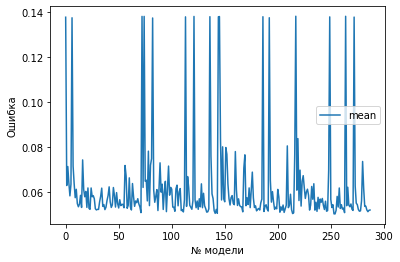

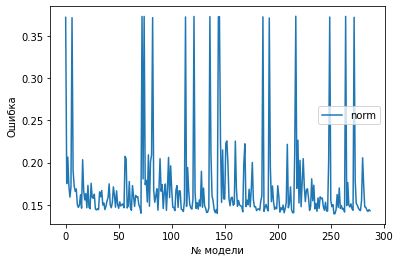

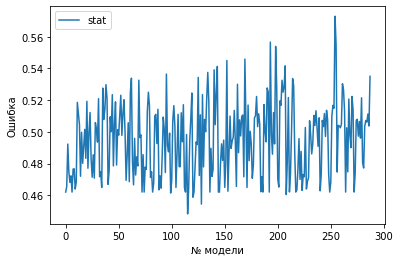

In [157]:
for i in range(len(metrics)):
    plt.plot(x[i], y[i], label=metrics[i])
    plt.xlabel("№ модели")
    plt.ylabel("Ошибка")
    plt.legend()
    plt.show()

### Дообучение

#### Дообучение (v_2)

In [444]:
test = nn.get_test()
test

Neutral     Happy       Sad     Angry  \
Index_                                                                   
00:00:00.000_Керов Андрей_3     0.987859  0.003336  0.008397  0.001824   
00:00:00.030_Керов Андрей_3     0.987882  0.003385  0.008362  0.001783   
00:00:00.060_Керов Андрей_3     0.987905  0.003434  0.008327  0.001741   
00:00:00.090_Керов Андрей_3     0.987929  0.003483  0.008292  0.001700   
00:00:00.121_Керов Андрей_3     0.988026  0.003506  0.008184  0.001645   
...                                  ...       ...       ...       ...   
00:01:51.700_Куликов Алексей_1  0.931563  0.000038  0.023971  0.067963   
00:01:51.800_Куликов Алексей_1  0.935643  0.000032  0.023777  0.062597   
00:01:51.900_Куликов Алексей_1  0.938411  0.000027  0.023437  0.059357   
00:01:52.000_Куликов Алексей_1  0.940782  0.000023  0.023035  0.056517   
00:01:52.100_Куликов Алексей_1  0.942106  0.000020  0.023117  0.054488   

                                Surprised    Scared  Disgusted   Valence  \
Index_                                                                     
00:00:00.000_Керов Андрей_3      0.007601  0.000069   0.000141 -0.005061   
00:00:00.030_Керов Андрей_3      0.007645  0.000081   0.000139 -0.004977   
00:00:00.060_Керов Андрей_3      0.007689  0.000092   0.000136 -0.004893   
00:00:00.090_Керов Андрей_3      0.007733  0.000103   0.000134 -0.004809   
00:00:00.121_Керов Андрей_3      0.007784  0.000113   0.000130 -0.004678   
...                                   ...       ...        ...       ...   
00:01:51.700_Куликов Алексей_1   0.026351  0.000250   0.000692 -0.067925   
00:01:51.800_Куликов Алексей_1   0.023741  0.000229   0.000799 -0.062565   
00:01:51.900_Куликов Алексей_1   0.021180  0.000213   0.000849 -0.059330   
00:01:52.000_Куликов Алексей_1   0.019016  0.000197   0.000878 -0.056494   
00:01:52.100_Куликов Алексей_1   0.017724  0.000184   0.000897 -0.054468   

                                 Arousal  
Index_                                    
00:00:00.000_Керов Андрей_3     0.247500  
00:00:00.030_Керов Андрей_3     0.247500  
00:00:00.060_Керов Андрей_3     0.247500  
00:00:00.090_Керов Андрей_3     0.247500  
00:00:00.121_Керов Андрей_3     0.247500  
...                                  ...  
00:01:51.700_Куликов Алексей_1  0.287489  
00:01:51.800_Куликов Алексей_1  0.287139  
00:01:51.900_Куликов Алексей_1  0.286695  
00:01:52.000_Куликов Алексей_1  0.286170  
00:01:52.100_Куликов Алексей_1  0.285693  

[25321 rows x 9 columns]

In [445]:
len(best_models)

113

In [449]:
list(best_models)[33]

41

In [456]:
models_2 = [models[i] for i in best_models]
models_2

[('6.2.2',
  '6.2.2',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7faa0824fb20>),
 ('6.2.3',
  '6.2.3',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7faa00191be0>),
 ('6.2.4',
  '6.2.4',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7faa00142160>),
 ('6.2.5',
  '6.2.5',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7faa00078b80>),
 ('9.7.7',
  '9.7.7',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa8406ebdc0>),
 ('6.2.8',
  '6.2.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9e0609df0>),
 ('6.2.9',
  '6.2.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9e07099a0>),
 ('9.7.9',
  '9.7.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa84085f850>),
 ('6.3.3',
  '6.3.3',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9e049efa0>),
 ('6.3.4',
  '6.3.4',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c730e4c0>),
 ('6.3.8',
  '6.3.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c7732bb0>),
 ('9.8.9',
  '9.8.9',

In [457]:
len(models_2)

113

In [458]:
df_metrics_2 = pd.DataFrame(columns = ['model', 'layer', 'N'] + metrics)
df_metrics_2

Empty DataFrame
Columns: [model, layer, N, mean, norm, stat]
Index: []

In [465]:
import NeuralNetwork as NN

In [466]:
NeuralNetwork # Треш.

NeuralNetwork.neural_network.NeuralNetwork

In [467]:
NN

<module 'NeuralNetwork' from '/home/ivan/Рабочий стол/Учёба/Git/NIR_1_sem_magistracy/NeuralNetwork/../NeuralNetwork/__init__.py'>

In [471]:
NN.tools.refitting

AttributeError: module 'NeuralNetwork.tools' has no attribute 'refitting'

In [ ]:
!!!СТОП

In [475]:
def refitting(models, test, df_metrics, df_train=None, v=1, 
              layer='first', epochs=20, batch_size=20, type_='diff'):
    for nn_tuple in models:
        nn = nn_tuple[2]
        print('refit', nn_tuple[0])
        if type_ == 'diff':
            df_train = nn.create_train_df_from_diff(test)
        elif type_ == 'split' and df_train is not None:
            pass
        else:
            raise Exception('Unknown refitting type.')
        nn.fit(df_train, epochs=epochs, batch_size=batch_size)
        entry_dict = {'model': nn_tuple[1] + f'_{v}', 'layer': layer, 'N': nn_tuple[1]}
        entry_dict.update({metric: nn.model_metric(test, metric) for metric in metrics})
        df_metrics = df_metrics.append(entry_dict, ignore_index = True)
        print(entry_dict)
    return df_metrics

In [476]:
v = 2
df_metrics_2 = refitting(models_2, test, df_metrics_2, v=v, layer='third')

refit 6.2.2
Epoch 1/20
323/323 [==============================] - 1s 2ms/step - loss: 0.0352
Epoch 2/20
323/323 [==============================] - 1s 2ms/step - loss: 0.0352
Epoch 3/20
323/323 [==============================] - 1s 2ms/step - loss: 0.0352
Epoch 4/20
323/323 [==============================] - 1s 2ms/step - loss: 0.0352
Epoch 5/20
323/323 [==============================] - 1s 2ms/step - loss: 0.0352
Epoch 6/20
323/323 [==============================] - 1s 2ms/step - loss: 0.0352
Epoch 7/20
323/323 [==============================] - 1s 2ms/step - loss: 0.0352
Epoch 8/20
323/323 [==============================] - 1s 2ms/step - loss: 0.0352
Epoch 9/20
323/323 [==============================] - 1s 2ms/step - loss: 0.0352
Epoch 10/20
323/323 [==============================] - 1s 2ms/step - loss: 0.0352
Epoch 11/20
323/323 [==============================] - 1s 2ms/step - loss: 0.0352
Epoch 12/20
323/323 [==============================] - 1s 2ms/step - loss: 0.0352
Epoch 13/20
3

Epoch 6/20
240/240 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 7/20
240/240 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 8/20
240/240 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 9/20
240/240 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 10/20
240/240 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 11/20
240/240 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 12/20
240/240 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 13/20
240/240 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 14/20
240/240 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 15/20
240/240 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 16/20
240/240 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 17/20
240/240 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 18/20
240/240 

Epoch 11/20
237/237 [==============================] - 0s 2ms/step - loss: 0.0193
Epoch 12/20
237/237 [==============================] - 0s 2ms/step - loss: 0.0193
Epoch 13/20
237/237 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 14/20
237/237 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 15/20
237/237 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 16/20
237/237 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 17/20
237/237 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 18/20
237/237 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 19/20
237/237 [==============================] - 0s 2ms/step - loss: 0.0191
Epoch 20/20
237/237 [==============================] - 0s 2ms/step - loss: 0.0191
{'model': '6.5.2_2', 'layer': 'third', 'N': '6.5.2', 'mean': 0.08423237924160917, 'norm': 0.2325270244029514, 'stat': 0.3224352}
refit 9.9.8
Epoch 1/20
233/233 [===================

231/231 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 16/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 17/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 18/20
231/231 [==============================] - 1s 2ms/step - loss: 0.0151
Epoch 19/20
231/231 [==============================] - 1s 2ms/step - loss: 0.0151
Epoch 20/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0151
{'model': '9.10.6_2', 'layer': 'third', 'N': '9.10.6', 'mean': 0.08737924469455054, 'norm': 0.23624483268056018, 'stat': 0.34684482}
refit 6.6.5
Epoch 1/20
235/235 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 2/20
235/235 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 3/20
235/235 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 4/20
235/235 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 5/20
235/235 [==============================]

235/235 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 20/20
235/235 [==============================] - 0s 2ms/step - loss: 0.0147
{'model': '6.7.9_2', 'layer': 'third', 'N': '6.7.9', 'mean': 0.06943700034415251, 'norm': 0.19457421629637736, 'stat': 0.35564685}
refit 6.8.3
Epoch 1/20
239/239 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 2/20
239/239 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 3/20
239/239 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 4/20
239/239 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 5/20
239/239 [==============================] - 0s 1ms/step - loss: 0.0151
Epoch 6/20
239/239 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 7/20
239/239 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 8/20
239/239 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 9/20
239/239 [==============================] - 0s 

233/233 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 2/20
233/233 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 3/20
233/233 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 4/20
233/233 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 5/20
233/233 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 6/20
233/233 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 7/20
233/233 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 8/20
233/233 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 9/20
233/233 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 10/20
233/233 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 11/20
233/233 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 12/20
233/233 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 13/20
233/233 [===============

235/235 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 6/20
235/235 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 7/20
235/235 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 8/20
235/235 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 9/20
235/235 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 10/20
235/235 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 11/20
235/235 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 12/20
235/235 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 13/20
235/235 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 14/20
235/235 [==============================] - 0s 1ms/step - loss: 0.0171
Epoch 15/20
235/235 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 16/20
235/235 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 17/20
235/235 [===========

Epoch 10/20
239/239 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 11/20
239/239 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 12/20
239/239 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 13/20
239/239 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 14/20
239/239 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 15/20
239/239 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 16/20
239/239 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 17/20
239/239 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 18/20
239/239 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 19/20
239/239 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 20/20
239/239 [==============================] - 0s 2ms/step - loss: 0.0159
{'model': '7.3.8_2', 'layer': 'third', 'N': '7.3.8', 'mean': 0.08187928383484629, 'norm': 0.219730

241/241 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 15/20
241/241 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 16/20
241/241 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 17/20
241/241 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 18/20
241/241 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 19/20
241/241 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 20/20
241/241 [==============================] - 0s 2ms/step - loss: 0.0169
{'model': '7.5.2_2', 'layer': 'third', 'N': '7.5.2', 'mean': 0.08299289797570622, 'norm': 0.22172852790595257, 'stat': 0.32220086}
refit 7.5.3
Epoch 1/20
293/293 [==============================] - 1s 2ms/step - loss: 0.0228
Epoch 2/20
293/293 [==============================] - 0s 2ms/step - loss: 0.0226
Epoch 3/20
293/293 [==============================] - 1s 2ms/step - loss: 0.0225
Epoch 4/20
293/293 [==============================] 

227/227 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 19/20
227/227 [==============================] - 0s 1ms/step - loss: 0.0151
Epoch 20/20
227/227 [==============================] - 0s 1ms/step - loss: 0.0151
{'model': '7.6.9_2', 'layer': 'third', 'N': '7.6.9', 'mean': 0.07868704120344773, 'norm': 0.2184200004297787, 'stat': 0.3489153}
refit 7.7.9
Epoch 1/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0157
Epoch 2/20
231/231 [==============================] - 0s 1ms/step - loss: 0.0154
Epoch 3/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 4/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 5/20
231/231 [==============================] - 0s 1ms/step - loss: 0.0153
Epoch 6/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 7/20
231/231 [==============================] - 0s 1ms/step - loss: 0.0152
Epoch 8/20
231/231 [==============================] - 0s 2

Epoch 10/20
228/228 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 11/20
228/228 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 12/20
228/228 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 13/20
228/228 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 14/20
228/228 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 15/20
228/228 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 16/20
228/228 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 17/20
228/228 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 18/20
228/228 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 19/20
228/228 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 20/20
228/228 [==============================] - 0s 2ms/step - loss: 0.0153
{'model': '7.10.6_2', 'layer': 'third', 'N': '7.10.6', 'mean': 0.0722616415492928, 'norm': 0.20477

229/229 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 15/20
229/229 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 16/20
229/229 [==============================] - 0s 1ms/step - loss: 0.0147
Epoch 17/20
229/229 [==============================] - 0s 1ms/step - loss: 0.0147
Epoch 18/20
229/229 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 19/20
229/229 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 20/20
229/229 [==============================] - 0s 2ms/step - loss: 0.0146
{'model': '8.7.9_2', 'layer': 'third', 'N': '8.7.9', 'mean': 0.08262894391371928, 'norm': 0.2295780315036106, 'stat': 0.36227247}
refit 8.8.7
Epoch 1/20
235/235 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 2/20
235/235 [==============================] - 0s 1ms/step - loss: 0.0153
Epoch 3/20
235/235 [==============================] - 0s 1ms/step - loss: 0.0152
Epoch 4/20
235/235 [==============================] -

234/234 [==============================] - 0s 1ms/step - loss: 0.0148
Epoch 19/20
234/234 [==============================] - 0s 1ms/step - loss: 0.0148
Epoch 20/20
234/234 [==============================] - 0s 1ms/step - loss: 0.0147
{'model': '9.4.5_2', 'layer': 'third', 'N': '9.4.5', 'mean': 0.07673133219462107, 'norm': 0.21076814626589943, 'stat': 0.33463416}
refit 9.4.7
Epoch 1/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 2/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 3/20
231/231 [==============================] - 0s 1ms/step - loss: 0.0155
Epoch 4/20
231/231 [==============================] - 0s 1ms/step - loss: 0.0155
Epoch 5/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 6/20
231/231 [==============================] - 0s 1ms/step - loss: 0.0154
Epoch 7/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 8/20
231/231 [==============================] - 0s

model  layer      N      mean      norm      stat
0    6.2.2_2  third  6.2.2  0.169141  0.450900  0.346566
1    6.2.3_2  third  6.2.3  0.079602  0.225136  0.314501
2    6.2.4_2  third  6.2.4  0.092022  0.265427  0.325132
3    6.2.5_2  third  6.2.5  0.088186  0.234775  0.321333
4    9.7.7_2  third  9.7.7  0.080559  0.225662  0.363130
..       ...    ...    ...       ...       ...       ...
108  9.5.8_2  third  9.5.8  0.081765  0.221935  0.344906
109  9.5.9_2  third  9.5.9  0.079148  0.213974  0.343726
110  9.6.7_2  third  9.6.7  0.087218  0.242242  0.355329
111  9.6.8_2  third  9.6.8  0.076993  0.212180  0.373004
112  9.6.9_2  third  9.6.9  0.080453  0.224098  0.358852

[113 rows x 6 columns]

In [492]:
# str_ = log refitting - Забыл сохранить результат в df_metrics_2

In [486]:
lines = [line for line in str_.split('\n') if line.startswith('{')]
lines

["{'model': '6.2.2_2', 'layer': 'third', 'N': '6.2.2', 'mean': 0.16914093133452188, 'norm': 0.4508998066600025, 'stat': 0.34656644}",
 "{'model': '6.2.3_2', 'layer': 'third', 'N': '6.2.3', 'mean': 0.07960151586662961, 'norm': 0.22513649475677525, 'stat': 0.31450123}",
 "{'model': '6.2.4_2', 'layer': 'third', 'N': '6.2.4', 'mean': 0.0920220418928106, 'norm': 0.2654269372600135, 'stat': 0.32513213}",
 "{'model': '6.2.5_2', 'layer': 'third', 'N': '6.2.5', 'mean': 0.08818565379456351, 'norm': 0.23477480209918672, 'stat': 0.32133308}",
 "{'model': '9.7.7_2', 'layer': 'third', 'N': '9.7.7', 'mean': 0.0805587341129187, 'norm': 0.22566225991799638, 'stat': 0.3631297}",
 "{'model': '6.2.8_2', 'layer': 'third', 'N': '6.2.8', 'mean': 0.1698533794824454, 'norm': 0.45229713300235, 'stat': 0.3467713}",
 "{'model': '6.2.9_2', 'layer': 'third', 'N': '6.2.9', 'mean': 0.09582283788653687, 'norm': 0.2556224481538028, 'stat': 0.33023018}",
 "{'model': '9.7.9_2', 'layer': 'third', 'N': '9.7.9', 'mean': 0.0

In [490]:
lines = [line.replace("'", '"') for line in lines]
lines

['{"model": "6.2.2_2", "layer": "third", "N": "6.2.2", "mean": 0.16914093133452188, "norm": 0.4508998066600025, "stat": 0.34656644}',
 '{"model": "6.2.3_2", "layer": "third", "N": "6.2.3", "mean": 0.07960151586662961, "norm": 0.22513649475677525, "stat": 0.31450123}',
 '{"model": "6.2.4_2", "layer": "third", "N": "6.2.4", "mean": 0.0920220418928106, "norm": 0.2654269372600135, "stat": 0.32513213}',
 '{"model": "6.2.5_2", "layer": "third", "N": "6.2.5", "mean": 0.08818565379456351, "norm": 0.23477480209918672, "stat": 0.32133308}',
 '{"model": "9.7.7_2", "layer": "third", "N": "9.7.7", "mean": 0.0805587341129187, "norm": 0.22566225991799638, "stat": 0.3631297}',
 '{"model": "6.2.8_2", "layer": "third", "N": "6.2.8", "mean": 0.1698533794824454, "norm": 0.45229713300235, "stat": 0.3467713}',
 '{"model": "6.2.9_2", "layer": "third", "N": "6.2.9", "mean": 0.09582283788653687, "norm": 0.2556224481538028, "stat": 0.33023018}',
 '{"model": "9.7.9_2", "layer": "third", "N": "9.7.9", "mean": 0.0

In [491]:
import json
json.loads(lines[0])

{'model': '6.2.2_2',
 'layer': 'third',
 'N': '6.2.2',
 'mean': 0.16914093133452188,
 'norm': 0.4508998066600025,
 'stat': 0.34656644}

In [494]:
for line in lines:
    df_metrics_2 = df_metrics_2.append(json.loads(line), ignore_index = True)

In [495]:
df_metrics_2

model  layer      N      mean      norm      stat
0    6.2.2_2  third  6.2.2  0.169141  0.450900  0.346566
1    6.2.3_2  third  6.2.3  0.079602  0.225136  0.314501
2    6.2.4_2  third  6.2.4  0.092022  0.265427  0.325132
3    6.2.5_2  third  6.2.5  0.088186  0.234775  0.321333
4    9.7.7_2  third  9.7.7  0.080559  0.225662  0.363130
..       ...    ...    ...       ...       ...       ...
108  9.5.8_2  third  9.5.8  0.081765  0.221935  0.344906
109  9.5.9_2  third  9.5.9  0.079148  0.213974  0.343726
110  9.6.7_2  third  9.6.7  0.087218  0.242242  0.355329
111  9.6.8_2  third  9.6.8  0.076993  0.212180  0.373004
112  9.6.9_2  third  9.6.9  0.080453  0.224098  0.358852

[113 rows x 6 columns]

In [497]:
df_metrics_2.sort_values('mean')[:50]

model  layer       N      mean      norm      stat
36    6.7.9_2  third   6.7.9  0.069437  0.194574  0.355647
24   9.10.8_2  third  9.10.8  0.069871  0.192484  0.344621
37    6.8.3_2  third   6.8.3  0.070508  0.201468  0.334098
65    7.3.9_2  third   7.3.9  0.070671  0.198305  0.342813
20    6.5.5_2  third   6.5.5  0.071100  0.213502  0.317291
99    8.9.6_2  third   8.9.6  0.071891  0.198164  0.352724
30    6.5.7_2  third   6.5.7  0.072066  0.201932  0.342731
87   7.10.6_2  third  7.10.6  0.072262  0.204777  0.351623
38    6.8.6_2  third   6.8.6  0.073134  0.204088  0.351007
39    6.8.7_2  third   6.8.7  0.073894  0.204120  0.331267
49   6.10.5_2  third  6.10.5  0.074060  0.219769  0.323280
31    6.6.7_2  third   6.6.7  0.075083  0.207132  0.341010
21    6.5.6_2  third   6.5.6  0.075110  0.202386  0.342269
19    9.9.8_2  third   9.9.8  0.075114  0.212436  0.335742
25   9.10.9_2  third  9.10.9  0.075136  0.204608  0.355913
94    8.6.9_2  third   8.6.9  0.075164  0.205455  0.340547
97    8.8.7_2  third   8.8.7  0.075292  0.212242  0.343126
98    8.9.4_2  third   8.9.4  0.075412  0.209454  0.337752
35    6.7.5_2  third   6.7.5  0.075417  0.209942  0.337259
106   9.4.7_2  third   9.4.7  0.075773  0.218140  0.342985
51   6.10.8_2  third  6.10.8  0.075908  0.209417  0.336408
103  8.10.9_2  third  8.10.9  0.075935  0.209592  0.360203
47   6.10.2_2  third  6.10.2  0.075950  0.215807  0.316456
77    7.5.7_2  third   7.5.7  0.076064  0.206456  0.335014
45    6.9.7_2  third   6.9.7  0.076153  0.210284  0.351058
84    7.8.7_2  third   7.8.7  0.076192  0.213678  0.352839
16    6.4.8_2  third   6.4.8  0.076425  0.212833  0.337596
26    6.6.3_2  third   6.6.3  0.076571  0.211840  0.322045
105   9.4.5_2  third   9.4.5  0.076731  0.210768  0.334634
111   9.6.8_2  third   9.6.8  0.076993  0.212180  0.373004
8     6.3.3_2  third   6.3.3  0.077091  0.213343  0.317528
80    7.6.7_2  third   7.6.7  0.077503  0.215847  0.357266
90   7.10.9_2  third  7.10.9  0.077609  0.220175  0.372432
83    7.7.9_2  third   7.7.9  0.077688  0.219237  0.347643
86    7.9.8_2  third   7.9.8  0.077703  0.220931  0.354555
58    7.2.9_2  third   7.2.9  0.077753  0.218554  0.342898
107   9.5.6_2  third   9.5.6  0.078011  0.209237  0.338458
48   6.10.3_2  third  6.10.3  0.078146  0.221254  0.337688
13    6.4.4_2  third   6.4.4  0.078230  0.220407  0.344239
104   9.3.8_2  third   9.3.8  0.078329  0.215507  0.348695
81    7.6.8_2  third   7.6.8  0.078409  0.213106  0.342135
82    7.6.9_2  third   7.6.9  0.078687  0.218420  0.348915
41    6.8.9_2  third   6.8.9  0.078711  0.212138  0.336975
102  8.10.8_2  third  8.10.8  0.078757  0.215446  0.359807
32    6.5.9_2  third   6.5.9  0.078810  0.217606  0.350563
109   9.5.9_2  third   9.5.9  0.079148  0.213974  0.343726
52   6.10.9_2  third  6.10.9  0.079462  0.219128  0.350607
43    6.9.3_2  third   6.9.3  0.079467  0.249663  0.319946
1     6.2.3_2  third   6.2.3  0.079602  0.225136  0.314501
44    6.9.4_2  third   6.9.4  0.079687  0.223480  0.337312

In [498]:
df_metrics_2.sort_values('stat')[:50]

model  layer       N      mean      norm      stat
1     6.2.3_2  third   6.2.3  0.079602  0.225136  0.314501
66    7.4.2_2  third   7.4.2  0.083302  0.241488  0.315081
47   6.10.2_2  third  6.10.2  0.075950  0.215807  0.316456
20    6.5.5_2  third   6.5.5  0.071100  0.213502  0.317291
8     6.3.3_2  third   6.3.3  0.077091  0.213343  0.317528
9     6.3.4_2  third   6.3.4  0.084033  0.238701  0.318343
56    7.2.6_2  third   7.2.6  0.085634  0.222794  0.318749
43    6.9.3_2  third   6.9.3  0.079467  0.249663  0.319946
62    7.3.5_2  third   7.3.5  0.083677  0.233881  0.320408
33    6.7.3_2  third   6.7.3  0.088149  0.239869  0.321132
3     6.2.5_2  third   6.2.5  0.088186  0.234775  0.321333
26    6.6.3_2  third   6.6.3  0.076571  0.211840  0.322045
73    7.5.2_2  third   7.5.2  0.082993  0.221729  0.322201
59    7.3.2_2  third   7.3.2  0.091502  0.251338  0.322368
18    6.5.2_2  third   6.5.2  0.084232  0.232527  0.322435
67    7.4.3_2  third   7.4.3  0.090655  0.251353  0.322466
76    7.5.6_2  third   7.5.6  0.087073  0.239821  0.322678
49   6.10.5_2  third  6.10.5  0.074060  0.219769  0.323280
71    7.4.8_2  third   7.4.8  0.087234  0.225863  0.324439
2     6.2.4_2  third   6.2.4  0.092022  0.265427  0.325132
10    6.3.8_2  third   6.3.8  0.088994  0.234863  0.325438
55    7.2.5_2  third   7.2.5  0.086063  0.224770  0.326573
68    7.4.5_2  third   7.4.5  0.088421  0.230872  0.326634
60    7.3.3_2  third   7.3.3  0.093593  0.258534  0.327688
42    6.9.2_2  third   6.9.2  0.093734  0.272673  0.328343
6     6.2.9_2  third   6.2.9  0.095823  0.255622  0.330230
74    7.5.3_2  third   7.5.3  0.099172  0.273346  0.331064
39    6.8.7_2  third   6.8.7  0.073894  0.204120  0.331267
64    7.3.8_2  third   7.3.8  0.081879  0.219731  0.331771
12    6.4.3_2  third   6.4.3  0.084996  0.238217  0.333252
37    6.8.3_2  third   6.8.3  0.070508  0.201468  0.334098
105   9.4.5_2  third   9.4.5  0.076731  0.210768  0.334634
77    7.5.7_2  third   7.5.7  0.076064  0.206456  0.335014
19    9.9.8_2  third   9.9.8  0.075114  0.212436  0.335742
51   6.10.8_2  third  6.10.8  0.075908  0.209417  0.336408
41    6.8.9_2  third   6.8.9  0.078711  0.212138  0.336975
35    6.7.5_2  third   6.7.5  0.075417  0.209942  0.337259
44    6.9.4_2  third   6.9.4  0.079687  0.223480  0.337312
16    6.4.8_2  third   6.4.8  0.076425  0.212833  0.337596
48   6.10.3_2  third  6.10.3  0.078146  0.221254  0.337688
98    8.9.4_2  third   8.9.4  0.075412  0.209454  0.337752
107   9.5.6_2  third   9.5.6  0.078011  0.209237  0.338458
93    8.6.7_2  third   8.6.7  0.084237  0.237074  0.338504
23    6.5.8_2  third   6.5.8  0.084049  0.229762  0.339442
94    8.6.9_2  third   8.6.9  0.075164  0.205455  0.340547
70    7.4.7_2  third   7.4.7  0.082696  0.226918  0.340782
31    6.6.7_2  third   6.6.7  0.075083  0.207132  0.341010
78    7.5.8_2  third   7.5.8  0.082954  0.230054  0.341345
75    7.5.4_2  third   7.5.4  0.081180  0.224693  0.342099
63    7.3.6_2  third   7.3.6  0.087042  0.243248  0.342132

In [499]:
df_clear

Neutral  Happy   Sad  Angry  Surprised  \
Index_                                                                    
00:00:01.300_Смолин Александр_1     0.97   0.00  0.02   0.03       0.01   
00:00:07.575_Керов Андрей_8         0.97   0.01  0.00   0.00       0.04   
00:00:03.000_Боим_9                 0.97   0.01  0.00   0.00       0.04   
00:00:05.700_Provotorov_3           0.97   0.00  0.02   0.03       0.01   
00:00:09.848_Korsakov_9             0.97   0.00  0.00   0.01       0.01   
...                                  ...    ...   ...    ...        ...   
00:00:07.700_Nasyrov_7              0.01   0.00  0.00   0.01       0.00   
00:00:08.200_Nasyrov_7              0.01   0.00  0.00   0.01       0.00   
00:00:07.300_Nasyrov_7              0.01   0.00  0.00   0.00       0.00   
00:00:08.900_Nasyrov_7              0.00   0.00  0.00   0.01       0.00   
00:00:09.100_Nasyrov_7              0.00   0.00  0.00   0.01       0.00   

                                 Scared  Disgusted  Valence  Arousal  
Index_                                                                
00:00:01.300_Смолин Александр_1     0.0       0.01    -0.03     0.23  
00:00:07.575_Керов Андрей_8         0.0       0.00     0.01     0.31  
00:00:03.000_Боим_9                 0.0       0.00     0.01     0.31  
00:00:05.700_Provotorov_3           0.0       0.01    -0.03     0.23  
00:00:09.848_Korsakov_9             0.0       0.01    -0.01     0.30  
...                                 ...        ...      ...      ...  
00:00:07.700_Nasyrov_7              0.0       0.99    -0.99     0.63  
00:00:08.200_Nasyrov_7              0.0       0.99    -0.99     0.63  
00:00:07.300_Nasyrov_7              0.0       0.99    -0.99     0.62  
00:00:08.900_Nasyrov_7              0.0       1.00    -1.00     0.63  
00:00:09.100_Nasyrov_7              0.0       1.00    -1.00     0.63  

[530 rows x 9 columns]

In [500]:
models_2

[('6.2.2',
  '6.2.2',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7faa0824fb20>),
 ('6.2.3',
  '6.2.3',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7faa00191be0>),
 ('6.2.4',
  '6.2.4',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7faa00142160>),
 ('6.2.5',
  '6.2.5',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7faa00078b80>),
 ('9.7.7',
  '9.7.7',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa8406ebdc0>),
 ('6.2.8',
  '6.2.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9e0609df0>),
 ('6.2.9',
  '6.2.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9e07099a0>),
 ('9.7.9',
  '9.7.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa84085f850>),
 ('6.3.3',
  '6.3.3',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9e049efa0>),
 ('6.3.4',
  '6.3.4',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c730e4c0>),
 ('6.3.8',
  '6.3.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c7732bb0>),
 ('9.8.9',
  '9.8.9',

In [502]:
len(models_2)

113

In [501]:
x

Index(['Neutral', 'Happy', 'Sad', 'Angry', 'Surprised', 'Scared', 'Disgusted'], dtype='object')

In [517]:
df_clear_metrics_2.sort_values('Scared')[-15:]

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
78    7.5.8  0.806842  0.923054  0.120676  0.533448   0.825707  0.134875   
36    6.7.9  0.926645  0.925778  0.152041  0.757062   0.636868  0.152332   
58    7.2.9  0.904978  0.862043  0.170823  0.515417   0.690101  0.184794   
95    8.7.5  0.879979  0.895501  0.123177  0.588326   0.691131  0.189017   
4     9.7.7  0.841996  0.875030  0.135154  0.686795   0.735250  0.194969   
22   9.10.7  0.877228  0.915737  0.140289  0.585792   0.756683  0.200952   
91    8.4.9  0.867781  0.919145  0.123264  0.634211   0.769446  0.258095   
83    7.7.9  0.838618  0.906331  0.101662  0.613006   0.757224  0.282945   
87   7.10.6  0.907048  0.923233  0.145994  0.513932   0.707923  0.332983   
110   9.6.7  0.868134  0.928522  0.135048  0.617819   0.795801  0.346853   
17    6.4.9  0.854982  0.920528  0.126358  0.593587   0.817584  0.363139   
102  8.10.8  0.907425  0.914718  0.138484  0.718137   0.802387  0.387045   
111   9.6.8  0.866318  0.934157  0.131189  0.674698   0.779506  0.412386   
96    8.7.9  0.843881  0.925750  0.123920  0.607888   0.794991  0.431149   
99    8.9.6  0.927366  0.922374  0.137026  0.574805   0.687361  0.457277   

     Disgusted      mean      norm      stat  
78    0.577865  0.082954  0.230054  0.341345  
36    0.458225  0.069437  0.194574  0.355647  
58    0.406576  0.077753  0.218554  0.342898  
95    0.674228  0.080791  0.230602  0.352455  
4     0.530152  0.080559  0.225662  0.363130  
22    0.466506  0.083133  0.224627  0.350210  
91    0.418430  0.083031  0.231955  0.350211  
83    0.507396  0.077688  0.219237  0.347643  
87    0.545136  0.072262  0.204777  0.351623  
110   0.608226  0.087218  0.242242  0.355329  
17    0.519560  0.079972  0.222818  0.352759  
102   0.481962  0.078757  0.215446  0.359807  
111   0.684736  0.076993  0.212180  0.373004  
96    0.513839  0.082629  0.229578  0.362272  
99    0.498432  0.071891  0.198164  0.352724

In [525]:
df_clear_metrics.sort_values('Sad')[-15:]

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
74    8.9.3  0.970909  0.958090  0.147654  0.587524   0.008563  0.006265   
79   8.10.5  0.971317  0.906909  0.148008  0.535595   0.007729  0.009427   
54   7.10.4  0.951834  0.934896  0.150532  0.563158   0.123878  0.035806   
77    8.9.8  0.967273  0.922493  0.154884  0.700593   0.790319  0.026163   
17   9.10.9  0.980976  0.933078  0.155704  0.691760   0.891243  0.051588   
24    6.7.2  0.990157  0.934608  0.157898  0.525252   0.077484  0.023375   
83   8.10.9  0.973292  0.929226  0.158965  0.703314   0.802793  0.031261   
94    9.5.2  0.981100  0.915648  0.159202  0.472870   0.044703  0.001849   
2     6.2.6  0.978866  0.917742  0.161467  0.585235   0.072355  0.043326   
36    7.4.9  0.980619  0.911853  0.166144  0.791268   0.772844  0.020537   
41    7.6.7  0.956371  0.911821  0.167554  0.686317   0.727500  0.033499   
0     9.7.2  0.988509  0.893460  0.167613  0.589569   0.022283  0.008661   
75    8.9.4  0.993474  0.917996  0.172448  0.669409   0.774161  0.018572   
102   9.6.9  0.978979  0.916994  0.175512  0.796627   0.848060  0.029850   
58   7.10.9  0.993581  0.923687  0.187532  0.845664   0.764002  0.060451   

     Disgusted      mean      norm      stat  
74    0.402861  0.057895  0.159875  0.322888  
79    0.408667  0.054284  0.152386  0.319964  
54    0.415910  0.059251  0.160626  0.327974  
77    0.579727  0.051052  0.140405  0.363628  
17    0.628569  0.052117  0.142763  0.368249  
24    0.414912  0.058525  0.158504  0.324471  
83    0.619397  0.050880  0.140440  0.363934  
94    0.441755  0.056994  0.159360  0.320997  
2     0.361784  0.058391  0.158985  0.325186  
36    0.457293  0.051393  0.143263  0.368951  
41    0.496139  0.051865  0.144825  0.352762  
0     0.453447  0.058159  0.162023  0.329179  
75    0.422542  0.051154  0.141142  0.357687  
102   0.581666  0.051961  0.144260  0.381113  
58    0.568246  0.050654  0.139693  0.371961

In [518]:
df_clear_metrics_2.sort_values('Sad')[-15:]

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
8     6.3.3  0.852792  0.853014  0.163923  0.513741   0.000001  0.000002   
26    6.6.3  0.890014  0.942944  0.164342  0.534379   0.092346  0.069020   
90   7.10.9  0.874528  0.905059  0.165442  0.863503   0.782503  0.096885   
56    7.2.6  0.849179  0.725196  0.166053  0.596852   0.105719  0.020468   
58    7.2.9  0.904978  0.862043  0.170823  0.515417   0.690101  0.184794   
72    7.4.9  0.919719  0.860354  0.178913  0.750926   0.794582  0.020624   
73    7.5.2  0.939507  0.920867  0.180299  0.548338   0.099476  0.005086   
68    7.4.5  0.877328  0.868656  0.181614  0.622412   0.115099  0.030002   
63    7.3.6  0.791545  0.908273  0.184176  0.556006   0.792969  0.068674   
98    8.9.4  0.901679  0.895166  0.184262  0.620633   0.738424  0.020699   
112   9.6.9  0.901038  0.892753  0.185971  0.739924   0.811059  0.037780   
70    7.4.7  0.855570  0.940446  0.187560  0.785393   0.052312  0.039924   
71    7.4.8  0.914901  0.917923  0.187662  0.578134   0.076362  0.041011   
108   9.5.8  0.855350  0.922215  0.212974  0.487381   0.789935  0.069915   
49   6.10.5  0.916042  0.919330  0.219306  0.488476   0.010289  0.065224   

     Disgusted      mean      norm      stat  
8     0.433429  0.077091  0.213343  0.317528  
26    0.458339  0.076571  0.211840  0.322045  
90    0.622287  0.077609  0.220175  0.372432  
56    0.464837  0.085634  0.222794  0.318749  
58    0.406576  0.077753  0.218554  0.342898  
72    0.503650  0.079998  0.220410  0.356118  
73    0.457195  0.082993  0.221729  0.322201  
68    0.460793  0.088421  0.230872  0.326634  
63    0.415082  0.087042  0.243248  0.342132  
98    0.522830  0.075412  0.209454  0.337752  
112   0.669388  0.080453  0.224098  0.358852  
70    0.571047  0.082696  0.226918  0.340782  
71    0.477237  0.087234  0.225863  0.324439  
108   0.518471  0.081765  0.221935  0.344906  
49    0.479262  0.074060  0.219769  0.323280

In [526]:
df_clear_metrics_2.sort_values('Disgusted')[-15:]

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
100   8.9.8  0.865204  0.920338  0.147892  0.604983   0.860582  0.132483   
87   7.10.6  0.907048  0.923233  0.145994  0.513932   0.707923  0.332983   
84    7.8.7  0.885154  0.913846  0.127274  0.627277   0.669327  0.057332   
37    6.8.3  0.884205  0.920605  0.132409  0.554480   0.689275  0.017766   
70    7.4.7  0.855570  0.940446  0.187560  0.785393   0.052312  0.039924   
78    7.5.8  0.806842  0.923054  0.120676  0.533448   0.825707  0.134875   
64    7.3.8  0.913428  0.945198  0.152388  0.554321   0.135861  0.129897   
110   9.6.7  0.868134  0.928522  0.135048  0.617819   0.795801  0.346853   
90   7.10.9  0.874528  0.905059  0.165442  0.863503   0.782503  0.096885   
86    7.9.8  0.859442  0.882509  0.105399  0.641882   0.756085  0.052811   
112   9.6.9  0.901038  0.892753  0.185971  0.739924   0.811059  0.037780   
95    8.7.5  0.879979  0.895501  0.123177  0.588326   0.691131  0.189017   
25   9.10.9  0.928012  0.921217  0.121726  0.610461   0.830307  0.069730   
111   9.6.8  0.866318  0.934157  0.131189  0.674698   0.779506  0.412386   
103  8.10.9  0.850469  0.927160  0.147012  0.722132   0.819635  0.049239   

     Disgusted      mean      norm      stat  
100   0.544935  0.080235  0.218848  0.352794  
87    0.545136  0.072262  0.204777  0.351623  
84    0.552090  0.076192  0.213678  0.352839  
37    0.568737  0.070508  0.201468  0.334098  
70    0.571047  0.082696  0.226918  0.340782  
78    0.577865  0.082954  0.230054  0.341345  
64    0.600476  0.081879  0.219731  0.331771  
110   0.608226  0.087218  0.242242  0.355329  
90    0.622287  0.077609  0.220175  0.372432  
86    0.664369  0.077703  0.220931  0.354555  
112   0.669388  0.080453  0.224098  0.358852  
95    0.674228  0.080791  0.230602  0.352455  
25    0.681284  0.075136  0.204608  0.355913  
111   0.684736  0.076993  0.212180  0.373004  
103   0.711572  0.075935  0.209592  0.360203

In [527]:
df_clear_metrics_2.sort_values('Angry')[-15:]

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
80    7.6.7  0.868791  0.888390  0.152978  0.667267   0.794104  0.049280   
82    7.6.9  0.859476  0.919461  0.119260  0.672722   0.771788  0.035604   
111   9.6.8  0.866318  0.934157  0.131189  0.674698   0.779506  0.412386   
85    7.9.7  0.819447  0.864375  0.129795  0.678400   0.847942  0.041397   
46    6.9.8  0.910183  0.893355  0.133784  0.685746   0.778886  0.026883   
4     9.7.7  0.841996  0.875030  0.135154  0.686795   0.735250  0.194969   
7     9.7.9  0.894374  0.926988  0.119337  0.696853   0.790727  0.043331   
89   7.10.8  0.848259  0.924111  0.134330  0.717788   0.798120  0.023355   
102  8.10.8  0.907425  0.914718  0.138484  0.718137   0.802387  0.387045   
103  8.10.9  0.850469  0.927160  0.147012  0.722132   0.819635  0.049239   
112   9.6.9  0.901038  0.892753  0.185971  0.739924   0.811059  0.037780   
72    7.4.9  0.919719  0.860354  0.178913  0.750926   0.794582  0.020624   
36    6.7.9  0.926645  0.925778  0.152041  0.757062   0.636868  0.152332   
70    7.4.7  0.855570  0.940446  0.187560  0.785393   0.052312  0.039924   
90   7.10.9  0.874528  0.905059  0.165442  0.863503   0.782503  0.096885   

     Disgusted      mean      norm      stat  
80    0.362188  0.077503  0.215847  0.357266  
82    0.394705  0.078687  0.218420  0.348915  
111   0.684736  0.076993  0.212180  0.373004  
85    0.446266  0.085653  0.235458  0.358061  
46    0.469393  0.082615  0.224006  0.363681  
4     0.530152  0.080559  0.225662  0.363130  
7     0.411911  0.083057  0.224719  0.361077  
89    0.460574  0.081890  0.222853  0.366421  
102   0.481962  0.078757  0.215446  0.359807  
103   0.711572  0.075935  0.209592  0.360203  
112   0.669388  0.080453  0.224098  0.358852  
72    0.503650  0.079998  0.220410  0.356118  
36    0.458225  0.069437  0.194574  0.355647  
70    0.571047  0.082696  0.226918  0.340782  
90    0.622287  0.077609  0.220175  0.372432

In [528]:
df_clear_metrics_2.sort_values('Neutral')[-15:]

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
49   6.10.5  0.916042  0.919330  0.219306  0.488476   0.010289  0.065224   
106   9.4.7  0.916448  0.904807  0.118168  0.574489   0.652683  0.057692   
72    7.4.9  0.919719  0.860354  0.178913  0.750926   0.794582  0.020624   
36    6.7.9  0.926645  0.925778  0.152041  0.757062   0.636868  0.152332   
99    8.9.6  0.927366  0.922374  0.137026  0.574805   0.687361  0.457277   
25   9.10.9  0.928012  0.921217  0.121726  0.610461   0.830307  0.069730   
39    6.8.7  0.928191  0.926161  0.122751  0.512296   0.754984  0.021639   
10    6.3.8  0.931454  0.967778  0.138254  0.568656   0.120176  0.024892   
97    8.8.7  0.936914  0.902835  0.107902  0.563296   0.685530  0.044991   
107   9.5.6  0.937422  0.931053  0.131012  0.524137   0.792736  0.034449   
59    7.3.2  0.938187  0.918990  0.002776  0.141260   0.002908  0.002658   
65    7.3.9  0.938986  0.929455  0.109975  0.596394   0.688344  0.084516   
73    7.5.2  0.939507  0.920867  0.180299  0.548338   0.099476  0.005086   
31    6.6.7  0.952124  0.902607  0.130097  0.596546   0.743080  0.060507   
104   9.3.8  0.957604  0.907692  0.139501  0.648025   0.712490  0.029421   

     Disgusted      mean      norm      stat  
49    0.479262  0.074060  0.219769  0.323280  
106   0.400619  0.075773  0.218140  0.342985  
72    0.503650  0.079998  0.220410  0.356118  
36    0.458225  0.069437  0.194574  0.355647  
99    0.498432  0.071891  0.198164  0.352724  
25    0.681284  0.075136  0.204608  0.355913  
39    0.393395  0.073894  0.204120  0.331267  
10    0.411390  0.088994  0.234863  0.325438  
97    0.368401  0.075292  0.212242  0.343126  
107   0.417042  0.078011  0.209237  0.338458  
59    0.086272  0.091502  0.251338  0.322368  
65    0.334966  0.070671  0.198305  0.342813  
73    0.457195  0.082993  0.221729  0.322201  
31    0.489639  0.075083  0.207132  0.341010  
104   0.371479  0.078329  0.215507  0.348695

In [529]:
best_models_2 = set()

In [530]:
for emotion in seven_fields:
    best_models_2 = best_models_2.union(df_clear_metrics_2.sort_values(emotion)[-15:].index)

In [532]:
len(best_models_2)

72

In [536]:
df_metrics_2.sort_values('mean')[:50]

model  layer       N      mean      norm      stat
36    6.7.9_2  third   6.7.9  0.069437  0.194574  0.355647
24   9.10.8_2  third  9.10.8  0.069871  0.192484  0.344621
37    6.8.3_2  third   6.8.3  0.070508  0.201468  0.334098
65    7.3.9_2  third   7.3.9  0.070671  0.198305  0.342813
20    6.5.5_2  third   6.5.5  0.071100  0.213502  0.317291
99    8.9.6_2  third   8.9.6  0.071891  0.198164  0.352724
30    6.5.7_2  third   6.5.7  0.072066  0.201932  0.342731
87   7.10.6_2  third  7.10.6  0.072262  0.204777  0.351623
38    6.8.6_2  third   6.8.6  0.073134  0.204088  0.351007
39    6.8.7_2  third   6.8.7  0.073894  0.204120  0.331267
49   6.10.5_2  third  6.10.5  0.074060  0.219769  0.323280
31    6.6.7_2  third   6.6.7  0.075083  0.207132  0.341010
21    6.5.6_2  third   6.5.6  0.075110  0.202386  0.342269
19    9.9.8_2  third   9.9.8  0.075114  0.212436  0.335742
25   9.10.9_2  third  9.10.9  0.075136  0.204608  0.355913
94    8.6.9_2  third   8.6.9  0.075164  0.205455  0.340547
97    8.8.7_2  third   8.8.7  0.075292  0.212242  0.343126
98    8.9.4_2  third   8.9.4  0.075412  0.209454  0.337752
35    6.7.5_2  third   6.7.5  0.075417  0.209942  0.337259
106   9.4.7_2  third   9.4.7  0.075773  0.218140  0.342985
51   6.10.8_2  third  6.10.8  0.075908  0.209417  0.336408
103  8.10.9_2  third  8.10.9  0.075935  0.209592  0.360203
47   6.10.2_2  third  6.10.2  0.075950  0.215807  0.316456
77    7.5.7_2  third   7.5.7  0.076064  0.206456  0.335014
45    6.9.7_2  third   6.9.7  0.076153  0.210284  0.351058
84    7.8.7_2  third   7.8.7  0.076192  0.213678  0.352839
16    6.4.8_2  third   6.4.8  0.076425  0.212833  0.337596
26    6.6.3_2  third   6.6.3  0.076571  0.211840  0.322045
105   9.4.5_2  third   9.4.5  0.076731  0.210768  0.334634
111   9.6.8_2  third   9.6.8  0.076993  0.212180  0.373004
8     6.3.3_2  third   6.3.3  0.077091  0.213343  0.317528
80    7.6.7_2  third   7.6.7  0.077503  0.215847  0.357266
90   7.10.9_2  third  7.10.9  0.077609  0.220175  0.372432
83    7.7.9_2  third   7.7.9  0.077688  0.219237  0.347643
86    7.9.8_2  third   7.9.8  0.077703  0.220931  0.354555
58    7.2.9_2  third   7.2.9  0.077753  0.218554  0.342898
107   9.5.6_2  third   9.5.6  0.078011  0.209237  0.338458
48   6.10.3_2  third  6.10.3  0.078146  0.221254  0.337688
13    6.4.4_2  third   6.4.4  0.078230  0.220407  0.344239
104   9.3.8_2  third   9.3.8  0.078329  0.215507  0.348695
81    7.6.8_2  third   7.6.8  0.078409  0.213106  0.342135
82    7.6.9_2  third   7.6.9  0.078687  0.218420  0.348915
41    6.8.9_2  third   6.8.9  0.078711  0.212138  0.336975
102  8.10.8_2  third  8.10.8  0.078757  0.215446  0.359807
32    6.5.9_2  third   6.5.9  0.078810  0.217606  0.350563
109   9.5.9_2  third   9.5.9  0.079148  0.213974  0.343726
52   6.10.9_2  third  6.10.9  0.079462  0.219128  0.350607
43    6.9.3_2  third   6.9.3  0.079467  0.249663  0.319946
1     6.2.3_2  third   6.2.3  0.079602  0.225136  0.314501
44    6.9.4_2  third   6.9.4  0.079687  0.223480  0.337312

In [537]:
best_models_2 = best_models_2.union(df_metrics_2.sort_values('mean')[:50].index)

In [538]:
len(best_models_2)

88

In [539]:
best_models_2 = best_models_2.union(df_metrics_2.sort_values('norm')[:50].index)

In [540]:
len(best_models_2)

89

In [553]:
dir_path = '../saved_models/third/_2'
save_name = 'model_third_'
path = os.path.join(dir_path, save_name)
path

'../saved_models/third/_2/model_third_'

In [554]:
len(models_2) # Все, которые дообучали во 2 этапе

113

In [555]:
models_2

[('6.2.2',
  '6.2.2',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7faa0824fb20>),
 ('6.2.3',
  '6.2.3',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7faa00191be0>),
 ('6.2.4',
  '6.2.4',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7faa00142160>),
 ('6.2.5',
  '6.2.5',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7faa00078b80>),
 ('9.7.7',
  '9.7.7',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa8406ebdc0>),
 ('6.2.8',
  '6.2.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9e0609df0>),
 ('6.2.9',
  '6.2.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9e07099a0>),
 ('9.7.9',
  '9.7.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa84085f850>),
 ('6.3.3',
  '6.3.3',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9e049efa0>),
 ('6.3.4',
  '6.3.4',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c730e4c0>),
 ('6.3.8',
  '6.3.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c7732bb0>),
 ('9.8.9',
  '9.8.9',

In [556]:
v

2

In [557]:
path + models_2[0][0] + f'_{v}'

'../saved_models/third/_2/model_third_6.2.2_2'

In [558]:
for model_tuple in models_2:
    nn = model_tuple[2]
    cur_path = path + model_tuple[0] + f'_{v}'
    nn.model.save(cur_path)

INFO:tensorflow:Assets written to: ../saved_models/third/_2/model_third_6.2.2_2/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_2/model_third_6.2.3_2/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_2/model_third_6.2.4_2/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_2/model_third_6.2.5_2/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_2/model_third_9.7.7_2/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_2/model_third_6.2.8_2/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_2/model_third_6.2.9_2/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_2/model_third_9.7.9_2/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_2/model_third_6.3.3_2/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_2/model_third_6.3.4_2/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_2/model_third_6.3.8_2/assets
INFO:tensorflow:Assets written to: ../saved

INFO:tensorflow:Assets written to: ../saved_models/third/_2/model_third_8.7.5_2/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_2/model_third_8.7.9_2/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_2/model_third_8.8.7_2/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_2/model_third_8.9.4_2/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_2/model_third_8.9.6_2/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_2/model_third_8.9.8_2/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_2/model_third_8.10.7_2/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_2/model_third_8.10.8_2/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_2/model_third_8.10.9_2/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_2/model_third_9.3.8_2/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_2/model_third_9.4.5_2/assets
INFO:tensorflow:Assets written to: ../sa

In [559]:
name_db = 'df_metrics'
db_path = f'../model_metrics/{name_db}_third_second_half_{v}.db'
db_path

'../model_metrics/df_metrics_third_second_half_2.db'

In [560]:
df_metrics_2

model  layer      N      mean      norm      stat
0    6.2.2_2  third  6.2.2  0.169141  0.450900  0.346566
1    6.2.3_2  third  6.2.3  0.079602  0.225136  0.314501
2    6.2.4_2  third  6.2.4  0.092022  0.265427  0.325132
3    6.2.5_2  third  6.2.5  0.088186  0.234775  0.321333
4    9.7.7_2  third  9.7.7  0.080559  0.225662  0.363130
..       ...    ...    ...       ...       ...       ...
108  9.5.8_2  third  9.5.8  0.081765  0.221935  0.344906
109  9.5.9_2  third  9.5.9  0.079148  0.213974  0.343726
110  9.6.7_2  third  9.6.7  0.087218  0.242242  0.355329
111  9.6.8_2  third  9.6.8  0.076993  0.212180  0.373004
112  9.6.9_2  third  9.6.9  0.080453  0.224098  0.358852

[113 rows x 6 columns]

In [561]:
save_to_db(db_path, name_db, df_metrics_2)

In [563]:
connection = sqlite3.connect(db_path)
pd.read_sql(f'select * from {name_db}', con=connection)

model  layer      N                mean               norm        stat
0    6.2.2_2  third  6.2.2   0.169140931334522  0.450899806660003  0.34656644
1    6.2.3_2  third  6.2.3  0.0796015158666296  0.225136494756775  0.31450123
2    6.2.4_2  third  6.2.4  0.0920220418928106  0.265426937260013  0.32513213
3    6.2.5_2  third  6.2.5  0.0881856537945635  0.234774802099187  0.32133308
4    9.7.7_2  third  9.7.7  0.0805587341129187  0.225662259917996   0.3631297
..       ...    ...    ...                 ...                ...         ...
108  9.5.8_2  third  9.5.8  0.0817649262928287  0.221935240128355  0.34490559
109  9.5.9_2  third  9.5.9  0.0791477330628304  0.213974193760906  0.34372628
110  9.6.7_2  third  9.6.7  0.0872182703109926  0.242241619518167  0.35532886
111  9.6.8_2  third  9.6.8  0.0769927523455968  0.212180111599617  0.37300402
112  9.6.9_2  third  9.6.9  0.0804533572412368  0.224097943734633  0.35885236

[113 rows x 6 columns]

### Дообучение (v_3)

In [583]:
full_df_list

[                                  Neutral  Happy   Sad  Angry  Surprised  \
 Index_                                                                     
 00:00:00.121_Керов Андрей_8          0.99   0.00  0.00   0.00       0.01   
 00:00:01.181_Керов Андрей_5          0.99   0.00  0.00   0.00       0.01   
 00:00:11.575_Боим_1                  0.99   0.00  0.00   0.00       0.01   
 00:01:50.200_Балакин Владислав_1     0.99   0.00  0.00   0.00       0.01   
 00:00:08.000_Fomin_3                 0.99   0.00  0.01   0.01       0.01   
 ...                                   ...    ...   ...    ...        ...   
 00:00:17.500_Смолин Александр_1      0.02   0.96  0.00   0.00       0.00   
 00:00:20.900_Aleksashina_1           0.01   0.98  0.00   0.00       0.00   
 00:00:16.900_Смолин Александр_1      0.02   0.97  0.00   0.00       0.00   
 00:00:17.000_Смолин Александр_1      0.02   0.97  0.00   0.00       0.00   
 00:00:15.000_Aleksashina_1           0.01   0.99  0.00   0.00       0.00   

In [584]:
percent_df_list

[                             Neutral  Happy  Sad  Angry  Surprised  Scared  \
 Index_                                                                       
 00:00:00.030_Керов Андрей_3     0.99   0.00  0.0    0.0       0.01     0.0   
 00:00:00.060_Керов Андрей_3     0.99   0.00  0.0    0.0       0.01     0.0   
 00:00:00.090_Керов Андрей_3     0.99   0.00  0.0    0.0       0.01     0.0   
 00:00:00.121_Керов Андрей_3     0.99   0.00  0.0    0.0       0.01     0.0   
 00:00:00.151_Керов Андрей_3     0.99   0.00  0.0    0.0       0.01     0.0   
 ...                              ...    ...  ...    ...        ...     ...   
 00:00:11.696_Fomin_6            0.05   0.93  0.0    0.0       0.00     0.0   
 00:00:04.060_Керов Андрей_2     0.04   0.94  0.0    0.0       0.00     0.0   
 00:00:11.878_Fomin_6            0.03   0.95  0.0    0.0       0.00     0.0   
 00:00:11.939_Fomin_6            0.03   0.95  0.0    0.0       0.00     0.0   
 00:00:13.100_Aleksashina_1      0.02   0.97  0.0   

In [609]:
df_train, df_test = nn.train_test_split(full_df_list, percent_df_list)
df_train

Neutral  Happy   Sad  Angry  Surprised  \
Index_                                                                       
00:00:44.800_Бушунов Виктор_1          0.79   0.01  0.00   0.29       0.00   
00:00:07.787_Керов Андрей_4            0.82   0.02  0.05   0.13       0.01   
00:00:09.606_Korsakov_1                0.85   0.00  0.02   0.06       0.03   
00:01:45.300_Левандовский Кирилл_1     0.92   0.00  0.04   0.09       0.00   
00:00:06.484_Korsakov_10               0.91   0.01  0.00   0.00       0.08   
...                                     ...    ...   ...    ...        ...   
00:00:07.700_Nasyrov_7                 0.01   0.00  0.00   0.01       0.00   
00:00:08.200_Nasyrov_7                 0.01   0.00  0.00   0.01       0.00   
00:00:07.300_Nasyrov_7                 0.01   0.00  0.00   0.00       0.00   
00:00:08.900_Nasyrov_7                 0.00   0.00  0.00   0.01       0.00   
00:00:09.100_Nasyrov_7                 0.00   0.00  0.00   0.01       0.00   

                                    Scared  Disgusted  Valence  Arousal  
Index_                                                                   
00:00:44.800_Бушунов Виктор_1          0.0       0.00    -0.28     0.33  
00:00:07.787_Керов Андрей_4            0.0       0.02    -0.15     0.29  
00:00:09.606_Korsakov_1                0.0       0.01    -0.07     0.33  
00:01:45.300_Левандовский Кирилл_1     0.0       0.00    -0.10     0.25  
00:00:06.484_Korsakov_10               0.0       0.00     0.01     0.41  
...                                    ...        ...      ...      ...  
00:00:07.700_Nasyrov_7                 0.0       0.99    -0.99     0.63  
00:00:08.200_Nasyrov_7                 0.0       0.99    -0.99     0.63  
00:00:07.300_Nasyrov_7                 0.0       0.99    -0.99     0.62  
00:00:08.900_Nasyrov_7                 0.0       1.00    -1.00     0.63  
00:00:09.100_Nasyrov_7                 0.0       1.00    -1.00     0.63  

[18315 rows x 9 columns]

In [586]:
test

Neutral     Happy       Sad     Angry  \
Index_                                                                   
00:00:00.000_Керов Андрей_3     0.987859  0.003336  0.008397  0.001824   
00:00:00.030_Керов Андрей_3     0.987882  0.003385  0.008362  0.001783   
00:00:00.060_Керов Андрей_3     0.987905  0.003434  0.008327  0.001741   
00:00:00.090_Керов Андрей_3     0.987929  0.003483  0.008292  0.001700   
00:00:00.121_Керов Андрей_3     0.988026  0.003506  0.008184  0.001645   
...                                  ...       ...       ...       ...   
00:01:51.700_Куликов Алексей_1  0.931563  0.000038  0.023971  0.067963   
00:01:51.800_Куликов Алексей_1  0.935643  0.000032  0.023777  0.062597   
00:01:51.900_Куликов Алексей_1  0.938411  0.000027  0.023437  0.059357   
00:01:52.000_Куликов Алексей_1  0.940782  0.000023  0.023035  0.056517   
00:01:52.100_Куликов Алексей_1  0.942106  0.000020  0.023117  0.054488   

                                Surprised    Scared  Disgusted   Valence  \
Index_                                                                     
00:00:00.000_Керов Андрей_3      0.007601  0.000069   0.000141 -0.005061   
00:00:00.030_Керов Андрей_3      0.007645  0.000081   0.000139 -0.004977   
00:00:00.060_Керов Андрей_3      0.007689  0.000092   0.000136 -0.004893   
00:00:00.090_Керов Андрей_3      0.007733  0.000103   0.000134 -0.004809   
00:00:00.121_Керов Андрей_3      0.007784  0.000113   0.000130 -0.004678   
...                                   ...       ...        ...       ...   
00:01:51.700_Куликов Алексей_1   0.026351  0.000250   0.000692 -0.067925   
00:01:51.800_Куликов Алексей_1   0.023741  0.000229   0.000799 -0.062565   
00:01:51.900_Куликов Алексей_1   0.021180  0.000213   0.000849 -0.059330   
00:01:52.000_Куликов Алексей_1   0.019016  0.000197   0.000878 -0.056494   
00:01:52.100_Куликов Алексей_1   0.017724  0.000184   0.000897 -0.054468   

                                 Arousal  
Index_                                    
00:00:00.000_Керов Андрей_3     0.247500  
00:00:00.030_Керов Андрей_3     0.247500  
00:00:00.060_Керов Андрей_3     0.247500  
00:00:00.090_Керов Андрей_3     0.247500  
00:00:00.121_Керов Андрей_3     0.247500  
...                                  ...  
00:01:51.700_Куликов Алексей_1  0.287489  
00:01:51.800_Куликов Алексей_1  0.287139  
00:01:51.900_Куликов Алексей_1  0.286695  
00:01:52.000_Куликов Алексей_1  0.286170  
00:01:52.100_Куликов Алексей_1  0.285693  

[25321 rows x 9 columns]

In [587]:
len(best_models_2)

89

In [593]:
best_models_2

{1,
 2,
 4,
 7,
 8,
 9,
 10,
 13,
 15,
 16,
 17,
 19,
 20,
 21,
 22,
 24,
 25,
 26,
 27,
 29,
 30,
 31,
 32,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 51,
 52,
 56,
 57,
 58,
 59,
 63,
 64,
 65,
 66,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 77,
 78,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112}

In [590]:
df_metrics_2

model  layer      N      mean      norm      stat
0    6.2.2_2  third  6.2.2  0.169141  0.450900  0.346566
1    6.2.3_2  third  6.2.3  0.079602  0.225136  0.314501
2    6.2.4_2  third  6.2.4  0.092022  0.265427  0.325132
3    6.2.5_2  third  6.2.5  0.088186  0.234775  0.321333
4    9.7.7_2  third  9.7.7  0.080559  0.225662  0.363130
..       ...    ...    ...       ...       ...       ...
108  9.5.8_2  third  9.5.8  0.081765  0.221935  0.344906
109  9.5.9_2  third  9.5.9  0.079148  0.213974  0.343726
110  9.6.7_2  third  9.6.7  0.087218  0.242242  0.355329
111  9.6.8_2  third  9.6.8  0.076993  0.212180  0.373004
112  9.6.9_2  third  9.6.9  0.080453  0.224098  0.358852

[113 rows x 6 columns]

In [598]:
best_models_2_N = df_metrics_2.iloc[list(best_models_2)]['N']
best_models_2_N

1      6.2.3
2      6.2.4
4      9.7.7
7      9.7.9
8      6.3.3
       ...  
108    9.5.8
109    9.5.9
110    9.6.7
111    9.6.8
112    9.6.9
Name: N, Length: 89, dtype: object

In [601]:
best_models_2_correct_i_df =  df_metrics.query("N in @best_models_2_N")
best_models_2_correct_i_df

model  layer       N      mean      norm      stat
1     6.2.3  third   6.2.3  0.062971  0.175059  0.324082
2     6.2.4  third   6.2.4  0.071391  0.206440  0.343289
9     6.3.3  third   6.3.3  0.057577  0.165880  0.321544
10    6.3.4  third   6.3.4  0.061306  0.168650  0.325822
14    6.3.8  third   6.3.8  0.058623  0.161795  0.327620
..      ...    ...     ...       ...       ...       ...
278   9.9.8  third   9.9.8  0.051751  0.142970  0.342110
284  9.10.6  third  9.10.6  0.052137  0.143601  0.348921
285  9.10.7  third  9.10.7  0.051378  0.141924  0.352204
286  9.10.8  third  9.10.8  0.051994  0.144095  0.347209
287  9.10.9  third  9.10.9  0.052117  0.142763  0.368249

[89 rows x 6 columns]

In [604]:
len(models)

288

In [605]:
models_3 = [models[i] for i in best_models_2_correct_i_df.index]
models_3

[('6.2.3',
  '6.2.3',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7faa00191be0>),
 ('6.2.4',
  '6.2.4',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7faa00142160>),
 ('6.3.3',
  '6.3.3',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9e049efa0>),
 ('6.3.4',
  '6.3.4',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c730e4c0>),
 ('6.3.8',
  '6.3.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c7732bb0>),
 ('6.4.4',
  '6.4.4',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c6cdb610>),
 ('6.4.8',
  '6.4.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c6dec940>),
 ('6.4.9',
  '6.4.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c6648340>),
 ('6.5.5',
  '6.5.5',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c6badd90>),
 ('6.5.6',
  '6.5.6',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c639adf0>),
 ('6.5.7',
  '6.5.7',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c6461880>),
 ('6.5.9',
  '6.5.9',

In [606]:
test

Neutral     Happy       Sad     Angry  \
Index_                                                                   
00:00:00.000_Керов Андрей_3     0.987859  0.003336  0.008397  0.001824   
00:00:00.030_Керов Андрей_3     0.987882  0.003385  0.008362  0.001783   
00:00:00.060_Керов Андрей_3     0.987905  0.003434  0.008327  0.001741   
00:00:00.090_Керов Андрей_3     0.987929  0.003483  0.008292  0.001700   
00:00:00.121_Керов Андрей_3     0.988026  0.003506  0.008184  0.001645   
...                                  ...       ...       ...       ...   
00:01:51.700_Куликов Алексей_1  0.931563  0.000038  0.023971  0.067963   
00:01:51.800_Куликов Алексей_1  0.935643  0.000032  0.023777  0.062597   
00:01:51.900_Куликов Алексей_1  0.938411  0.000027  0.023437  0.059357   
00:01:52.000_Куликов Алексей_1  0.940782  0.000023  0.023035  0.056517   
00:01:52.100_Куликов Алексей_1  0.942106  0.000020  0.023117  0.054488   

                                Surprised    Scared  Disgusted   Valence  \
Index_                                                                     
00:00:00.000_Керов Андрей_3      0.007601  0.000069   0.000141 -0.005061   
00:00:00.030_Керов Андрей_3      0.007645  0.000081   0.000139 -0.004977   
00:00:00.060_Керов Андрей_3      0.007689  0.000092   0.000136 -0.004893   
00:00:00.090_Керов Андрей_3      0.007733  0.000103   0.000134 -0.004809   
00:00:00.121_Керов Андрей_3      0.007784  0.000113   0.000130 -0.004678   
...                                   ...       ...        ...       ...   
00:01:51.700_Куликов Алексей_1   0.026351  0.000250   0.000692 -0.067925   
00:01:51.800_Куликов Алексей_1   0.023741  0.000229   0.000799 -0.062565   
00:01:51.900_Куликов Алексей_1   0.021180  0.000213   0.000849 -0.059330   
00:01:52.000_Куликов Алексей_1   0.019016  0.000197   0.000878 -0.056494   
00:01:52.100_Куликов Алексей_1   0.017724  0.000184   0.000897 -0.054468   

                                 Arousal  
Index_                                    
00:00:00.000_Керов Андрей_3     0.247500  
00:00:00.030_Керов Андрей_3     0.247500  
00:00:00.060_Керов Андрей_3     0.247500  
00:00:00.090_Керов Андрей_3     0.247500  
00:00:00.121_Керов Андрей_3     0.247500  
...                                  ...  
00:01:51.700_Куликов Алексей_1  0.287489  
00:01:51.800_Куликов Алексей_1  0.287139  
00:01:51.900_Куликов Алексей_1  0.286695  
00:01:52.000_Куликов Алексей_1  0.286170  
00:01:52.100_Куликов Алексей_1  0.285693  

[25321 rows x 9 columns]

In [607]:
df_metrics_3 = pd.DataFrame(columns = ['model', 'layer', 'N'] + metrics)
df_metrics_3

Empty DataFrame
Columns: [model, layer, N, mean, norm, stat]
Index: []

In [ ]:
!!!СТОП

In [610]:
v = 3
df_metrics_3 = refitting(models_3, test, df_metrics_3, df_train=df_train, v=v, layer='third', type_='split')

refit 6.2.3
Epoch 1/20
916/916 [==============================] - 3s 3ms/step - loss: 0.0078
Epoch 2/20
916/916 [==============================] - 3s 3ms/step - loss: 0.0076
Epoch 3/20
916/916 [==============================] - 3s 3ms/step - loss: 0.0076
Epoch 4/20
916/916 [==============================] - 3s 3ms/step - loss: 0.0076
Epoch 5/20
916/916 [==============================] - 3s 3ms/step - loss: 0.0075
Epoch 6/20
916/916 [==============================] - 3s 3ms/step - loss: 0.0075
Epoch 7/20
916/916 [==============================] - 3s 3ms/step - loss: 0.0075
Epoch 8/20
916/916 [==============================] - 3s 3ms/step - loss: 0.0075
Epoch 9/20
916/916 [==============================] - 3s 3ms/step - loss: 0.0074
Epoch 10/20
916/916 [==============================] - 3s 3ms/step - loss: 0.0074
Epoch 11/20
916/916 [==============================] - 3s 3ms/step - loss: 0.0074
Epoch 12/20
916/916 [==============================] - 3s 3ms/step - loss: 0.0074
Epoch 13/20
9

916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 6/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 7/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 8/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 9/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 10/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 11/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0055
Epoch 12/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 13/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0054
Epoch 14/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0054
Epoch 15/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0054
Epoch 16/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0054
Epoch 17/20
916/916 [===========

916/916 [==============================] - 2s 2ms/step - loss: 0.0052
Epoch 10/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0052
Epoch 11/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0052
Epoch 12/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0052
Epoch 13/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0052
Epoch 14/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0052
Epoch 15/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0051
Epoch 16/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0051
Epoch 17/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0051
Epoch 18/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0051
Epoch 19/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0051
Epoch 20/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0051
{'model': '6.8.6_3', 'layer'

Epoch 1/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0131
Epoch 2/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0129
Epoch 3/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0129
Epoch 4/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0128
Epoch 5/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0128
Epoch 6/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0128
Epoch 7/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0128
Epoch 8/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0128
Epoch 9/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0128
Epoch 10/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0128
Epoch 11/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0128
Epoch 12/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0128
Epoch 13/20
916/916 [====

916/916 [==============================] - 2s 2ms/step - loss: 0.0064
Epoch 6/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0063
Epoch 7/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0063
Epoch 8/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0062
Epoch 9/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0062
Epoch 10/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0061
Epoch 11/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0061
Epoch 12/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0061
Epoch 13/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0061
Epoch 14/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0060
Epoch 15/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0060
Epoch 16/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0060
Epoch 17/20
916/916 [===========

916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 10/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 11/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 12/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 13/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 14/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 15/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 16/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 17/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 18/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0054
Epoch 19/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0054
Epoch 20/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0054
{'model': '7.4.6_3', 'layer'

Epoch 1/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0119
Epoch 2/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 3/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0116
Epoch 4/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0116
Epoch 5/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0116
Epoch 6/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0116
Epoch 7/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0116
Epoch 8/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0116
Epoch 9/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0116
Epoch 10/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0116
Epoch 11/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0116
Epoch 12/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0116
Epoch 13/20
916/916 [====

916/916 [==============================] - 1s 1ms/step - loss: 0.0052
Epoch 6/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0052
Epoch 7/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0051
Epoch 8/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0051
Epoch 9/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0051
Epoch 10/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0051
Epoch 11/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0051
Epoch 12/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0051
Epoch 13/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0051
Epoch 14/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0051
Epoch 15/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0051
Epoch 16/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0050
Epoch 17/20
916/916 [===========

916/916 [==============================] - 1s 2ms/step - loss: 0.0052
Epoch 10/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0052
Epoch 11/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0051
Epoch 12/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0051
Epoch 13/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0051
Epoch 14/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0051
Epoch 15/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0051
Epoch 16/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0051
Epoch 17/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0051
Epoch 18/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0051
Epoch 19/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0051
Epoch 20/20
916/916 [==============================] - 1s 1ms/step - loss: 0.0051
{'model': '8.7.9_3', 'layer'

Epoch 1/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0057
Epoch 2/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0055
Epoch 3/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 4/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 5/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0055
Epoch 6/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 7/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0054
Epoch 8/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0054
Epoch 9/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0054
Epoch 10/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0054
Epoch 11/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0054
Epoch 12/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0054
Epoch 13/20
916/916 [====

916/916 [==============================] - 2s 2ms/step - loss: 0.0052
Epoch 6/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0052
Epoch 7/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0052
Epoch 8/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0052
Epoch 9/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0052
Epoch 10/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0052
Epoch 11/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0051
Epoch 12/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0051
Epoch 13/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0051
Epoch 14/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0051
Epoch 15/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0051
Epoch 16/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0051
Epoch 17/20
916/916 [===========

916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 10/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 11/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 12/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 13/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 14/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 15/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 16/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 17/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 18/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 19/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 20/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
{'model': '9.10.8_3', 'layer

In [611]:
df_metrics_3

model  layer       N      mean      norm      stat
0    6.2.3_3  third   6.2.3  0.057991  0.163690  0.317581
1    6.2.4_3  third   6.2.4  0.070675  0.205286  0.336456
2    6.3.3_3  third   6.3.3  0.056950  0.157129  0.325086
3    6.3.4_3  third   6.3.4  0.061897  0.166982  0.317001
4    6.3.8_3  third   6.3.8  0.061931  0.167250  0.331612
..       ...    ...     ...       ...       ...       ...
84   9.9.8_3  third   9.9.8  0.050220  0.139108  0.351305
85  9.10.6_3  third  9.10.6  0.051412  0.140850  0.366087
86  9.10.7_3  third  9.10.7  0.051530  0.142812  0.361584
87  9.10.8_3  third  9.10.8  0.051058  0.141198  0.362247
88  9.10.9_3  third  9.10.9  0.050554  0.139299  0.380633

[89 rows x 6 columns]

In [612]:
df_metrics_3.sort_values('mean')

model  layer       N      mean      norm      stat
71  8.10.9_3  third  8.10.9  0.048564  0.135533  0.387505
59  7.10.9_3  third  7.10.9  0.048592  0.135877  0.392847
78   9.6.7_3  third   9.6.7  0.048910  0.136033  0.372211
79   9.6.8_3  third   9.6.8  0.048986  0.136826  0.392062
57  7.10.7_3  third  7.10.7  0.049133  0.136578  0.368203
..       ...    ...     ...       ...       ...       ...
23   6.9.3_3  third   6.9.3  0.065835  0.201695  0.324013
35   7.3.2_3  third   7.3.2  0.070193  0.198004  0.324611
22   6.9.2_3  third   6.9.2  0.070212  0.204430  0.336143
1    6.2.4_3  third   6.2.4  0.070675  0.205286  0.336456
46   7.5.3_3  third   7.5.3  0.073639  0.206877  0.335901

[89 rows x 6 columns]

In [613]:
models_3

[('6.2.3',
  '6.2.3',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7faa00191be0>),
 ('6.2.4',
  '6.2.4',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7faa00142160>),
 ('6.3.3',
  '6.3.3',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9e049efa0>),
 ('6.3.4',
  '6.3.4',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c730e4c0>),
 ('6.3.8',
  '6.3.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c7732bb0>),
 ('6.4.4',
  '6.4.4',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c6cdb610>),
 ('6.4.8',
  '6.4.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c6dec940>),
 ('6.4.9',
  '6.4.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c6648340>),
 ('6.5.5',
  '6.5.5',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c6badd90>),
 ('6.5.6',
  '6.5.6',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c639adf0>),
 ('6.5.7',
  '6.5.7',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c6461880>),
 ('6.5.9',
  '6.5.9',

In [615]:
df_clear_metrics_3 = pd.DataFrame(columns = ['model'] + list(seven_fields) + metrics)
df_clear_metrics_3

Empty DataFrame
Columns: [model, Neutral, Happy, Sad, Angry, Surprised, Scared, Disgusted, mean, norm, stat]
Index: []

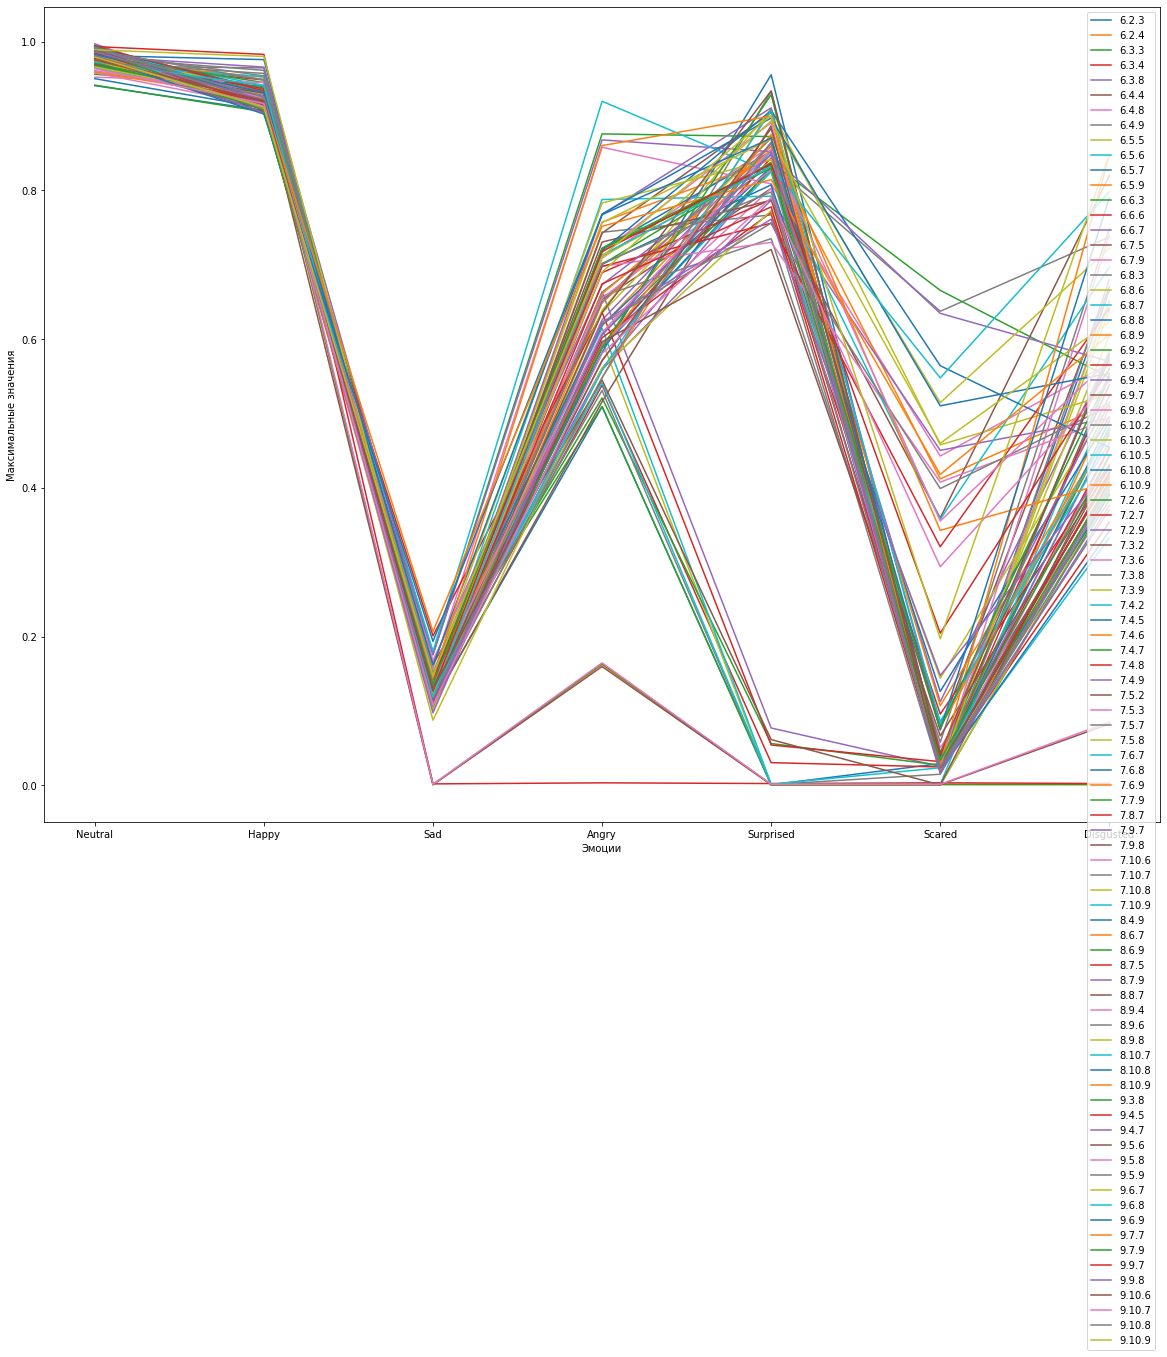

In [616]:
plt.figure(figsize=(20, 15))
for i, model_tuple in enumerate(models_3):
    values = model_tuple[2].predict(df_clear[fields]).max().values
    plt.plot(seven_fields, values, label=model_tuple[0])
    entry_dict = {'model': model_tuple[0]}
    entry_dict.update({metric: df_metrics_3.iloc[i][metric] for metric in metrics})
    entry_dict.update({emotion: values[j] for j, emotion in enumerate(seven_fields)})
    df_clear_metrics_3 = df_clear_metrics_3.append(entry_dict, ignore_index = True)
plt.xlabel("Эмоции")
plt.ylabel("Максимальные значения")
plt.legend()
plt.show()

In [638]:
df_clear_metrics_3[['model', 'Scared', 'Disgusted', 'Angry']].sort_values(['Scared', 'Disgusted', 'Angry'])

model    Scared  Disgusted     Angry
2   6.3.3  0.000329   0.391751  0.509649
8   6.5.5  0.000540   0.395305  0.597451
45  7.5.2  0.000579   0.442625  0.544969
35  7.3.2  0.000899   0.082659  0.159803
1   6.2.4  0.001027   0.000902  0.162366
..    ...       ...        ...       ...
79  9.6.8  0.547878   0.798223  0.713188
60  8.4.9  0.564304   0.454319  0.719054
64  8.7.9  0.634707   0.570129  0.673378
7   6.4.9  0.637511   0.737428  0.663294
52  7.7.9  0.665680   0.548341  0.700528

[89 rows x 4 columns]

In [618]:
df_clear_metrics.sort_values('Scared')[-20:]

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
8     9.8.9  0.960333  0.939076  0.125848  0.651967   0.786508  0.052887   
65    8.6.6  0.964064  0.915374  0.120928  0.653334   0.815995  0.055181   
32    7.3.9  0.986728  0.947289  0.106925  0.662623   0.730953  0.058751   
23    6.6.7  0.994951  0.920159  0.114332  0.633943   0.855644  0.059677   
58   7.10.9  0.993581  0.923687  0.187532  0.845664   0.764002  0.060451   
95    9.5.3  0.988857  0.921005  0.118003  0.660735   0.075102  0.060767   
49    7.8.7  0.989357  0.925310  0.112902  0.697790   0.749906  0.061434   
93    9.4.7  0.991911  0.916810  0.099230  0.569186   0.645487  0.061706   
35    7.4.6  0.972272  0.902327  0.112989  0.531319   0.802246  0.064977   
10    9.9.7  0.961022  0.921614  0.105901  0.663687   0.783989  0.092087   
62    8.4.9  0.992448  0.902187  0.130918  0.658275   0.770267  0.106013   
3     9.7.7  0.972760  0.930563  0.140573  0.714888   0.785160  0.109959   
70    8.7.5  0.989269  0.907586  0.125115  0.666672   0.722299  0.113952   
47    7.7.9  0.959390  0.905078  0.127081  0.703282   0.790263  0.160914   
100   9.6.7  0.983495  0.940344  0.102627  0.669330   0.802557  0.172595   
71    8.7.9  0.965326  0.961618  0.110757  0.655136   0.728304  0.259006   
82   8.10.8  0.982175  0.909494  0.123550  0.705157   0.809288  0.313259   
55   7.10.6  0.986265  0.925153  0.129795  0.592408   0.753001  0.362147   
101   9.6.8  0.967498  0.937298  0.124065  0.730126   0.824604  0.415297   
76    8.9.6  0.990963  0.921514  0.130379  0.627817   0.768453  0.447355   

     Disgusted      mean      norm      stat  
8     0.339319  0.051936  0.143346  0.354032  
65    0.418652  0.051754  0.142941  0.359557  
32    0.354804  0.051881  0.143465  0.354207  
23    0.395521  0.052292  0.144110  0.354441  
58    0.568246  0.050654  0.139693  0.371961  
95    0.000848  0.055570  0.157173  0.327781  
49    0.575871  0.052429  0.144682  0.367822  
93    0.388040  0.051523  0.142129  0.346822  
35    0.463123  0.052358  0.145384  0.351046  
10    0.348348  0.051586  0.143904  0.349005  
62    0.349670  0.051311  0.141488  0.351699  
3     0.470668  0.052485  0.144391  0.365122  
70    0.514801  0.051468  0.142045  0.356153  
47    0.515105  0.052448  0.144735  0.361276  
100   0.554978  0.050416  0.139019  0.354406  
71    0.452033  0.051657  0.142614  0.361524  
82    0.425297  0.050540  0.140494  0.366824  
55    0.532289  0.051851  0.143968  0.370717  
101   0.637826  0.050386  0.139357  0.392956  
76    0.498598  0.051978  0.143918  0.366416

In [626]:
df_clear_metrics_3.sort_values('Scared')[-15:]

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
67   8.9.6  0.988335  0.948533  0.118987  0.620507   0.755916  0.399119   
56  7.10.6  0.979905  0.913774  0.121981  0.697837   0.730168  0.407793   
21   6.8.9  0.972380  0.925309  0.121016  0.617931   0.854948  0.412071   
81   9.7.7  0.974837  0.921345  0.206876  0.751697   0.814595  0.418138   
16   6.7.9  0.979512  0.918672  0.157226  0.858075   0.808806  0.442803   
34   7.2.9  0.986951  0.926708  0.121225  0.559129   0.787002  0.450508   
48   7.5.8  0.959810  0.929861  0.115412  0.638822   0.908881  0.457874   
78   9.6.7  0.989164  0.980139  0.120916  0.756669   0.869052  0.460072   
70  8.10.8  0.983094  0.931322  0.161702  0.768312   0.897434  0.510337   
68   8.9.8  0.966155  0.920996  0.128990  0.690261   0.893331  0.514672   
79   9.6.8  0.972800  0.940797  0.119046  0.713188   0.832225  0.547878   
60   8.4.9  0.993527  0.921149  0.136777  0.719054   0.907445  0.564304   
64   8.7.9  0.980498  0.965853  0.166202  0.673378   0.847520  0.634707   
7    6.4.9  0.977316  0.949265  0.124773  0.663294   0.834890  0.637511   
52   7.7.9  0.968325  0.918173  0.106464  0.700528   0.837536  0.665680   

    Disgusted      mean      norm      stat  
67   0.509947  0.050478  0.140680  0.368122  
56   0.492939  0.051223  0.142862  0.371903  
21   0.513838  0.050909  0.140196  0.366024  
81   0.605869  0.050924  0.140776  0.385342  
16   0.567545  0.050244  0.138823  0.379608  
34   0.493745  0.052662  0.145057  0.358480  
48   0.525745  0.052066  0.143460  0.378043  
78   0.623365  0.048910  0.136033  0.372211  
70   0.554134  0.050046  0.138653  0.384979  
68   0.722269  0.050586  0.139335  0.374108  
79   0.798223  0.048986  0.136826  0.392062  
60   0.454319  0.050373  0.140058  0.380495  
64   0.570129  0.051612  0.142266  0.395200  
7    0.737428  0.051784  0.142879  0.384646  
52   0.548341  0.052188  0.144330  0.382034

In [628]:
df_clear.sort_values('Scared') # Scared - max == 0.55 (выше - нет смысла прыгать)

Neutral  Happy   Sad  Angry  Surprised  \
Index_                                                                    
00:00:01.300_Смолин Александр_1     0.97   0.00  0.02   0.03       0.01   
00:00:12.800_Aleksashina_1          0.05   0.95  0.00   0.00       0.00   
00:00:11.878_Fomin_6                0.03   0.95  0.00   0.00       0.00   
00:00:11.848_Fomin_6                0.04   0.95  0.00   0.00       0.00   
00:00:16.600_Смолин Александр_1     0.03   0.95  0.00   0.00       0.00   
...                                  ...    ...   ...    ...        ...   
00:00:03.400_Боим_7                 0.25   0.00  0.00   0.07       0.00   
00:00:03.300_Боим_7                 0.25   0.00  0.00   0.08       0.00   
00:00:03.000_Боим_7                 0.27   0.00  0.01   0.11       0.00   
00:00:03.100_Боим_7                 0.25   0.00  0.00   0.09       0.00   
00:00:03.200_Боим_7                 0.25   0.00  0.00   0.08       0.00   

                                 Scared  Disgusted  Valence  Arousal  
Index_                                                                
00:00:01.300_Смолин Александр_1    0.00       0.01    -0.03     0.23  
00:00:12.800_Aleksashina_1         0.00       0.00     0.94     0.75  
00:00:11.878_Fomin_6               0.00       0.00     0.95     0.83  
00:00:11.848_Fomin_6               0.00       0.00     0.95     0.82  
00:00:16.600_Смолин Александр_1    0.00       0.00     0.95     0.79  
...                                 ...        ...      ...      ...  
00:00:03.400_Боим_7                0.52       0.01    -0.52     0.85  
00:00:03.300_Боим_7                0.54       0.01    -0.54     0.83  
00:00:03.000_Боим_7                0.54       0.01    -0.54     0.73  
00:00:03.100_Боим_7                0.55       0.01    -0.55     0.77  
00:00:03.200_Боим_7                0.55       0.01    -0.55     0.80  

[530 rows x 9 columns]

In [629]:
df_clear_metrics.sort_values('Sad')[-15:]

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
74    8.9.3  0.970909  0.958090  0.147654  0.587524   0.008563  0.006265   
79   8.10.5  0.971317  0.906909  0.148008  0.535595   0.007729  0.009427   
54   7.10.4  0.951834  0.934896  0.150532  0.563158   0.123878  0.035806   
77    8.9.8  0.967273  0.922493  0.154884  0.700593   0.790319  0.026163   
17   9.10.9  0.980976  0.933078  0.155704  0.691760   0.891243  0.051588   
24    6.7.2  0.990157  0.934608  0.157898  0.525252   0.077484  0.023375   
83   8.10.9  0.973292  0.929226  0.158965  0.703314   0.802793  0.031261   
94    9.5.2  0.981100  0.915648  0.159202  0.472870   0.044703  0.001849   
2     6.2.6  0.978866  0.917742  0.161467  0.585235   0.072355  0.043326   
36    7.4.9  0.980619  0.911853  0.166144  0.791268   0.772844  0.020537   
41    7.6.7  0.956371  0.911821  0.167554  0.686317   0.727500  0.033499   
0     9.7.2  0.988509  0.893460  0.167613  0.589569   0.022283  0.008661   
75    8.9.4  0.993474  0.917996  0.172448  0.669409   0.774161  0.018572   
102   9.6.9  0.978979  0.916994  0.175512  0.796627   0.848060  0.029850   
58   7.10.9  0.993581  0.923687  0.187532  0.845664   0.764002  0.060451   

     Disgusted      mean      norm      stat  
74    0.402861  0.057895  0.159875  0.322888  
79    0.408667  0.054284  0.152386  0.319964  
54    0.415910  0.059251  0.160626  0.327974  
77    0.579727  0.051052  0.140405  0.363628  
17    0.628569  0.052117  0.142763  0.368249  
24    0.414912  0.058525  0.158504  0.324471  
83    0.619397  0.050880  0.140440  0.363934  
94    0.441755  0.056994  0.159360  0.320997  
2     0.361784  0.058391  0.158985  0.325186  
36    0.457293  0.051393  0.143263  0.368951  
41    0.496139  0.051865  0.144825  0.352762  
0     0.453447  0.058159  0.162023  0.329179  
75    0.422542  0.051154  0.141142  0.357687  
102   0.581666  0.051961  0.144260  0.381113  
58    0.568246  0.050654  0.139693  0.371961

In [630]:
df_clear_metrics_3.sort_values('Sad')[-15:]

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
36   7.3.6  0.958097  0.913502  0.150382  0.592949   0.802823  0.021940   
61   8.6.7  0.959206  0.921533  0.150755  0.589437   0.875162  0.342913   
18   6.8.6  0.981326  0.924132  0.151820  0.710353   0.837952  0.041712   
29  6.10.5  0.986414  0.941227  0.152047  0.614832   0.001604  0.023634   
16   6.7.9  0.979512  0.918672  0.157226  0.858075   0.808806  0.442803   
70  8.10.8  0.983094  0.931322  0.161702  0.768312   0.897434  0.510337   
45   7.5.2  0.973602  0.937290  0.163315  0.544969   0.061572  0.000579   
64   8.7.9  0.980498  0.965853  0.166202  0.673378   0.847520  0.634707   
66   8.9.4  0.989727  0.909021  0.167620  0.655035   0.827584  0.025148   
44   7.4.9  0.986046  0.904368  0.175182  0.867948   0.852066  0.028883   
42   7.4.7  0.981252  0.945009  0.176662  0.876048   0.872399  0.029781   
59  7.10.9  0.984734  0.917621  0.180461  0.919883   0.823787  0.357734   
80   9.6.9  0.979257  0.902661  0.193565  0.767366   0.870320  0.074587   
43   7.4.8  0.980115  0.905470  0.201019  0.636187   0.054267  0.031914   
81   9.7.7  0.974837  0.921345  0.206876  0.751697   0.814595  0.418138   

    Disgusted      mean      norm      stat  
36   0.452424  0.053484  0.148234  0.358267  
61   0.407620  0.052348  0.145328  0.363914  
18   0.605080  0.051079  0.140886  0.375428  
29   0.474621  0.055714  0.156914  0.333093  
16   0.567545  0.050244  0.138823  0.379608  
70   0.554134  0.050046  0.138653  0.384979  
45   0.442625  0.059436  0.160604  0.331190  
64   0.570129  0.051612  0.142266  0.395200  
66   0.739746  0.050814  0.140166  0.359924  
44   0.472212  0.050322  0.139935  0.373037  
42   0.580504  0.057652  0.155797  0.381270  
59   0.696844  0.048592  0.135877  0.392847  
80   0.790178  0.051060  0.141406  0.381711  
43   0.454482  0.064129  0.171892  0.331880  
81   0.605869  0.050924  0.140776  0.385342

In [631]:
df_clear.sort_values('Sad') # Sad - max == 0.95 (можно высоко прыгать, но многие путают с Angry)

Neutral  Happy   Sad  Angry  Surprised  \
Index_                                                                    
00:00:12.500_Aleksashina_1          0.10   0.89  0.00   0.01        0.0   
00:00:07.424_Керов Андрей_2         0.03   0.95  0.00   0.00        0.0   
00:00:11.818_Fomin_6                0.04   0.95  0.00   0.00        0.0   
00:00:21.100_Aleksashina_1          0.05   0.95  0.00   0.00        0.0   
00:00:17.600_Смолин Александр_1     0.03   0.95  0.00   0.00        0.0   
...                                  ...    ...   ...    ...        ...   
00:00:03.800_Zaharova_3             0.05   0.00  0.93   0.00        0.0   
00:00:03.900_Zaharova_3             0.05   0.00  0.93   0.00        0.0   
00:00:04.000_Zaharova_3             0.04   0.00  0.94   0.00        0.0   
00:00:04.100_Zaharova_3             0.04   0.00  0.95   0.00        0.0   
00:00:04.300_Zaharova_3             0.03   0.00  0.95   0.00        0.0   

                                 Scared  Disgusted  Valence  Arousal  
Index_                                                                
00:00:12.500_Aleksashina_1          0.0       0.00     0.88     0.64  
00:00:07.424_Керов Андрей_2         0.0       0.00     0.95     0.50  
00:00:11.818_Fomin_6                0.0       0.00     0.94     0.82  
00:00:21.100_Aleksashina_1          0.0       0.00     0.94     0.66  
00:00:17.600_Смолин Александр_1     0.0       0.00     0.95     0.90  
...                                 ...        ...      ...      ...  
00:00:03.800_Zaharova_3             0.0       0.08    -0.93     0.53  
00:00:03.900_Zaharova_3             0.0       0.09    -0.93     0.52  
00:00:04.000_Zaharova_3             0.0       0.10    -0.94     0.51  
00:00:04.100_Zaharova_3             0.0       0.12    -0.95     0.51  
00:00:04.300_Zaharova_3             0.0       0.12    -0.95     0.50  

[530 rows x 9 columns]

In [633]:
df_clear_metrics_3.sort_values('Disgusted')[-15:]

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
58  7.10.8  0.972669  0.924303  0.148860  0.783029   0.841808  0.021217   
26   6.9.8  0.982004  0.930398  0.116352  0.716654   0.891111  0.030387   
10   6.5.7  0.984753  0.911156  0.139337  0.721633   0.852614  0.028417   
5    6.4.4  0.983345  0.927069  0.118895  0.653584   0.802553  0.074946   
17   6.8.3  0.967426  0.964753  0.123570  0.743835   0.767111  0.016803   
59  7.10.9  0.984734  0.917621  0.180461  0.919883   0.823787  0.357734   
68   8.9.8  0.966155  0.920996  0.128990  0.690261   0.893331  0.514672   
7    6.4.9  0.977316  0.949265  0.124773  0.663294   0.834890  0.637511   
66   8.9.4  0.989727  0.909021  0.167620  0.655035   0.827584  0.025148   
37   7.3.8  0.985665  0.954042  0.118565  0.657616   0.735214  0.058003   
80   9.6.9  0.979257  0.902661  0.193565  0.767366   0.870320  0.074587   
79   9.6.8  0.972800  0.940797  0.119046  0.713188   0.832225  0.547878   
55   7.9.8  0.969692  0.930673  0.134378  0.730576   0.786754  0.359598   
71  8.10.9  0.986894  0.921225  0.144373  0.860307   0.899965  0.028123   
88  9.10.9  0.979276  0.912031  0.147807  0.711392   0.900872  0.197131   

    Disgusted      mean      norm      stat  
58   0.650325  0.049856  0.137711  0.365658  
26   0.651636  0.050587  0.140067  0.384268  
10   0.665359  0.050854  0.140023  0.371169  
5    0.670426  0.052875  0.145452  0.376944  
17   0.680086  0.050715  0.141767  0.367434  
59   0.696844  0.048592  0.135877  0.392847  
68   0.722269  0.050586  0.139335  0.374108  
7    0.737428  0.051784  0.142879  0.384646  
66   0.739746  0.050814  0.140166  0.359924  
37   0.748184  0.057610  0.157075  0.379862  
80   0.790178  0.051060  0.141406  0.381711  
79   0.798223  0.048986  0.136826  0.392062  
55   0.819982  0.049601  0.137344  0.382248  
71   0.847389  0.048564  0.135533  0.387505  
88   0.848853  0.050554  0.139299  0.380633

In [639]:
df_metrics_3

model  layer       N      mean      norm      stat
0    6.2.3_3  third   6.2.3  0.057991  0.163690  0.317581
1    6.2.4_3  third   6.2.4  0.070675  0.205286  0.336456
2    6.3.3_3  third   6.3.3  0.056950  0.157129  0.325086
3    6.3.4_3  third   6.3.4  0.061897  0.166982  0.317001
4    6.3.8_3  third   6.3.8  0.061931  0.167250  0.331612
..       ...    ...     ...       ...       ...       ...
84   9.9.8_3  third   9.9.8  0.050220  0.139108  0.351305
85  9.10.6_3  third  9.10.6  0.051412  0.140850  0.366087
86  9.10.7_3  third  9.10.7  0.051530  0.142812  0.361584
87  9.10.8_3  third  9.10.8  0.051058  0.141198  0.362247
88  9.10.9_3  third  9.10.9  0.050554  0.139299  0.380633

[89 rows x 6 columns]

In [643]:
df_metrics_3[47:]

model  layer       N      mean      norm      stat
47   7.5.7_3  third   7.5.7  0.052365  0.144314  0.351631
48   7.5.8_3  third   7.5.8  0.052066  0.143460  0.378043
49   7.6.7_3  third   7.6.7  0.050267  0.139475  0.370243
50   7.6.8_3  third   7.6.8  0.050021  0.138938  0.357559
51   7.6.9_3  third   7.6.9  0.050669  0.140510  0.364578
52   7.7.9_3  third   7.7.9  0.052188  0.144330  0.382034
53   7.8.7_3  third   7.8.7  0.050160  0.138654  0.370346
54   7.9.7_3  third   7.9.7  0.050514  0.138481  0.378410
55   7.9.8_3  third   7.9.8  0.049601  0.137344  0.382248
56  7.10.6_3  third  7.10.6  0.051223  0.142862  0.371903
57  7.10.7_3  third  7.10.7  0.049133  0.136578  0.368203
58  7.10.8_3  third  7.10.8  0.049856  0.137711  0.365658
59  7.10.9_3  third  7.10.9  0.048592  0.135877  0.392847
60   8.4.9_3  third   8.4.9  0.050373  0.140058  0.380495
61   8.6.7_3  third   8.6.7  0.052348  0.145328  0.363914
62   8.6.9_3  third   8.6.9  0.051731  0.142615  0.352686
63   8.7.5_3  third   8.7.5  0.050933  0.140793  0.371188
64   8.7.9_3  third   8.7.9  0.051612  0.142266  0.395200
65   8.8.7_3  third   8.8.7  0.052644  0.145276  0.354568
66   8.9.4_3  third   8.9.4  0.050814  0.140166  0.359924
67   8.9.6_3  third   8.9.6  0.050478  0.140680  0.368122
68   8.9.8_3  third   8.9.8  0.050586  0.139335  0.374108
69  8.10.7_3  third  8.10.7  0.051614  0.142243  0.358831
70  8.10.8_3  third  8.10.8  0.050046  0.138653  0.384979
71  8.10.9_3  third  8.10.9  0.048564  0.135533  0.387505
72   9.3.8_3  third   9.3.8  0.050702  0.139758  0.376273
73   9.4.5_3  third   9.4.5  0.051663  0.143452  0.364354
74   9.4.7_3  third   9.4.7  0.051130  0.142198  0.358528
75   9.5.6_3  third   9.5.6  0.052213  0.142434  0.361244
76   9.5.8_3  third   9.5.8  0.050332  0.139485  0.371586
77   9.5.9_3  third   9.5.9  0.050599  0.139125  0.347913
78   9.6.7_3  third   9.6.7  0.048910  0.136033  0.372211
79   9.6.8_3  third   9.6.8  0.048986  0.136826  0.392062
80   9.6.9_3  third   9.6.9  0.051060  0.141406  0.381711
81   9.7.7_3  third   9.7.7  0.050924  0.140776  0.385342
82   9.7.9_3  third   9.7.9  0.049791  0.137605  0.369672
83   9.9.7_3  third   9.9.7  0.050179  0.139339  0.370070
84   9.9.8_3  third   9.9.8  0.050220  0.139108  0.351305
85  9.10.6_3  third  9.10.6  0.051412  0.140850  0.366087
86  9.10.7_3  third  9.10.7  0.051530  0.142812  0.361584
87  9.10.8_3  third  9.10.8  0.051058  0.141198  0.362247
88  9.10.9_3  third  9.10.9  0.050554  0.139299  0.380633

In [640]:
x = []
y = []
for metric in metrics:
    x.append(df_metrics_3.index)
    y.append(df_metrics_3[metric])

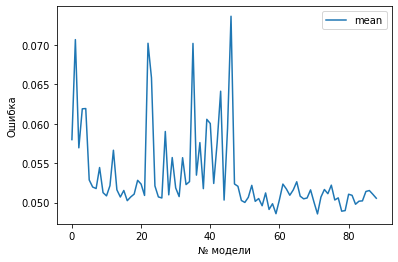

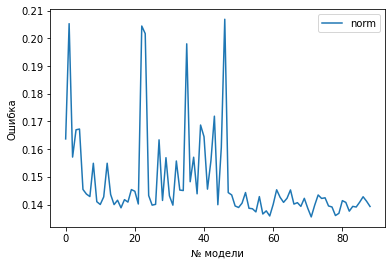

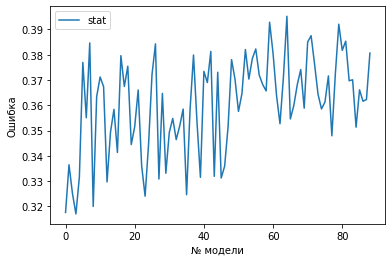

In [641]:
for i in range(len(metrics)):
    plt.plot(x[i], y[i], label=metrics[i])
    plt.xlabel("№ модели")
    plt.ylabel("Ошибка")
    plt.legend()
    plt.show()

In [645]:
df_clear_metrics_3

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
0    6.2.3  0.940918  0.907522  0.110906  0.509217   0.000814  0.029274   
1    6.2.4  0.976267  0.937370  0.000926  0.162366   0.001032  0.001027   
2    6.3.3  0.975195  0.916922  0.148223  0.509649   0.000347  0.000329   
3    6.3.4  0.971655  0.948502  0.119102  0.538280   0.030575  0.024771   
4    6.3.8  0.966079  0.930041  0.132509  0.663352   0.077177  0.025479   
..     ...       ...       ...       ...       ...        ...       ...   
84   9.9.8  0.986840  0.921336  0.110085  0.605725   0.849643  0.017232   
85  9.10.6  0.975486  0.920756  0.128996  0.570703   0.883444  0.043834   
86  9.10.7  0.963750  0.916768  0.107500  0.580742   0.790069  0.294009   
87  9.10.8  0.981117  0.911525  0.149787  0.701994   0.797973  0.024946   
88  9.10.9  0.979276  0.912031  0.147807  0.711392   0.900872  0.197131   

    Disgusted      mean      norm      stat  
0    0.391727  0.057991  0.163690  0.317581  
1    0.000902  0.070675  0.205286  0.336456  
2    0.391751  0.056950  0.157129  0.325086  
3    0.353922  0.061897  0.166982  0.317001  
4    0.419658  0.061931  0.167250  0.331612  
..        ...       ...       ...       ...  
84   0.376425  0.050220  0.139108  0.351305  
85   0.574545  0.051412  0.140850  0.366087  
86   0.543473  0.051530  0.142812  0.361584  
87   0.383453  0.051058  0.141198  0.362247  
88   0.848853  0.050554  0.139299  0.380633  

[89 rows x 11 columns]

In [654]:
def add_emotion_best(df_clear_metrics, n=15):
    best_models = set()
    for emotion in seven_fields:
        best_models = best_models.union(df_clear_metrics.sort_values(emotion)[-n:].index)
    print(len(best_models))
    return best_models

In [655]:
best_models_3 = add_emotion_best(df_clear_metrics_3, 10)

47


In [656]:
def add_from_df_metrics(best_models, df_metrics, metric, n=50):
    best_models = best_models.union(df_metrics.sort_values(metric)[:n].index)
    print(len(best_models))
    return best_models

In [657]:
best_models_3 = add_from_df_metrics(best_models_3, df_clear_metrics_3, 'mean', 40)

63


In [658]:
best_models_3 = add_from_df_metrics(best_models_3, df_clear_metrics_3, 'norm', 40)

64


In [659]:
best_models_3

{7,
 9,
 10,
 14,
 16,
 17,
 18,
 19,
 20,
 21,
 23,
 24,
 25,
 26,
 27,
 28,
 30,
 31,
 33,
 34,
 35,
 37,
 39,
 42,
 43,
 44,
 45,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 57,
 58,
 59,
 60,
 62,
 63,
 64,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 87,
 88}

In [660]:
df_metrics_3

model  layer       N      mean      norm      stat
0    6.2.3_3  third   6.2.3  0.057991  0.163690  0.317581
1    6.2.4_3  third   6.2.4  0.070675  0.205286  0.336456
2    6.3.3_3  third   6.3.3  0.056950  0.157129  0.325086
3    6.3.4_3  third   6.3.4  0.061897  0.166982  0.317001
4    6.3.8_3  third   6.3.8  0.061931  0.167250  0.331612
..       ...    ...     ...       ...       ...       ...
84   9.9.8_3  third   9.9.8  0.050220  0.139108  0.351305
85  9.10.6_3  third  9.10.6  0.051412  0.140850  0.366087
86  9.10.7_3  third  9.10.7  0.051530  0.142812  0.361584
87  9.10.8_3  third  9.10.8  0.051058  0.141198  0.362247
88  9.10.9_3  third  9.10.9  0.050554  0.139299  0.380633

[89 rows x 6 columns]

In [667]:
def get_best_models_next(best_models_cur, df_metrics_cur, df_metrics_first):
    best_models_cur_N = df_metrics_cur.iloc[list(best_models_cur)]['N']
    best_models_cur_N

    best_models_cur_correct_i_df =  df_metrics_first.query("N in @best_models_cur_N")
    best_models_cur_correct_i_df

    models_next = [models[i] for i in best_models_cur_correct_i_df.index]
    return models_next

In [666]:
best_models_3

{7,
 9,
 10,
 14,
 16,
 17,
 18,
 19,
 20,
 21,
 23,
 24,
 25,
 26,
 27,
 28,
 30,
 31,
 33,
 34,
 35,
 37,
 39,
 42,
 43,
 44,
 45,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 57,
 58,
 59,
 60,
 62,
 63,
 64,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 87,
 88}

In [669]:
models_4 = get_best_models_cur(best_models_3, df_metrics_3, df_metrics)
models_4

[('6.4.9',
  '6.4.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c6648340>),
 ('6.5.6',
  '6.5.6',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c639adf0>),
 ('6.5.7',
  '6.5.7',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c6461880>),
 ('6.6.7',
  '6.6.7',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c7732460>),
 ('6.7.9',
  '6.7.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c5d5af10>),
 ('6.8.3',
  '6.8.3',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c5a4fca0>),
 ('6.8.6',
  '6.8.6',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa99f7e83a0>),
 ('6.8.7',
  '6.8.7',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c5c14040>),
 ('6.8.8',
  '6.8.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa99f142f10>),
 ('6.8.9',
  '6.8.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa99f181340>),
 ('6.9.3',
  '6.9.3',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa99f6a7190>),
 ('6.9.4',
  '6.9.4',

In [670]:
len(models_4)

64

In [679]:
len(models_3) # Все, которые дообучали на 3 этапе

89

In [680]:
models_3

[('6.2.3',
  '6.2.3',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7faa00191be0>),
 ('6.2.4',
  '6.2.4',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7faa00142160>),
 ('6.3.3',
  '6.3.3',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9e049efa0>),
 ('6.3.4',
  '6.3.4',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c730e4c0>),
 ('6.3.8',
  '6.3.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c7732bb0>),
 ('6.4.4',
  '6.4.4',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c6cdb610>),
 ('6.4.8',
  '6.4.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c6dec940>),
 ('6.4.9',
  '6.4.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c6648340>),
 ('6.5.5',
  '6.5.5',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c6badd90>),
 ('6.5.6',
  '6.5.6',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c639adf0>),
 ('6.5.7',
  '6.5.7',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c6461880>),
 ('6.5.9',
  '6.5.9',

In [681]:
v

3

In [685]:
def save_models(models, v, layer='third', path_to_saved_models_dir='../saved_models'):
    path = os.path.join(path_to_saved_models_dir, layer, f'_{v}')
    save_name = f'model_{layer}_'
    for model_tuple in models:
        nn = model_tuple[2]
        cur_path = os.path.join(path, model_tuple[0] + f'_{v}')
        nn.model.save(cur_path)

In [686]:
save_models(models_3, v)

INFO:tensorflow:Assets written to: ../saved_models/third/_3/6.2.3_3/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_3/6.2.4_3/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_3/6.3.3_3/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_3/6.3.4_3/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_3/6.3.8_3/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_3/6.4.4_3/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_3/6.4.8_3/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_3/6.4.9_3/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_3/6.5.5_3/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_3/6.5.6_3/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_3/6.5.7_3/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_3/6.5.9_3/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_3/6.6.3_3/assets
INFO:tensorflow:Assets wr

In [687]:
name_db = 'df_metrics'
db_path = f'../model_metrics/{name_db}_third_second_half_{v}.db'
db_path

'../model_metrics/df_metrics_third_second_half_3.db'

In [688]:
df_metrics_3

model  layer       N      mean      norm      stat
0    6.2.3_3  third   6.2.3  0.057991  0.163690  0.317581
1    6.2.4_3  third   6.2.4  0.070675  0.205286  0.336456
2    6.3.3_3  third   6.3.3  0.056950  0.157129  0.325086
3    6.3.4_3  third   6.3.4  0.061897  0.166982  0.317001
4    6.3.8_3  third   6.3.8  0.061931  0.167250  0.331612
..       ...    ...     ...       ...       ...       ...
84   9.9.8_3  third   9.9.8  0.050220  0.139108  0.351305
85  9.10.6_3  third  9.10.6  0.051412  0.140850  0.366087
86  9.10.7_3  third  9.10.7  0.051530  0.142812  0.361584
87  9.10.8_3  third  9.10.8  0.051058  0.141198  0.362247
88  9.10.9_3  third  9.10.9  0.050554  0.139299  0.380633

[89 rows x 6 columns]

In [689]:
save_to_db(db_path, name_db, df_metrics_3)

In [690]:
connection = sqlite3.connect(db_path)
pd.read_sql(f'select * from {name_db}', con=connection)

model  layer       N                mean               norm  \
0    6.2.3_3  third   6.2.3  0.0579908660301726  0.163690201478321   
1    6.2.4_3  third   6.2.4  0.0706749609566735  0.205285572094156   
2    6.3.3_3  third   6.3.3  0.0569495490403223  0.157129316021987   
3    6.3.4_3  third   6.3.4  0.0618974245685399  0.166982330601745   
4    6.3.8_3  third   6.3.8  0.0619305869334178  0.167249680603747   
..       ...    ...     ...                 ...                ...   
84   9.9.8_3  third   9.9.8  0.0502204319307943  0.139108407701329   
85  9.10.6_3  third  9.10.6  0.0514119464997997  0.140849948271884   
86  9.10.7_3  third  9.10.7  0.0515303921751849  0.142811841663165   
87  9.10.8_3  third  9.10.8  0.0510576177329518  0.141198064033228   
88  9.10.9_3  third  9.10.9  0.0505536588771601  0.139298885283521   

                 stat  
0    0.31758064031601  
1   0.336456120014191  
2   0.325086116790771  
3    0.31700074672699  
4   0.331611663103104  
..                ...  
84  0.351305276155472  
85  0.366087406873703  
86  0.361584186553955  
87  0.362247228622437  
88    0.3806332051754  

[89 rows x 6 columns]

In [693]:
len(models_4)

64

In [694]:
test

Neutral     Happy       Sad     Angry  \
Index_                                                                   
00:00:00.000_Керов Андрей_3     0.987859  0.003336  0.008397  0.001824   
00:00:00.030_Керов Андрей_3     0.987882  0.003385  0.008362  0.001783   
00:00:00.060_Керов Андрей_3     0.987905  0.003434  0.008327  0.001741   
00:00:00.090_Керов Андрей_3     0.987929  0.003483  0.008292  0.001700   
00:00:00.121_Керов Андрей_3     0.988026  0.003506  0.008184  0.001645   
...                                  ...       ...       ...       ...   
00:01:51.700_Куликов Алексей_1  0.931563  0.000038  0.023971  0.067963   
00:01:51.800_Куликов Алексей_1  0.935643  0.000032  0.023777  0.062597   
00:01:51.900_Куликов Алексей_1  0.938411  0.000027  0.023437  0.059357   
00:01:52.000_Куликов Алексей_1  0.940782  0.000023  0.023035  0.056517   
00:01:52.100_Куликов Алексей_1  0.942106  0.000020  0.023117  0.054488   

                                Surprised    Scared  Disgusted   Valence  \
Index_                                                                     
00:00:00.000_Керов Андрей_3      0.007601  0.000069   0.000141 -0.005061   
00:00:00.030_Керов Андрей_3      0.007645  0.000081   0.000139 -0.004977   
00:00:00.060_Керов Андрей_3      0.007689  0.000092   0.000136 -0.004893   
00:00:00.090_Керов Андрей_3      0.007733  0.000103   0.000134 -0.004809   
00:00:00.121_Керов Андрей_3      0.007784  0.000113   0.000130 -0.004678   
...                                   ...       ...        ...       ...   
00:01:51.700_Куликов Алексей_1   0.026351  0.000250   0.000692 -0.067925   
00:01:51.800_Куликов Алексей_1   0.023741  0.000229   0.000799 -0.062565   
00:01:51.900_Куликов Алексей_1   0.021180  0.000213   0.000849 -0.059330   
00:01:52.000_Куликов Алексей_1   0.019016  0.000197   0.000878 -0.056494   
00:01:52.100_Куликов Алексей_1   0.017724  0.000184   0.000897 -0.054468   

                                 Arousal  
Index_                                    
00:00:00.000_Керов Андрей_3     0.247500  
00:00:00.030_Керов Андрей_3     0.247500  
00:00:00.060_Керов Андрей_3     0.247500  
00:00:00.090_Керов Андрей_3     0.247500  
00:00:00.121_Керов Андрей_3     0.247500  
...                                  ...  
00:01:51.700_Куликов Алексей_1  0.287489  
00:01:51.800_Куликов Алексей_1  0.287139  
00:01:51.900_Куликов Алексей_1  0.286695  
00:01:52.000_Куликов Алексей_1  0.286170  
00:01:52.100_Куликов Алексей_1  0.285693  

[25321 rows x 9 columns]

In [691]:
df_metrics_4 = pd.DataFrame(columns = ['model', 'layer', 'N'] + metrics)
df_metrics_4

Empty DataFrame
Columns: [model, layer, N, mean, norm, stat]
Index: []

In [ ]:
!!!СТОП

In [695]:
df_metrics_4 = refitting(models_4, test, df_metrics_4, v=v, layer='third')

refit 6.4.9
Epoch 1/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 2/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 3/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 4/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 5/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 6/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 7/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 8/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 9/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 10/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 11/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 12/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 13/20
2

225/225 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 6/20
225/225 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 7/20
225/225 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 8/20
225/225 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 9/20
225/225 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 10/20
225/225 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 11/20
225/225 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 12/20
225/225 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 13/20
225/225 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 14/20
225/225 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 15/20
225/225 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 16/20
225/225 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 17/20
225/225 [===========

236/236 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 10/20
236/236 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 11/20
236/236 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 12/20
236/236 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 13/20
236/236 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 14/20
236/236 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 15/20
236/236 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 16/20
236/236 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 17/20
236/236 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 18/20
236/236 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 19/20
236/236 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 20/20
236/236 [==============================] - 0s 2ms/step - loss: 0.0151
{'model': '7.2.7_3', 'layer'

Epoch 1/20
233/233 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 2/20
233/233 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 3/20
233/233 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 4/20
233/233 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 5/20
233/233 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 6/20
233/233 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 7/20
233/233 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 8/20
233/233 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 9/20
233/233 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 10/20
233/233 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 11/20
233/233 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 12/20
233/233 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 13/20
233/233 [====

Epoch 6/20
234/234 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 7/20
234/234 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 8/20
234/234 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 9/20
234/234 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 10/20
234/234 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 11/20
234/234 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 12/20
234/234 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 13/20
234/234 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 14/20
234/234 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 15/20
234/234 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 16/20
234/234 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 17/20
234/234 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 18/20
234/234 

231/231 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 11/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 12/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 13/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 14/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 15/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 16/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 17/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 18/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 19/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 20/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0146
{'model': '8.7.5_3', 'layer': 'third', 'N': '8.7.5', 'mean': 0.07527774734022297, 'norm': 0.21142884993684483,

236/236 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 15/20
236/236 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 16/20
236/236 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 17/20
236/236 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 18/20
236/236 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 19/20
236/236 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 20/20
236/236 [==============================] - 0s 2ms/step - loss: 0.0143
{'model': '9.4.7_3', 'layer': 'third', 'N': '9.4.7', 'mean': 0.0689786776186621, 'norm': 0.19564513239324618, 'stat': 0.35827154}
refit 9.5.6
Epoch 1/20
231/231 [==============================] - 1s 2ms/step - loss: 0.0154
Epoch 2/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 3/20
231/231 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 4/20
231/231 [==============================] -

226/226 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 19/20
226/226 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 20/20
226/226 [==============================] - 0s 2ms/step - loss: 0.0145
{'model': '9.9.7_3', 'layer': 'third', 'N': '9.9.7', 'mean': 0.08370159407669805, 'norm': 0.24000096501055238, 'stat': 0.3599072}
refit 9.9.8
Epoch 1/20
228/228 [==============================] - 1s 2ms/step - loss: 0.0155
Epoch 2/20
228/228 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 3/20
228/228 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 4/20
228/228 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 5/20
228/228 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 6/20
228/228 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 7/20
228/228 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 8/20
228/228 [==============================] - 0s 

In [698]:
df_metrics_4.sort_values('mean')[:10]

model  layer       N      mean      norm      stat
2    6.5.7_3  third   6.5.7  0.066316  0.187070  0.359807
48  8.10.9_3  third  8.10.9  0.067530  0.187015  0.376462
51   9.5.6_3  third   9.5.6  0.068765  0.186944  0.359328
50   9.4.7_3  third   9.4.7  0.068979  0.195645  0.358272
38  7.10.9_3  third  7.10.9  0.069402  0.204104  0.373463
7    6.8.7_3  third   6.8.7  0.070135  0.190721  0.333455
32   7.7.9_3  third   7.7.9  0.071293  0.202627  0.353641
44   8.9.6_3  third   8.9.6  0.071895  0.202325  0.353501
6    6.8.6_3  third   6.8.6  0.072582  0.197785  0.366287
40   8.6.9_3  third   8.6.9  0.072910  0.197812  0.343938

In [713]:
df_clear_metrics_4 = pd.DataFrame(columns = ['model'] + list(seven_fields) + metrics)
df_clear_metrics_4

Empty DataFrame
Columns: [model, Neutral, Happy, Sad, Angry, Surprised, Scared, Disgusted, mean, norm, stat]
Index: []

In [714]:
models_4

[('6.4.9',
  '6.4.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c6648340>),
 ('6.5.6',
  '6.5.6',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c639adf0>),
 ('6.5.7',
  '6.5.7',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c6461880>),
 ('6.6.7',
  '6.6.7',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c7732460>),
 ('6.7.9',
  '6.7.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c5d5af10>),
 ('6.8.3',
  '6.8.3',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c5a4fca0>),
 ('6.8.6',
  '6.8.6',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa99f7e83a0>),
 ('6.8.7',
  '6.8.7',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c5c14040>),
 ('6.8.8',
  '6.8.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa99f142f10>),
 ('6.8.9',
  '6.8.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa99f181340>),
 ('6.9.3',
  '6.9.3',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa99f6a7190>),
 ('6.9.4',
  '6.9.4',

In [871]:
def plot_emotions(models, df_clear, df_metrics, df_clear_metrics, scale=False, figsize=(20, 15)):
    plt.figure(figsize=figsize)
    for i, model_tuple in enumerate(models):
        values = model_tuple[2].predict(df_clear[fields]).max().values
        if scale:
            values /= df_clear.max().values[:-2]
        plt.plot(seven_fields, values, label=model_tuple[0])
        entry_dict = {'model': model_tuple[0]}
        entry_dict.update({metric: df_metrics.iloc[i][metric] for metric in metrics})
        entry_dict.update({emotion: values[j] for j, emotion in enumerate(seven_fields)})
        df_clear_metrics = df_clear_metrics.append(entry_dict, ignore_index = True)
    plt.xlabel("Эмоции")
    plt.ylabel("Максимальные значения")
    plt.legend()
    plt.show()
    return df_clear_metrics

In [716]:
df_metrics_4

model  layer       N      mean      norm      stat
0    6.4.9_3  third   6.4.9  0.076582  0.211930  0.359524
1    6.5.6_3  third   6.5.6  0.077405  0.209759  0.351476
2    6.5.7_3  third   6.5.7  0.066316  0.187070  0.359807
3    6.6.7_3  third   6.6.7  0.078447  0.219662  0.348400
4    6.7.9_3  third   6.7.9  0.073664  0.207983  0.366484
..       ...    ...     ...       ...       ...       ...
59   9.9.7_3  third   9.9.7  0.083702  0.240001  0.359907
60   9.9.8_3  third   9.9.8  0.089502  0.250470  0.349301
61  9.10.6_3  third  9.10.6  0.085292  0.233404  0.362093
62  9.10.8_3  third  9.10.8  0.082049  0.224656  0.367845
63  9.10.9_3  third  9.10.9  0.077841  0.213765  0.373919

[64 rows x 6 columns]

In [717]:
kwargs = {
    'models': models_4, 
    'df_clear': df_clear, 
    'df_metrics':df_metrics_4, 
    'df_clear_metrics': df_clear_metrics_4
}

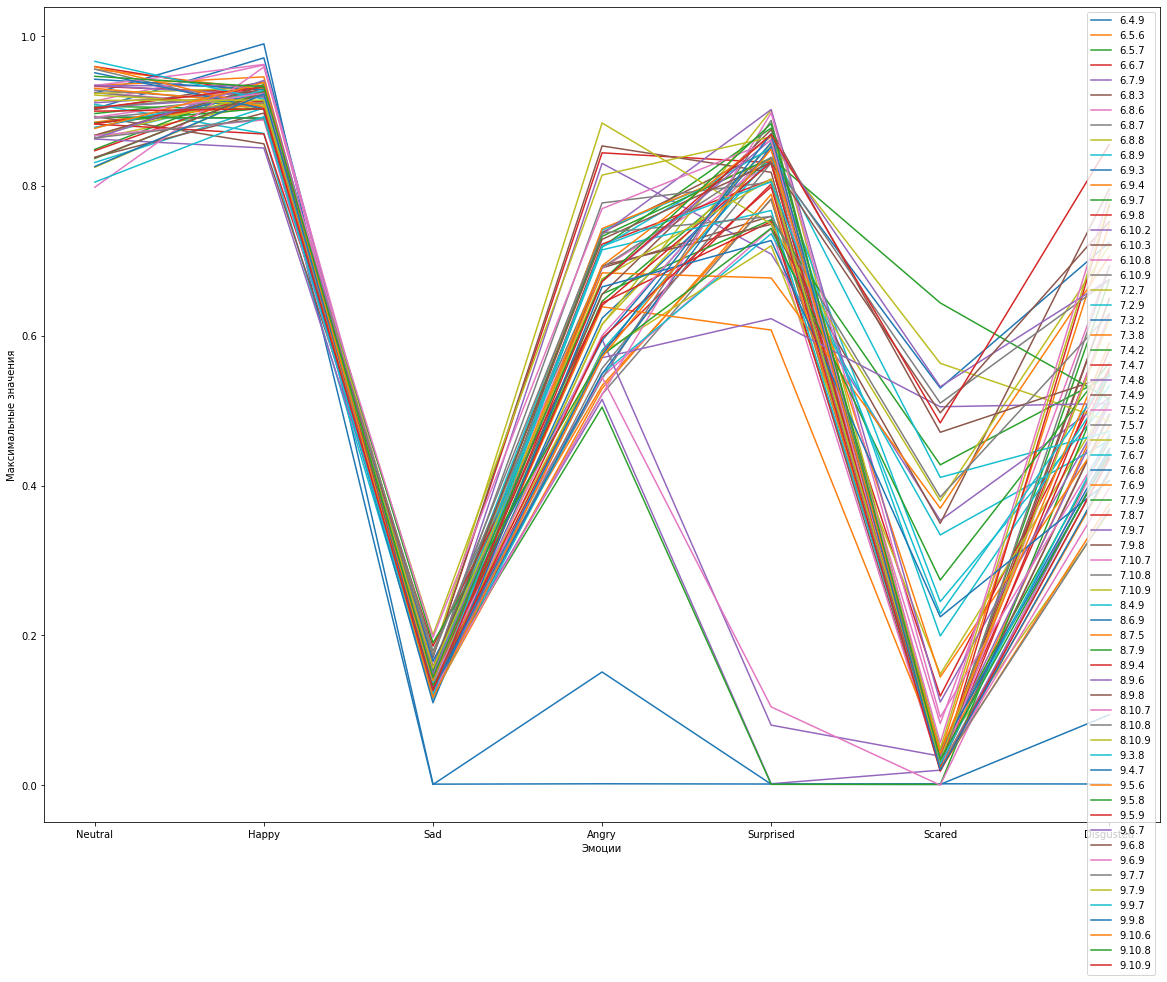

In [718]:
df_clear_metrics_4 = plot_emotions(**kwargs)

In [719]:
df_clear_metrics_4.sort_values('Scared')[-20:]

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
59   9.9.7  0.805282  0.892809  0.120970  0.719508   0.805771  0.229035   
9    6.8.9  0.867205  0.922487  0.115006  0.580531   0.838265  0.245081   
52   9.5.8  0.836870  0.926391  0.190166  0.573807   0.743650  0.273887   
19   7.2.9  0.909168  0.870279  0.118490  0.549634   0.736279  0.334147   
35   7.9.8  0.838563  0.897514  0.121848  0.693695   0.748906  0.349584   
4    6.7.9  0.911211  0.925691  0.150868  0.830328   0.709164  0.353583   
41   8.7.5  0.930557  0.909980  0.145616  0.684123   0.677305  0.369794   
38  7.10.9  0.867627  0.923422  0.174058  0.884234   0.749434  0.379620   
57   9.7.7  0.864348  0.890029  0.173142  0.737486   0.759290  0.384734   
39   8.4.9  0.878172  0.927723  0.146139  0.718477   0.851034  0.410992   
32   7.7.9  0.884282  0.903820  0.125581  0.655886   0.755090  0.427754   
45   8.9.8  0.867853  0.933630  0.140057  0.655517   0.875167  0.471238   
63  9.10.9  0.900018  0.903151  0.126509  0.672342   0.869141  0.483750   
55   9.6.8  0.837643  0.925176  0.156304  0.728875   0.831387  0.497204   
44   8.9.6  0.934634  0.921249  0.120204  0.570748   0.622929  0.505299   
47  8.10.8  0.890632  0.911402  0.179050  0.691173   0.838333  0.510137   
0    6.4.9  0.903345  0.971215  0.125178  0.623595   0.833843  0.530291   
54   9.6.7  0.863479  0.941181  0.147792  0.672681   0.862158  0.532106   
28   7.5.8  0.825080  0.922981  0.124730  0.615620   0.856447  0.563312   
42   8.7.9  0.891754  0.890956  0.152327  0.732837   0.837649  0.643996   

    Disgusted      mean      norm      stat  
59   0.548292  0.083702  0.240001  0.359907  
9    0.515197  0.077658  0.211942  0.345757  
52   0.564116  0.073696  0.206634  0.352498  
19   0.460237  0.078221  0.221388  0.349181  
35   0.796224  0.083964  0.237292  0.374613  
4    0.517479  0.073664  0.207983  0.366484  
41   0.706379  0.075278  0.211429  0.363949  
38   0.720336  0.069402  0.204104  0.373463  
57   0.629651  0.078051  0.221096  0.381737  
39   0.472266  0.081306  0.232060  0.363941  
32   0.546938  0.071293  0.202627  0.353641  
45   0.546423  0.076232  0.208868  0.359426  
63   0.855730  0.077841  0.213765  0.373919  
55   0.752573  0.080153  0.219278  0.381022  
44   0.509545  0.071895  0.202325  0.353501  
47   0.674782  0.074032  0.211781  0.366472  
0    0.724575  0.076582  0.211930  0.359524  
54   0.675346  0.085286  0.240012  0.364793  
28   0.486245  0.082067  0.229410  0.368249  
42   0.515613  0.080325  0.225277  0.383791

In [720]:
df_clear_metrics_4.sort_values('Sad')[-20:]

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
34   7.9.7  0.862902  0.850815  0.148869  0.735507   0.902238  0.110983   
4    6.7.9  0.911211  0.925691  0.150868  0.830328   0.709164  0.353583   
42   8.7.9  0.891754  0.890956  0.152327  0.732837   0.837649  0.643996   
29   7.6.7  0.831455  0.904305  0.155667  0.741189   0.835799  0.199239   
37  7.10.8  0.904890  0.922522  0.156193  0.777478   0.805236  0.024519   
55   9.6.8  0.837643  0.925176  0.156304  0.728875   0.831387  0.497204   
58   9.7.9  0.914414  0.914712  0.156313  0.676061   0.809656  0.033647   
26   7.5.2  0.934319  0.962460  0.156883  0.544665   0.104506  0.000017   
6    6.8.6  0.925473  0.906183  0.158979  0.690441   0.829827  0.082303   
24   7.4.8  0.904780  0.919093  0.164734  0.595468   0.080122  0.038733   
30   7.6.8  0.878130  0.923868  0.165870  0.593890   0.858274  0.045776   
23   7.4.7  0.847215  0.927255  0.171072  0.844392   0.831343  0.024542   
25   7.4.9  0.893023  0.856433  0.171084  0.853609   0.818411  0.025363   
57   9.7.7  0.864348  0.890029  0.173142  0.737486   0.759290  0.384734   
38  7.10.9  0.867627  0.923422  0.174058  0.884234   0.749434  0.379620   
47  8.10.8  0.890632  0.911402  0.179050  0.691173   0.838333  0.510137   
43   8.9.4  0.882874  0.869503  0.185734  0.640677   0.831590  0.023114   
52   9.5.8  0.836870  0.926391  0.190166  0.573807   0.743650  0.273887   
56   9.6.9  0.891759  0.923977  0.197049  0.769870   0.860236  0.056668   
48  8.10.9  0.921506  0.908389  0.200474  0.814645   0.865591  0.048742   

    Disgusted      mean      norm      stat  
34   0.510918  0.081465  0.225438  0.368115  
4    0.517479  0.073664  0.207983  0.366484  
42   0.515613  0.080325  0.225277  0.383791  
29   0.533745  0.080996  0.221252  0.367246  
37   0.692533  0.076475  0.208851  0.363830  
55   0.752573  0.080153  0.219278  0.381022  
58   0.621889  0.077140  0.209936  0.369090  
26   0.466586  0.077957  0.212241  0.321593  
6    0.693604  0.072582  0.197785  0.366287  
24   0.509793  0.088964  0.232545  0.324931  
30   0.449569  0.079458  0.216954  0.358209  
23   0.581407  0.078819  0.216963  0.364229  
25   0.494177  0.075926  0.207582  0.366498  
57   0.629651  0.078051  0.221096  0.381737  
38   0.720336  0.069402  0.204104  0.373463  
47   0.674782  0.074032  0.211781  0.366472  
43   0.774364  0.079428  0.218378  0.358635  
52   0.564116  0.073696  0.206634  0.352498  
56   0.789716  0.083313  0.232272  0.368549  
48   0.777816  0.067530  0.187015  0.376462

In [721]:
df_clear_metrics_4.sort_values('Angry')[-20:]

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
51   9.5.6  0.959515  0.905364  0.139665  0.693731   0.866154  0.022299   
49   9.3.8  0.966510  0.915860  0.137746  0.714880   0.767436  0.028103   
39   8.4.9  0.878172  0.927723  0.146139  0.718477   0.851034  0.410992   
12   6.9.7  0.896877  0.919641  0.128271  0.718728   0.877540  0.048510   
59   9.9.7  0.805282  0.892809  0.120970  0.719508   0.805771  0.229035   
13   6.9.8  0.933166  0.924377  0.139454  0.722392   0.808779  0.036611   
55   9.6.8  0.837643  0.925176  0.156304  0.728875   0.831387  0.497204   
42   8.7.9  0.891754  0.890956  0.152327  0.732837   0.837649  0.643996   
34   7.9.7  0.862902  0.850815  0.148869  0.735507   0.902238  0.110983   
57   9.7.7  0.864348  0.890029  0.173142  0.737486   0.759290  0.384734   
15  6.10.3  0.867328  0.930710  0.128369  0.738078   0.848926  0.034245   
29   7.6.7  0.831455  0.904305  0.155667  0.741189   0.835799  0.199239   
31   7.6.9  0.883868  0.909758  0.138352  0.743224   0.835166  0.144374   
56   9.6.9  0.891759  0.923977  0.197049  0.769870   0.860236  0.056668   
37  7.10.8  0.904890  0.922522  0.156193  0.777478   0.805236  0.024519   
48  8.10.9  0.921506  0.908389  0.200474  0.814645   0.865591  0.048742   
4    6.7.9  0.911211  0.925691  0.150868  0.830328   0.709164  0.353583   
23   7.4.7  0.847215  0.927255  0.171072  0.844392   0.831343  0.024542   
25   7.4.9  0.893023  0.856433  0.171084  0.853609   0.818411  0.025363   
38  7.10.9  0.867627  0.923422  0.174058  0.884234   0.749434  0.379620   

    Disgusted      mean      norm      stat  
51   0.416227  0.068765  0.186944  0.359328  
49   0.468648  0.076493  0.214622  0.369850  
39   0.472266  0.081306  0.232060  0.363941  
12   0.460305  0.082872  0.227464  0.365193  
59   0.548292  0.083702  0.240001  0.359907  
13   0.627511  0.078871  0.214645  0.372594  
55   0.752573  0.080153  0.219278  0.381022  
42   0.515613  0.080325  0.225277  0.383791  
34   0.510918  0.081465  0.225438  0.368115  
57   0.629651  0.078051  0.221096  0.381737  
15   0.649715  0.090057  0.253249  0.370985  
29   0.533745  0.080996  0.221252  0.367246  
31   0.478596  0.076210  0.211388  0.361910  
56   0.789716  0.083313  0.232272  0.368549  
37   0.692533  0.076475  0.208851  0.363830  
48   0.777816  0.067530  0.187015  0.376462  
4    0.517479  0.073664  0.207983  0.366484  
23   0.581407  0.078819  0.216963  0.364229  
25   0.494177  0.075926  0.207582  0.366498  
38   0.720336  0.069402  0.204104  0.373463

In [722]:
x = []
y = []
for metric in metrics:
    x.append(df_metrics_4.index)
    y.append(df_metrics_4[metric])

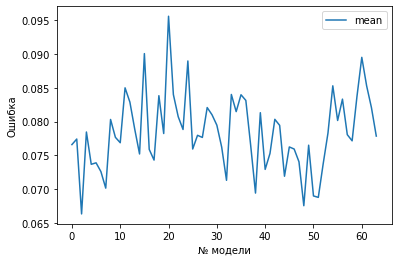

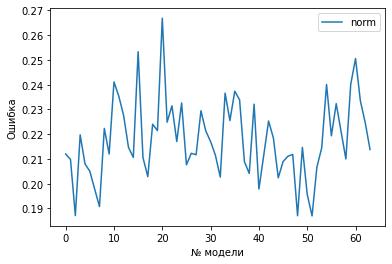

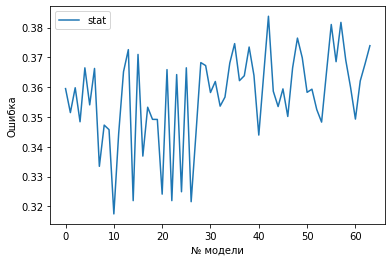

In [723]:
for i in range(len(metrics)):
    plt.plot(x[i], y[i], label=metrics[i])
    plt.xlabel("№ модели")
    plt.ylabel("Ошибка")
    plt.legend()
    plt.show()

In [730]:
best_models_4 = add_emotion_best(df_clear_metrics_4, 10)

49


In [731]:
best_models_4 = add_from_df_metrics(best_models_4, df_clear_metrics_4, 'mean', 30)

56


In [732]:
best_models_4 = add_from_df_metrics(best_models_4, df_clear_metrics_4, 'norm', 30)

56


In [733]:
best_models_4

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 14,
 15,
 16,
 17,
 20,
 21,
 22,
 23,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 34,
 35,
 36,
 37,
 38,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 54,
 55,
 56,
 57,
 58,
 60,
 61,
 62,
 63}

In [734]:
models_5 = get_best_models_cur(best_models_4, df_metrics_4, df_metrics)
models_5

[('6.4.9',
  '6.4.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c6648340>),
 ('6.5.6',
  '6.5.6',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c639adf0>),
 ('6.5.7',
  '6.5.7',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c6461880>),
 ('6.6.7',
  '6.6.7',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c7732460>),
 ('6.7.9',
  '6.7.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c5d5af10>),
 ('6.8.3',
  '6.8.3',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c5a4fca0>),
 ('6.8.6',
  '6.8.6',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa99f7e83a0>),
 ('6.8.7',
  '6.8.7',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c5c14040>),
 ('6.8.8',
  '6.8.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa99f142f10>),
 ('6.8.9',
  '6.8.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa99f181340>),
 ('6.9.3',
  '6.9.3',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa99f6a7190>),
 ('6.9.4',
  '6.9.4',

In [735]:
len(models_5)

56

In [736]:
models_4

[('6.4.9',
  '6.4.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c6648340>),
 ('6.5.6',
  '6.5.6',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c639adf0>),
 ('6.5.7',
  '6.5.7',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c6461880>),
 ('6.6.7',
  '6.6.7',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c7732460>),
 ('6.7.9',
  '6.7.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c5d5af10>),
 ('6.8.3',
  '6.8.3',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c5a4fca0>),
 ('6.8.6',
  '6.8.6',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa99f7e83a0>),
 ('6.8.7',
  '6.8.7',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c5c14040>),
 ('6.8.8',
  '6.8.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa99f142f10>),
 ('6.8.9',
  '6.8.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa99f181340>),
 ('6.9.3',
  '6.9.3',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa99f6a7190>),
 ('6.9.4',
  '6.9.4',

In [737]:
v = 4
save_models(models_4, v)

INFO:tensorflow:Assets written to: ../saved_models/third/_4/6.4.9_4/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_4/6.5.6_4/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_4/6.5.7_4/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_4/6.6.7_4/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_4/6.7.9_4/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_4/6.8.3_4/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_4/6.8.6_4/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_4/6.8.7_4/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_4/6.8.8_4/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_4/6.8.9_4/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_4/6.9.3_4/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_4/6.9.4_4/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_4/6.9.7_4/assets
INFO:tensorflow:Assets wr

In [738]:
name_db = 'df_metrics'
db_path = f'../model_metrics/{name_db}_third_second_half_{v}.db'
db_path

'../model_metrics/df_metrics_third_second_half_4.db'

In [739]:
df_metrics_4

model  layer       N      mean      norm      stat
0    6.4.9_3  third   6.4.9  0.076582  0.211930  0.359524
1    6.5.6_3  third   6.5.6  0.077405  0.209759  0.351476
2    6.5.7_3  third   6.5.7  0.066316  0.187070  0.359807
3    6.6.7_3  third   6.6.7  0.078447  0.219662  0.348400
4    6.7.9_3  third   6.7.9  0.073664  0.207983  0.366484
..       ...    ...     ...       ...       ...       ...
59   9.9.7_3  third   9.9.7  0.083702  0.240001  0.359907
60   9.9.8_3  third   9.9.8  0.089502  0.250470  0.349301
61  9.10.6_3  third  9.10.6  0.085292  0.233404  0.362093
62  9.10.8_3  third  9.10.8  0.082049  0.224656  0.367845
63  9.10.9_3  third  9.10.9  0.077841  0.213765  0.373919

[64 rows x 6 columns]

In [740]:
save_to_db(db_path, name_db, df_metrics_4)

In [741]:
connection = sqlite3.connect(db_path)
pd.read_sql(f'select * from {name_db}', con=connection)

model  layer       N                mean               norm  \
0    6.4.9_3  third   6.4.9  0.0765823908073903   0.21192994520295   
1    6.5.6_3  third   6.5.6  0.0774050257197583  0.209758568072702   
2    6.5.7_3  third   6.5.7    0.06631600803716  0.187069867655497   
3    6.6.7_3  third   6.6.7  0.0784467724594775  0.219661552196314   
4    6.7.9_3  third   6.7.9  0.0736635462271576  0.207983457819894   
..       ...    ...     ...                 ...                ...   
59   9.9.7_3  third   9.9.7  0.0837015940766981  0.240000965010552   
60   9.9.8_3  third   9.9.8  0.0895018509216658  0.250469939852326   
61  9.10.6_3  third  9.10.6  0.0852922085335013    0.2334039502805   
62  9.10.8_3  third  9.10.8  0.0820485171293449  0.224656096292585   
63  9.10.9_3  third  9.10.9  0.0778407975963627  0.213765458186896   

                 stat  
0    0.35952427983284  
1   0.351476043462753  
2   0.359807014465332  
3   0.348400235176086  
4   0.366484194993973  
..                ...  
59  0.359907209873199  
60  0.349300801753998  
61  0.362093180418015  
62  0.367844998836517  
63   0.37391859292984  

[64 rows x 6 columns]

In [743]:
df_train, df_test = nn.train_test_split(full_df_list, percent_df_list)
df_train

Neutral  Happy   Sad  Angry  Surprised  Scared  \
Index_                                                                          
00:00:52.400_Бушунов Виктор_1     0.84   0.00  0.09   0.17       0.01    0.01   
00:00:19.700_Бушунов Виктор_1     0.30   0.48  0.00   0.04       0.00    0.00   
00:00:07.700_Боим_9               0.97   0.01  0.00   0.00       0.05    0.00   
00:00:06.424_Керов Андрей_9       0.64   0.31  0.00   0.00       0.03    0.00   
00:00:02.600_Provotorov_1         0.85   0.01  0.02   0.14       0.02    0.01   
...                                ...    ...   ...    ...        ...     ...   
00:00:07.700_Nasyrov_7            0.01   0.00  0.00   0.01       0.00    0.00   
00:00:08.200_Nasyrov_7            0.01   0.00  0.00   0.01       0.00    0.00   
00:00:07.300_Nasyrov_7            0.01   0.00  0.00   0.00       0.00    0.00   
00:00:08.900_Nasyrov_7            0.00   0.00  0.00   0.01       0.00    0.00   
00:00:09.100_Nasyrov_7            0.00   0.00  0.00   0.01       0.00    0.00   

                               Disgusted  Valence  Arousal  
Index_                                                      
00:00:52.400_Бушунов Виктор_1       0.01    -0.25     0.25  
00:00:19.700_Бушунов Виктор_1       0.00     0.44     0.47  
00:00:07.700_Боим_9                 0.00     0.00     0.34  
00:00:06.424_Керов Андрей_9         0.00     0.31     0.42  
00:00:02.600_Provotorov_1           0.00    -0.15     0.30  
...                                  ...      ...      ...  
00:00:07.700_Nasyrov_7              0.99    -0.99     0.63  
00:00:08.200_Nasyrov_7              0.99    -0.99     0.63  
00:00:07.300_Nasyrov_7              0.99    -0.99     0.62  
00:00:08.900_Nasyrov_7              1.00    -1.00     0.63  
00:00:09.100_Nasyrov_7              1.00    -1.00     0.63  

[18315 rows x 9 columns]

In [744]:
df_metrics_5 = pd.DataFrame(columns = ['model', 'layer', 'N'] + metrics)
df_metrics_5

Empty DataFrame
Columns: [model, layer, N, mean, norm, stat]
Index: []

In [746]:
len(models_5)

56

In [748]:
df_metrics_5

model  layer       N      mean      norm      stat
0    6.4.9_5  third   6.4.9  0.049450  0.137629  0.381123
1    6.5.6_5  third   6.5.6  0.051510  0.141843  0.371421
2    6.5.7_5  third   6.5.7  0.049111  0.135486  0.382344
3    6.6.7_5  third   6.6.7  0.050849  0.140907  0.370734
4    6.7.9_5  third   6.7.9  0.049933  0.138603  0.364481
5    6.8.3_5  third   6.8.3  0.051051  0.142206  0.365659
6    6.8.6_5  third   6.8.6  0.051246  0.141795  0.381513
7    6.8.7_5  third   6.8.7  0.052489  0.143851  0.344287
8    6.8.8_5  third   6.8.8  0.050469  0.139653  0.363543
9    6.8.9_5  third   6.8.9  0.050292  0.139357  0.361522
10   6.9.3_5  third   6.9.3  0.065587  0.201726  0.326225
11   6.9.4_5  third   6.9.4  0.052156  0.143821  0.346410
12   6.9.7_5  third   6.9.7  0.051452  0.140447  0.382450
13  6.10.2_5  third  6.10.2  0.057277  0.157787  0.332565
14  6.10.3_5  third  6.10.3  0.050447  0.140181  0.378022
15  6.10.8_5  third  6.10.8  0.052331  0.144626  0.356305
16  6.10.9_5  third  6.10.9  0.049765  0.136561  0.368659
17   7.3.2_5  third   7.3.2  0.070527  0.198938  0.326932
18   7.3.8_5  third   7.3.8  0.056873  0.155117  0.389408
19   7.4.2_5  third   7.4.2  0.059993  0.167392  0.335167
20   7.4.7_5  third   7.4.7  0.056037  0.152016  0.381733
21   7.4.9_5  third   7.4.9  0.051079  0.141636  0.367352
22   7.5.2_5  third   7.5.2  0.056935  0.156191  0.325946
23   7.5.7_5  third   7.5.7  0.051820  0.142156  0.351554
24   7.5.8_5  third   7.5.8  0.050452  0.140177  0.383982
25   7.6.7_5  third   7.6.7  0.050676  0.141191  0.381497
26   7.6.8_5  third   7.6.8  0.050828  0.140131  0.374835
27   7.6.9_5  third   7.6.9  0.049226  0.136545  0.379857
28   7.7.9_5  third   7.7.9  0.049886  0.139715  0.380577
29   7.9.7_5  third   7.9.7  0.048923  0.134905  0.389270
30   7.9.8_5  third   7.9.8  0.049126  0.136223  0.396314
31  7.10.7_5  third  7.10.7  0.048074  0.133891  0.388789
32  7.10.8_5  third  7.10.8  0.050757  0.140607  0.377900
33  7.10.9_5  third  7.10.9  0.047961  0.133694  0.387689
34   8.6.9_5  third   8.6.9  0.051792  0.141854  0.357052
35   8.7.5_5  third   8.7.5  0.050604  0.139826  0.377756
36   8.7.9_5  third   8.7.9  0.050180  0.139627  0.393288
37   8.9.4_5  third   8.9.4  0.049812  0.136702  0.371655
38   8.9.6_5  third   8.9.6  0.051521  0.142742  0.364396
39   8.9.8_5  third   8.9.8  0.049130  0.135990  0.377404
40  8.10.7_5  third  8.10.7  0.050531  0.139305  0.381599
41  8.10.8_5  third  8.10.8  0.049758  0.137691  0.388609
42  8.10.9_5  third  8.10.9  0.049014  0.136154  0.398614
43   9.3.8_5  third   9.3.8  0.050103  0.138624  0.376185
44   9.4.7_5  third   9.4.7  0.050387  0.139227  0.369624
45   9.5.6_5  third   9.5.6  0.052217  0.143856  0.376082
46   9.5.8_5  third   9.5.8  0.051370  0.142515  0.371640
47   9.6.7_5  third   9.6.7  0.048896  0.135041  0.376554
48   9.6.8_5  third   9.6.8  0.048610  0.134730  0.397050
49   9.6.9_5  third   9.6.9  0.050331  0.139999  0.398399
50   9.7.7_5  third   9.7.7  0.051775  0.143636  0.401213
51   9.7.9_5  third   9.7.9  0.049886  0.137917  0.384555
52   9.9.8_5  third   9.9.8  0.051009  0.141115  0.356233
53  9.10.6_5  third  9.10.6  0.050438  0.140467  0.369728
54  9.10.8_5  third  9.10.8  0.050168  0.137995  0.364478
55  9.10.9_5  third  9.10.9  0.050811  0.139837  0.394669

In [ ]:
!!!СТОП

In [747]:
v = 5
df_metrics_5 = refitting(models_5, test, df_metrics_5, df_train=df_train, v=v, layer='third', type_='split')

refit 6.4.9
Epoch 1/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0054
Epoch 2/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0052
Epoch 3/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0052
Epoch 4/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0052
Epoch 5/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0052
Epoch 6/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0051
Epoch 7/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0051
Epoch 8/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0051
Epoch 9/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0051
Epoch 10/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0051
Epoch 11/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0051
Epoch 12/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0051
Epoch 13/20
9

916/916 [==============================] - 2s 2ms/step - loss: 0.0054
Epoch 6/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0054
Epoch 7/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0054
Epoch 8/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0054
Epoch 9/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0054
Epoch 10/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 11/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 12/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 13/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 14/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 15/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 16/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 17/20
916/916 [===========

916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 10/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 11/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 12/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 13/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 14/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 15/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 16/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 17/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 18/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 19/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 20/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
{'model': '7.3.8_5', 'layer'

Epoch 1/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0057
Epoch 2/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0055
Epoch 3/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 4/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 5/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 6/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 7/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 8/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 9/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 10/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 11/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 12/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 13/20
916/916 [====

916/916 [==============================] - 2s 2ms/step - loss: 0.0051
Epoch 6/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0051
Epoch 7/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0051
Epoch 8/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0051
Epoch 9/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0051
Epoch 10/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0051
Epoch 11/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0051
Epoch 12/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0051
Epoch 13/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0051
Epoch 14/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0051
Epoch 15/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0050
Epoch 16/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0050
Epoch 17/20
916/916 [===========

916/916 [==============================] - 2s 2ms/step - loss: 0.0049
Epoch 10/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0049
Epoch 11/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0049
Epoch 12/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0049
Epoch 13/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0049
Epoch 14/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0049
Epoch 15/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0049
Epoch 16/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0049
Epoch 17/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0049
Epoch 18/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0049
Epoch 19/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0049
Epoch 20/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0049
{'model': '8.10.8_5', 'layer

Epoch 1/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 2/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 3/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 4/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 5/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 6/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 7/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 8/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 9/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 10/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 11/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0053
Epoch 12/20
916/916 [==============================] - 1s 2ms/step - loss: 0.0053
Epoch 13/20
916/916 [====

916/916 [==============================] - 2s 2ms/step - loss: 0.0050
Epoch 6/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0049
Epoch 7/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0050
Epoch 8/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0049
Epoch 9/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0049
Epoch 10/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0049
Epoch 11/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0049
Epoch 12/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0049
Epoch 13/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0049
Epoch 14/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0049
Epoch 15/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0049
Epoch 16/20
916/916 [==============================] - 2s 2ms/step - loss: 0.0049
Epoch 17/20
916/916 [===========

In [750]:
df_metrics_5.sort_values('mean')

model  layer       N      mean      norm      stat
33  7.10.9_5  third  7.10.9  0.047961  0.133694  0.387689
31  7.10.7_5  third  7.10.7  0.048074  0.133891  0.388789
48   9.6.8_5  third   9.6.8  0.048610  0.134730  0.397050
47   9.6.7_5  third   9.6.7  0.048896  0.135041  0.376554
29   7.9.7_5  third   7.9.7  0.048923  0.134905  0.389270
42  8.10.9_5  third  8.10.9  0.049014  0.136154  0.398614
2    6.5.7_5  third   6.5.7  0.049111  0.135486  0.382344
30   7.9.8_5  third   7.9.8  0.049126  0.136223  0.396314
39   8.9.8_5  third   8.9.8  0.049130  0.135990  0.377404
27   7.6.9_5  third   7.6.9  0.049226  0.136545  0.379857
0    6.4.9_5  third   6.4.9  0.049450  0.137629  0.381123
41  8.10.8_5  third  8.10.8  0.049758  0.137691  0.388609
16  6.10.9_5  third  6.10.9  0.049765  0.136561  0.368659
37   8.9.4_5  third   8.9.4  0.049812  0.136702  0.371655
28   7.7.9_5  third   7.7.9  0.049886  0.139715  0.380577
51   9.7.9_5  third   9.7.9  0.049886  0.137917  0.384555
4    6.7.9_5  third   6.7.9  0.049933  0.138603  0.364481
43   9.3.8_5  third   9.3.8  0.050103  0.138624  0.376185
54  9.10.8_5  third  9.10.8  0.050168  0.137995  0.364478
36   8.7.9_5  third   8.7.9  0.050180  0.139627  0.393288
9    6.8.9_5  third   6.8.9  0.050292  0.139357  0.361522
49   9.6.9_5  third   9.6.9  0.050331  0.139999  0.398399
44   9.4.7_5  third   9.4.7  0.050387  0.139227  0.369624
53  9.10.6_5  third  9.10.6  0.050438  0.140467  0.369728
14  6.10.3_5  third  6.10.3  0.050447  0.140181  0.378022
24   7.5.8_5  third   7.5.8  0.050452  0.140177  0.383982
8    6.8.8_5  third   6.8.8  0.050469  0.139653  0.363543
40  8.10.7_5  third  8.10.7  0.050531  0.139305  0.381599
35   8.7.5_5  third   8.7.5  0.050604  0.139826  0.377756
25   7.6.7_5  third   7.6.7  0.050676  0.141191  0.381497
32  7.10.8_5  third  7.10.8  0.050757  0.140607  0.377900
55  9.10.9_5  third  9.10.9  0.050811  0.139837  0.394669
26   7.6.8_5  third   7.6.8  0.050828  0.140131  0.374835
3    6.6.7_5  third   6.6.7  0.050849  0.140907  0.370734
52   9.9.8_5  third   9.9.8  0.051009  0.141115  0.356233
5    6.8.3_5  third   6.8.3  0.051051  0.142206  0.365659
21   7.4.9_5  third   7.4.9  0.051079  0.141636  0.367352
6    6.8.6_5  third   6.8.6  0.051246  0.141795  0.381513
46   9.5.8_5  third   9.5.8  0.051370  0.142515  0.371640
12   6.9.7_5  third   6.9.7  0.051452  0.140447  0.382450
1    6.5.6_5  third   6.5.6  0.051510  0.141843  0.371421
38   8.9.6_5  third   8.9.6  0.051521  0.142742  0.364396
50   9.7.7_5  third   9.7.7  0.051775  0.143636  0.401213
34   8.6.9_5  third   8.6.9  0.051792  0.141854  0.357052
23   7.5.7_5  third   7.5.7  0.051820  0.142156  0.351554
11   6.9.4_5  third   6.9.4  0.052156  0.143821  0.346410
45   9.5.6_5  third   9.5.6  0.052217  0.143856  0.376082
15  6.10.8_5  third  6.10.8  0.052331  0.144626  0.356305
7    6.8.7_5  third   6.8.7  0.052489  0.143851  0.344287
20   7.4.7_5  third   7.4.7  0.056037  0.152016  0.381733
18   7.3.8_5  third   7.3.8  0.056873  0.155117  0.389408
22   7.5.2_5  third   7.5.2  0.056935  0.156191  0.325946
13  6.10.2_5  third  6.10.2  0.057277  0.157787  0.332565
19   7.4.2_5  third   7.4.2  0.059993  0.167392  0.335167
10   6.9.3_5  third   6.9.3  0.065587  0.201726  0.326225
17   7.3.2_5  third   7.3.2  0.070527  0.198938  0.326932

In [752]:
df_clear_metrics_5 = pd.DataFrame(columns = ['model'] + list(seven_fields) + metrics)
df_clear_metrics_5

Empty DataFrame
Columns: [model, Neutral, Happy, Sad, Angry, Surprised, Scared, Disgusted, mean, norm, stat]
Index: []

In [754]:
len(models_5)

56

In [755]:
kwargs = {
    'models': models_5, 
    'df_clear': df_clear, 
    'df_metrics':df_metrics_5, 
    'df_clear_metrics': df_clear_metrics_5
}

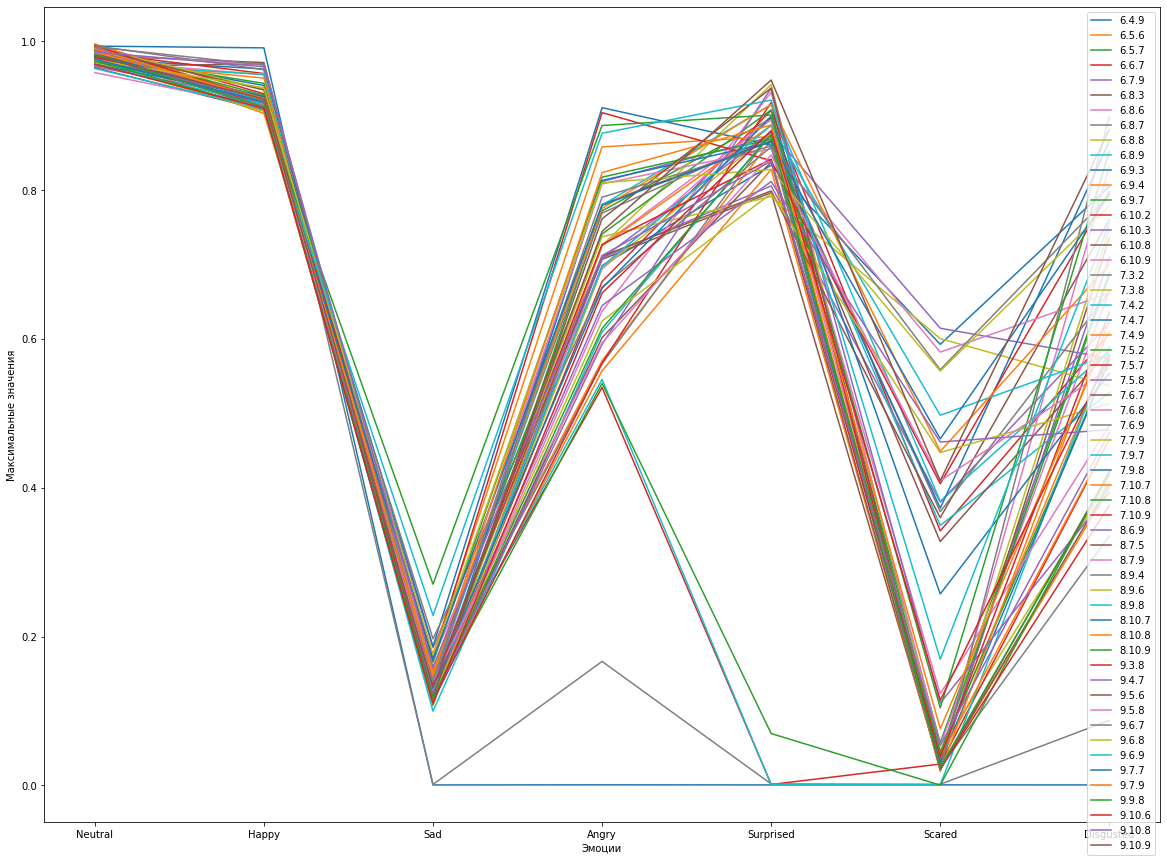

In [756]:
df_clear_metrics_5 = plot_emotions(**kwargs)

In [839]:
v = 5
save_models(models_5, v)

INFO:tensorflow:Assets written to: ../saved_models/third/_5/6.4.9_5/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_5/6.5.6_5/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_5/6.5.7_5/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_5/6.6.7_5/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_5/6.7.9_5/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_5/6.8.3_5/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_5/6.8.6_5/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_5/6.8.7_5/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_5/6.8.8_5/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_5/6.8.9_5/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_5/6.9.3_5/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_5/6.9.4_5/assets
INFO:tensorflow:Assets written to: ../saved_models/third/_5/6.9.7_5/assets
INFO:tensorflow:Assets wr

In [840]:
name_db = 'df_metrics'
db_path = f'../model_metrics/{name_db}_third_second_half_{v}.db'
db_path

'../model_metrics/df_metrics_third_second_half_5.db'

In [842]:
save_to_db(db_path, name_db, df_metrics_5)

In [843]:
connection = sqlite3.connect(db_path)
pd.read_sql(f'select * from {name_db}', con=connection)

model  layer       N                mean               norm  \
0    6.4.9_5  third   6.4.9  0.0494504799446535  0.137629388765958   
1    6.5.6_5  third   6.5.6  0.0515096264411386  0.141842796662108   
2    6.5.7_5  third   6.5.7  0.0491111979328282  0.135485903431272   
3    6.6.7_5  third   6.6.7  0.0508488970370444  0.140906979135811   
4    6.7.9_5  third   6.7.9  0.0499333810568726    0.1386029743104   
5    6.8.3_5  third   6.8.3  0.0510513588117852  0.142206442351032   
6    6.8.6_5  third   6.8.6  0.0512464872906876  0.141794848749299   
7    6.8.7_5  third   6.8.7  0.0524887619307379  0.143851221543678   
8    6.8.8_5  third   6.8.8  0.0504693617875056  0.139653121999641   
9    6.8.9_5  third   6.8.9  0.0502923489184584  0.139357303321629   
10   6.9.3_5  third   6.9.3  0.0655871467500155  0.201726339179986   
11   6.9.4_5  third   6.9.4  0.0521557278208517  0.143821349527523   
12   6.9.7_5  third   6.9.7  0.0514519462952829  0.140446982750639   
13  6.10.2_5  third  6.10.2  0.0572769688538452  0.157786743788139   
14  6.10.3_5  third  6.10.3  0.0504474390345817  0.140180946125471   
15  6.10.8_5  third  6.10.8  0.0523307407001247  0.144625751151687   
16  6.10.9_5  third  6.10.9  0.0497654370119805  0.136560985972037   
17   7.3.2_5  third   7.3.2  0.0705269066172488  0.198937560084009   
18   7.3.8_5  third   7.3.8  0.0568729103137148  0.155117271250495   
19   7.4.2_5  third   7.4.2  0.0599934398131562  0.167391717945769   
20   7.4.7_5  third   7.4.7  0.0560372892418489  0.152015821907965   
21   7.4.9_5  third   7.4.9  0.0510793311205549  0.141635671638799   
22   7.5.2_5  third   7.5.2  0.0569349430543958  0.156191113995424   
23   7.5.7_5  third   7.5.7  0.0518201978559581  0.142156094161555   
24   7.5.8_5  third   7.5.8  0.0504518191774755  0.140177231551667   
25   7.6.7_5  third   7.6.7  0.0506759061860003  0.141190928693663   
26   7.6.8_5  third   7.6.8  0.0508276795146744  0.140130768434607   
27   7.6.9_5  third   7.6.9  0.0492255664940732   0.13654489279504   
28   7.7.9_5  third   7.7.9  0.0498859598117317  0.139714677503636   
29   7.9.7_5  third   7.9.7  0.0489226975192105  0.134904547836412   
30   7.9.8_5  third   7.9.8  0.0491262887647605  0.136223265197346   
31  7.10.7_5  third  7.10.7  0.0480737762398658  0.133891037548023   
32  7.10.8_5  third  7.10.8  0.0507573217476883  0.140606867066054   
33  7.10.9_5  third  7.10.9  0.0479605922455669  0.133694380883089   
34   8.6.9_5  third   8.6.9  0.0517915699031577  0.141853793533916   
35   8.7.5_5  third   8.7.5  0.0506038239099251  0.139825742552651   
36   8.7.9_5  third   8.7.9  0.0501799197412368  0.139626856628002   
37   8.9.4_5  third   8.9.4  0.0498116075748109  0.136702128404106   
38   8.9.6_5  third   8.9.6  0.0515207778992733  0.142741705097213   
39   8.9.8_5  third   8.9.8   0.049129655138733  0.135989550766549   
40  8.10.7_5  third  8.10.7  0.0505306892976327    0.1393051878062   
41  8.10.8_5  third  8.10.8  0.0497584948987148  0.137691122840095   
42  8.10.9_5  third  8.10.9  0.0490138210202429  0.136153503565942   
43   9.3.8_5  third   9.3.8  0.0501030716493086  0.138624302211609   
44   9.4.7_5  third   9.4.7  0.0503871638606718  0.139227082910054   
45   9.5.6_5  third   9.5.6  0.0522174520231654  0.143856138516381   
46   9.5.8_5  third   9.5.8  0.0513696491954025  0.142514946833118   
47   9.6.7_5  third   9.6.7  0.0488958932485458  0.135040981148275   
48   9.6.8_5  third   9.6.8  0.0486101095857758  0.134729850533907   
49   9.6.9_5  third   9.6.9   0.050331450646908  0.139999430158597   
50   9.7.7_5  third   9.7.7  0.0517750190235942  0.143636372349026   
51   9.7.9_5  third   9.7.9  0.0498860149078687   0.13791741656347   
52   9.9.8_5  third   9.9.8  0.0510094361611198  0.141114822793619   
53  9.10.6_5  third  9.10.6  0.0504379900470812  0.140466827407221   
54  9.10.8_5  third  9.10.8  0.0501682007928907  0.137994971125665   
55  9.10.9_5  third  9.10.9  0.0508106933756284  0.139836773586279   

                

In [763]:
df_clear_metrics_5.sort_values('Scared')[:30]

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
22   7.5.2  0.980328  0.943603  0.118039  0.540325   0.069801  0.000480   
10   6.9.3  0.993690  0.991315  0.000749  0.000891   0.000784  0.000830   
19   7.4.2  0.969856  0.955518  0.128327  0.545842   0.001242  0.001044   
17   7.3.2  0.994058  0.961935  0.001382  0.166758   0.002098  0.001664   
31  7.10.7  0.972965  0.950651  0.109970  0.725097   0.887074  0.019001   
45   9.5.6  0.989093  0.934661  0.118276  0.761621   0.937131  0.021266   
23   7.5.7  0.980451  0.915222  0.113232  0.567718   0.918057  0.021555   
11   6.9.4  0.995776  0.922440  0.120349  0.557308   0.827909  0.021560   
15  6.10.8  0.980847  0.971543  0.115238  0.601879   0.837865  0.021833   
37   8.9.4  0.989572  0.921715  0.197066  0.669767   0.858211  0.021926   
7    6.8.7  0.995672  0.916746  0.136176  0.566661   0.876846  0.024171   
5    6.8.3  0.966716  0.969698  0.135454  0.707050   0.796686  0.024196   
52   9.9.8  0.982676  0.911977  0.116430  0.614334   0.874411  0.024677   
13  6.10.2  0.984879  0.956805  0.133937  0.534869   0.001368  0.028833   
14  6.10.3  0.990493  0.919607  0.134264  0.811639   0.871758  0.030886   
20   7.4.7  0.982191  0.940767  0.186979  0.910947   0.860514  0.031379   
6    6.8.6  0.982448  0.913310  0.138284  0.725881   0.894602  0.034964   
21   7.4.9  0.983669  0.903251  0.176447  0.858168   0.872142  0.037770   
18   7.3.8  0.967580  0.956048  0.110085  0.694454   0.877377  0.037954   
43   9.3.8  0.994127  0.921123  0.134526  0.727178   0.841721  0.038041   
1    6.5.6  0.996685  0.915919  0.137871  0.570930   0.866996  0.040274   
32  7.10.8  0.972800  0.925028  0.165647  0.817559   0.868462  0.043196   
12   6.9.7  0.988133  0.927556  0.155337  0.741035   0.907995  0.043427   
8    6.8.8  0.979088  0.924158  0.123143  0.725796   0.941781  0.047313   
54  9.10.8  0.985703  0.965860  0.159343  0.712156   0.839275  0.053473   
16  6.10.9  0.974575  0.955025  0.118078  0.637564   0.931524  0.053931   
2    6.5.7  0.982593  0.911232  0.107780  0.772183   0.896445  0.057479   
51   9.7.9  0.989904  0.921475  0.147283  0.823686   0.887676  0.076057   
42  8.10.9  0.974229  0.909216  0.270570  0.886977   0.901099  0.104270   
34   8.6.9  0.975642  0.923753  0.115119  0.592875   0.937071  0.110717   

    Disgusted      mean      norm      stat  
22   0.422310  0.056935  0.156191  0.325946  
10   0.000786  0.065587  0.201726  0.326225  
19   0.589617  0.059993  0.167392  0.335167  
17   0.087526  0.070527  0.198938  0.326932  
31   0.625048  0.048074  0.133891  0.388789  
45   0.421093  0.052217  0.143856  0.376082  
23   0.376635  0.051820  0.142156  0.351554  
11   0.399334  0.052156  0.143821  0.346410  
15   0.404720  0.052331  0.144626  0.356305  
37   0.898853  0.049812  0.136702  0.371655  
7    0.335316  0.052489  0.143851  0.344287  
5    0.736200  0.051051  0.142206  0.365659  
52   0.417683  0.051009  0.141115  0.356233  
13   0.465171  0.057277  0.157787  0.332565  
14   0.710244  0.050447  0.140181  0.378022  
20   0.571623  0.056037  0.152016  0.381733  
6    0.832477  0.051246  0.141795  0.381513  
21   0.465835  0.051079  0.141636  0.367352  
18   0.748109  0.056873  0.155117  0.389408  
43   0.635819  0.050103  0.138624  0.376185  
1    0.585564  0.051510  0.141843  0.371421  
32   0.686451  0.050757  0.140607  0.377900  
12   0.571702  0.051452  0.140447  0.382450  
8    0.409235  0.050469  0.139653  0.363543  
54   0.474510  0.050168  0.137995  0.364478  
16   0.664611  0.049765  0.136561  0.368659  
2    0.688436  0.049111  0.135486  0.382344  
51   0.611858  0.049886  0.137917  0.384555  
42   0.852168  0.049014  0.136154  0.398614  
34   0.393811  0.051792  0.141854  0.357052

In [761]:
bad_models = set()

In [764]:
df_clear_metrics_5.sort_values('Scared')[:28].index

Int64Index([22, 10, 19, 17, 31, 45, 23, 11, 15, 37,  7,  5, 52, 13, 14, 20,  6,
            21, 18, 43,  1, 32, 12,  8, 54, 16,  2, 51],
           dtype='int64')

In [767]:
bad_models = bad_models.union(df_clear_metrics_5.sort_values('Scared')[:28].index)
len(bad_models)

28

In [768]:
df_clear_metrics_5.sort_values('Sad')[:30]

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
10   6.9.3  0.993690  0.991315  0.000749  0.000891   0.000784  0.000830   
17   7.3.2  0.994058  0.961935  0.001382  0.166758   0.002098  0.001664   
9    6.8.9  0.971519  0.926949  0.099836  0.609372   0.875895  0.349512   
2    6.5.7  0.982593  0.911232  0.107780  0.772183   0.896445  0.057479   
31  7.10.7  0.972965  0.950651  0.109970  0.725097   0.887074  0.019001   
18   7.3.8  0.967580  0.956048  0.110085  0.694454   0.877377  0.037954   
53  9.10.6  0.969327  0.910184  0.110170  0.661756   0.880104  0.114582   
0    6.4.9  0.976621  0.962817  0.112274  0.698618   0.833612  0.592869   
23   7.5.7  0.980451  0.915222  0.113232  0.567718   0.918057  0.021555   
34   8.6.9  0.975642  0.923753  0.115119  0.592875   0.937071  0.110717   
15  6.10.8  0.980847  0.971543  0.115238  0.601879   0.837865  0.021833   
52   9.9.8  0.982676  0.911977  0.116430  0.614334   0.874411  0.024677   
24   7.5.8  0.966201  0.921879  0.117330  0.708359   0.878390  0.614544   
3    6.6.7  0.994954  0.929664  0.117869  0.677276   0.907227  0.342197   
22   7.5.2  0.980328  0.943603  0.118039  0.540325   0.069801  0.000480   
30   7.9.8  0.969142  0.925012  0.118063  0.813106   0.864223  0.372780   
16  6.10.9  0.974575  0.955025  0.118078  0.637564   0.931524  0.053931   
45   9.5.6  0.989093  0.934661  0.118276  0.761621   0.937131  0.021266   
11   6.9.4  0.995776  0.922440  0.120349  0.557308   0.827909  0.021560   
38   8.9.6  0.991535  0.935798  0.120671  0.624252   0.795454  0.447392   
39   8.9.8  0.968928  0.915590  0.122892  0.697624   0.887144  0.497585   
8    6.8.8  0.979088  0.924158  0.123143  0.725796   0.941781  0.047313   
44   9.4.7  0.991903  0.911526  0.124078  0.644973   0.811685  0.461616   
19   7.4.2  0.969856  0.955518  0.128327  0.545842   0.001242  0.001044   
55  9.10.9  0.980488  0.922544  0.131123  0.744579   0.948096  0.409543   
28   7.7.9  0.971786  0.906099  0.132017  0.737482   0.791620  0.600543   
40  8.10.7  0.982022  0.925121  0.132264  0.668292   0.899037  0.257428   
13  6.10.2  0.984879  0.956805  0.133937  0.534869   0.001368  0.028833   
14  6.10.3  0.990493  0.919607  0.134264  0.811639   0.871758  0.030886   
43   9.3.8  0.994127  0.921123  0.134526  0.727178   0.841721  0.038041   

    Disgusted      mean      norm      stat  
10   0.000786  0.065587  0.201726  0.326225  
17   0.087526  0.070527  0.198938  0.326932  
9    0.528221  0.050292  0.139357  0.361522  
2    0.688436  0.049111  0.135486  0.382344  
31   0.625048  0.048074  0.133891  0.388789  
18   0.748109  0.056873  0.155117  0.389408  
53   0.577426  0.050438  0.140467  0.369728  
0    0.805153  0.049450  0.137629  0.381123  
23   0.376635  0.051820  0.142156  0.351554  
34   0.393811  0.051792  0.141854  0.357052  
15   0.404720  0.052331  0.144626  0.356305  
52   0.417683  0.051009  0.141115  0.356233  
24   0.574078  0.050452  0.140177  0.383982  
3    0.607342  0.050849  0.140907  0.370734  
22   0.422310  0.056935  0.156191  0.325946  
30   0.865483  0.049126  0.136223  0.396314  
16   0.664611  0.049765  0.136561  0.368659  
45   0.421093  0.052217  0.143856  0.376082  
11   0.399334  0.052156  0.143821  0.346410  
38   0.513187  0.051521  0.142742  0.364396  
39   0.579031  0.049130  0.135990  0.377404  
8    0.409235  0.050469  0.139653  0.363543  
44   0.478098  0.050387  0.139227  0.369624  
19   0.589617  0.059993  0.167392  0.335167  
55   0.881461  0.050811  0.139837  0.394669  
28   0.537314  0.049886  0.139715  0.380577  
40   0.554267  0.050531  0.139305  0.381599  
13   0.465171  0.057277  0.157787  0.332565  
14   0.710244  0.050447  0.140181  0.378022  
43   0.635819  0.050103  0.138624  0.376185

In [769]:
bad_models = bad_models.union(df_clear_metrics_5.sort_values('Sad')[:2].index)
len(bad_models)

28

In [771]:
df_clear_metrics_5.sort_values('Surprised')[:30]

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
10   6.9.3  0.993690  0.991315  0.000749  0.000891   0.000784  0.000830   
19   7.4.2  0.969856  0.955518  0.128327  0.545842   0.001242  0.001044   
13  6.10.2  0.984879  0.956805  0.133937  0.534869   0.001368  0.028833   
17   7.3.2  0.994058  0.961935  0.001382  0.166758   0.002098  0.001664   
22   7.5.2  0.980328  0.943603  0.118039  0.540325   0.069801  0.000480   
28   7.7.9  0.971786  0.906099  0.132017  0.737482   0.791620  0.600543   
38   8.9.6  0.991535  0.935798  0.120671  0.624252   0.795454  0.447392   
5    6.8.3  0.966716  0.969698  0.135454  0.707050   0.796686  0.024196   
35   8.7.5  0.984176  0.922825  0.134700  0.711327   0.799054  0.359897   
4    6.7.9  0.976276  0.917102  0.185231  0.708941   0.805806  0.380871   
44   9.4.7  0.991903  0.911526  0.124078  0.644973   0.811685  0.461616   
11   6.9.4  0.995776  0.922440  0.120349  0.557308   0.827909  0.021560   
48   9.6.8  0.975201  0.937720  0.174152  0.809957   0.827936  0.556891   
0    6.4.9  0.976621  0.962817  0.112274  0.698618   0.833612  0.592869   
15  6.10.8  0.980847  0.971543  0.115238  0.601879   0.837865  0.021833   
54  9.10.8  0.985703  0.965860  0.159343  0.712156   0.839275  0.053473   
33  7.10.9  0.978540  0.925442  0.170040  0.904304   0.839740  0.405584   
43   9.3.8  0.994127  0.921123  0.134526  0.727178   0.841721  0.038041   
46   9.5.8  0.958051  0.911926  0.139602  0.594937   0.847371  0.409372   
36   8.7.9  0.983951  0.968261  0.151645  0.808448   0.855677  0.582437   
37   8.9.4  0.989572  0.921715  0.197066  0.669767   0.858211  0.021926   
47   9.6.7  0.992683  0.968336  0.139871  0.790640   0.859622  0.558804   
20   7.4.7  0.982191  0.940767  0.186979  0.910947   0.860514  0.031379   
30   7.9.8  0.969142  0.925012  0.118063  0.813106   0.864223  0.372780   
50   9.7.7  0.975864  0.918847  0.169191  0.779590   0.865507  0.465914   
25   7.6.7  0.964628  0.907122  0.145041  0.781025   0.866505  0.327828   
1    6.5.6  0.996685  0.915919  0.137871  0.570930   0.866996  0.040274   
32  7.10.8  0.972800  0.925028  0.165647  0.817559   0.868462  0.043196   
27   7.6.9  0.989266  0.907634  0.145255  0.769295   0.871483  0.367950   
14  6.10.3  0.990493  0.919607  0.134264  0.811639   0.871758  0.030886   

    Disgusted      mean      norm      stat  
10   0.000786  0.065587  0.201726  0.326225  
19   0.589617  0.059993  0.167392  0.335167  
13   0.465171  0.057277  0.157787  0.332565  
17   0.087526  0.070527  0.198938  0.326932  
22   0.422310  0.056935  0.156191  0.325946  
28   0.537314  0.049886  0.139715  0.380577  
38   0.513187  0.051521  0.142742  0.364396  
5    0.736200  0.051051  0.142206  0.365659  
35   0.760339  0.050604  0.139826  0.377756  
4    0.621036  0.049933  0.138603  0.364481  
44   0.478098  0.050387  0.139227  0.369624  
11   0.399334  0.052156  0.143821  0.346410  
48   0.779052  0.048610  0.134730  0.397050  
0    0.805153  0.049450  0.137629  0.381123  
15   0.404720  0.052331  0.144626  0.356305  
54   0.474510  0.050168  0.137995  0.364478  
33   0.797849  0.047961  0.133694  0.387689  
43   0.635819  0.050103  0.138624  0.376185  
46   0.560517  0.051370  0.142515  0.371640  
36   0.661627  0.050180  0.139627  0.393288  
37   0.898853  0.049812  0.136702  0.371655  
47   0.793250  0.048896  0.135041  0.376554  
20   0.571623  0.056037  0.152016  0.381733  
30   0.865483  0.049126  0.136223  0.396314  
50   0.794257  0.051775  0.143636  0.401213  
25   0.585477  0.050676  0.141191  0.381497  
1    0.585564  0.051510  0.141843  0.371421  
32   0.686451  0.050757  0.140607  0.377900  
27   0.663294  0.049226  0.136545  0.379857  
14   0.710244  0.050447  0.140181  0.378022

In [773]:
bad_models = bad_models.union(df_clear_metrics_5.sort_values('Surprised')[:5].index) 
len(bad_models)

28

In [777]:
bad_models

{1,
 2,
 5,
 6,
 7,
 8,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 31,
 32,
 37,
 43,
 45,
 51,
 52,
 54}

In [774]:
df_clear_metrics_5.sort_values('Disgusted')[:5]

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
10  6.9.3  0.993690  0.991315  0.000749  0.000891   0.000784  0.000830   
17  7.3.2  0.994058  0.961935  0.001382  0.166758   0.002098  0.001664   
7   6.8.7  0.995672  0.916746  0.136176  0.566661   0.876846  0.024171   
23  7.5.7  0.980451  0.915222  0.113232  0.567718   0.918057  0.021555   
34  8.6.9  0.975642  0.923753  0.115119  0.592875   0.937071  0.110717   

    Disgusted      mean      norm      stat  
10   0.000786  0.065587  0.201726  0.326225  
17   0.087526  0.070527  0.198938  0.326932  
7    0.335316  0.052489  0.143851  0.344287  
23   0.376635  0.051820  0.142156  0.351554  
34   0.393811  0.051792  0.141854  0.357052

In [776]:
good_models = set(df_clear_metrics_5.index)
good_models = good_models.difference(bad_models)
len(good_models)

28

In [778]:
good_models

{0,
 3,
 4,
 9,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 33,
 34,
 35,
 36,
 38,
 39,
 40,
 41,
 42,
 44,
 46,
 47,
 48,
 49,
 50,
 53,
 55}

In [780]:
df_clear_metrics_5_without_scared = df_clear_metrics_5.iloc[list(good_models)]
df_clear_metrics_5_without_scared

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
0    6.4.9  0.976621  0.962817  0.112274  0.698618   0.833612  0.592869   
3    6.6.7  0.994954  0.929664  0.117869  0.677276   0.907227  0.342197   
4    6.7.9  0.976276  0.917102  0.185231  0.708941   0.805806  0.380871   
9    6.8.9  0.971519  0.926949  0.099836  0.609372   0.875895  0.349512   
24   7.5.8  0.966201  0.921879  0.117330  0.708359   0.878390  0.614544   
25   7.6.7  0.964628  0.907122  0.145041  0.781025   0.866505  0.327828   
26   7.6.8  0.970730  0.910606  0.169464  0.694860   0.899672  0.123222   
27   7.6.9  0.989266  0.907634  0.145255  0.769295   0.871483  0.367950   
28   7.7.9  0.971786  0.906099  0.132017  0.737482   0.791620  0.600543   
29   7.9.7  0.981848  0.920194  0.138796  0.779979   0.915041  0.381981   
30   7.9.8  0.969142  0.925012  0.118063  0.813106   0.864223  0.372780   
33  7.10.9  0.978540  0.925442  0.170040  0.904304   0.839740  0.405584   
34   8.6.9  0.975642  0.923753  0.115119  0.592875   0.937071  0.110717   
35   8.7.5  0.984176  0.922825  0.134700  0.711327   0.799054  0.359897   
36   8.7.9  0.983951  0.968261  0.151645  0.808448   0.855677  0.582437   
38   8.9.6  0.991535  0.935798  0.120671  0.624252   0.795454  0.447392   
39   8.9.8  0.968928  0.915590  0.122892  0.697624   0.887144  0.497585   
40  8.10.7  0.982022  0.925121  0.132264  0.668292   0.899037  0.257428   
41  8.10.8  0.985647  0.923398  0.151236  0.775558   0.915335  0.449049   
42  8.10.9  0.974229  0.909216  0.270570  0.886977   0.901099  0.104270   
44   9.4.7  0.991903  0.911526  0.124078  0.644973   0.811685  0.461616   
46   9.5.8  0.958051  0.911926  0.139602  0.594937   0.847371  0.409372   
47   9.6.7  0.992683  0.968336  0.139871  0.790640   0.859622  0.558804   
48   9.6.8  0.975201  0.937720  0.174152  0.809957   0.827936  0.556891   
49   9.6.9  0.963581  0.909555  0.228629  0.876609   0.921181  0.169747   
50   9.7.7  0.975864  0.918847  0.169191  0.779590   0.865507  0.465914   
53  9.10.6  0.969327  0.910184  0.110170  0.661756   0.880104  0.114582   
55  9.10.9  0.980488  0.922544  0.131123  0.744579   0.948096  0.409543   

    Disgusted      mean      norm      stat  
0    0.805153  0.049450  0.137629  0.381123  
3    0.607342  0.050849  0.140907  0.370734  
4    0.621036  0.049933  0.138603  0.364481  
9    0.528221  0.050292  0.139357  0.361522  
24   0.574078  0.050452  0.140177  0.383982  
25   0.585477  0.050676  0.141191  0.381497  
26   0.483926  0.050828  0.140131  0.374835  
27   0.663294  0.049226  0.136545  0.379857  
28   0.537314  0.049886  0.139715  0.380577  
29   0.585248  0.048923  0.134905  0.389270  
30   0.865483  0.049126  0.136223  0.396314  
33   0.797849  0.047961  0.133694  0.387689  
34   0.393811  0.051792  0.141854  0.357052  
35   0.760339  0.050604  0.139826  0.377756  
36   0.661627  0.050180  0.139627  0.393288  
38   0.513187  0.051521  0.142742  0.364396  
39   0.579031  0.049130  0.135990  0.377404  
40   0.554267  0.050531  0.139305  0.381599  
41   0.700176  0.049758  0.137691  0.388609  
42   0.852168  0.049014  0.136154  0.398614  
44   0.478098  0.050387  0.139227  0.369624  
46   0.560517  0.051370  0.142515  0.371640  
47   0.793250  0.048896  0.135041  0.376554  
48   0.779052  0.048610  0.134730  0.397050  
49   0.755681  0.050331  0.139999  0.398399  
50   0.794257  0.051775  0.143636  0.401213  
53   0.577426  0.050438  0.140467  0.369728  
55   0.881461  0.050811  0.139837  0.394669

In [781]:
df_clear_metrics_5_without_scared.var()

<ipython-input-781-1b5de4e02e35>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_clear_metrics_5_without_scared.var()


Neutral      9.233690e-05
Happy        2.942057e-04
Sad          1.363253e-03
Angry        7.275557e-03
Surprised    1.885554e-03
Scared       2.375991e-02
Disgusted    1.792414e-02
mean         9.689049e-07
norm         6.875290e-06
stat         1.505791e-04
dtype: float64

In [788]:
worst_by_emotions = set(df_clear_metrics_5_without_scared.sort_values('Scared')[:10].index)
worst_by_emotions

{3, 9, 25, 26, 34, 35, 40, 42, 49, 53}

In [789]:
worst_by_emotions = worst_by_emotions.intersection(set(df_clear_metrics_5_without_scared.sort_values('Disgusted')[:10].index))
worst_by_emotions

{9, 26, 34, 40, 53}

In [792]:
worst_by_emotions = worst_by_emotions.intersection(set(df_clear_metrics_5_without_scared.sort_values('Sad')[:10].index))
worst_by_emotions

{9, 34, 53}

In [793]:
worst_by_emotions = worst_by_emotions.intersection(set(df_clear_metrics_5_without_scared.sort_values('Angry')[:10].index))
worst_by_emotions

{9, 34, 53}

In [791]:
df_clear_metrics_5.iloc[list(worst_by_emotions)]

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
34   8.6.9  0.975642  0.923753  0.115119  0.592875   0.937071  0.110717   
40  8.10.7  0.982022  0.925121  0.132264  0.668292   0.899037  0.257428   
9    6.8.9  0.971519  0.926949  0.099836  0.609372   0.875895  0.349512   
53  9.10.6  0.969327  0.910184  0.110170  0.661756   0.880104  0.114582   
26   7.6.8  0.970730  0.910606  0.169464  0.694860   0.899672  0.123222   

    Disgusted      mean      norm      stat  
34   0.393811  0.051792  0.141854  0.357052  
40   0.554267  0.050531  0.139305  0.381599  
9    0.528221  0.050292  0.139357  0.361522  
53   0.577426  0.050438  0.140467  0.369728  
26   0.483926  0.050828  0.140131  0.374835

In [795]:
good_models = good_models.difference(worst_by_emotions)
len(good_models)

25

In [797]:
df_clear_metrics_5_second_selection = df_clear_metrics_5.iloc[list(good_models)]
len(df_clear_metrics_5_second_selection)

25

In [845]:
df_clear_metrics_5_second_selection

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
0    6.4.9  0.976621  0.962817  0.112274  0.698618   0.833612  0.592869   
3    6.6.7  0.994954  0.929664  0.117869  0.677276   0.907227  0.342197   
4    6.7.9  0.976276  0.917102  0.185231  0.708941   0.805806  0.380871   
24   7.5.8  0.966201  0.921879  0.117330  0.708359   0.878390  0.614544   
25   7.6.7  0.964628  0.907122  0.145041  0.781025   0.866505  0.327828   
26   7.6.8  0.970730  0.910606  0.169464  0.694860   0.899672  0.123222   
27   7.6.9  0.989266  0.907634  0.145255  0.769295   0.871483  0.367950   
28   7.7.9  0.971786  0.906099  0.132017  0.737482   0.791620  0.600543   
29   7.9.7  0.981848  0.920194  0.138796  0.779979   0.915041  0.381981   
30   7.9.8  0.969142  0.925012  0.118063  0.813106   0.864223  0.372780   
33  7.10.9  0.978540  0.925442  0.170040  0.904304   0.839740  0.405584   
35   8.7.5  0.984176  0.922825  0.134700  0.711327   0.799054  0.359897   
36   8.7.9  0.983951  0.968261  0.151645  0.808448   0.855677  0.582437   
38   8.9.6  0.991535  0.935798  0.120671  0.624252   0.795454  0.447392   
39   8.9.8  0.968928  0.915590  0.122892  0.697624   0.887144  0.497585   
40  8.10.7  0.982022  0.925121  0.132264  0.668292   0.899037  0.257428   
41  8.10.8  0.985647  0.923398  0.151236  0.775558   0.915335  0.449049   
42  8.10.9  0.974229  0.909216  0.270570  0.886977   0.901099  0.104270   
44   9.4.7  0.991903  0.911526  0.124078  0.644973   0.811685  0.461616   
46   9.5.8  0.958051  0.911926  0.139602  0.594937   0.847371  0.409372   
47   9.6.7  0.992683  0.968336  0.139871  0.790640   0.859622  0.558804   
48   9.6.8  0.975201  0.937720  0.174152  0.809957   0.827936  0.556891   
49   9.6.9  0.963581  0.909555  0.228629  0.876609   0.921181  0.169747   
50   9.7.7  0.975864  0.918847  0.169191  0.779590   0.865507  0.465914   
55  9.10.9  0.980488  0.922544  0.131123  0.744579   0.948096  0.409543   

    Disgusted      mean      norm      stat  
0    0.805153  0.049450  0.137629  0.381123  
3    0.607342  0.050849  0.140907  0.370734  
4    0.621036  0.049933  0.138603  0.364481  
24   0.574078  0.050452  0.140177  0.383982  
25   0.585477  0.050676  0.141191  0.381497  
26   0.483926  0.050828  0.140131  0.374835  
27   0.663294  0.049226  0.136545  0.379857  
28   0.537314  0.049886  0.139715  0.380577  
29   0.585248  0.048923  0.134905  0.389270  
30   0.865483  0.049126  0.136223  0.396314  
33   0.797849  0.047961  0.133694  0.387689  
35   0.760339  0.050604  0.139826  0.377756  
36   0.661627  0.050180  0.139627  0.393288  
38   0.513187  0.051521  0.142742  0.364396  
39   0.579031  0.049130  0.135990  0.377404  
40   0.554267  0.050531  0.139305  0.381599  
41   0.700176  0.049758  0.137691  0.388609  
42   0.852168  0.049014  0.136154  0.398614  
44   0.478098  0.050387  0.139227  0.369624  
46   0.560517  0.051370  0.142515  0.371640  
47   0.793250  0.048896  0.135041  0.376554  
48   0.779052  0.048610  0.134730  0.397050  
49   0.755681  0.050331  0.139999  0.398399  
50   0.794257  0.051775  0.143636  0.401213  
55   0.881461  0.050811  0.139837  0.394669

In [852]:
name_db = 'df_clear_and_metrics'
db_path = f'../model_metrics/{name_db}_third_second_half_25_best.db'
db_path

'../model_metrics/df_clear_and_metrics_third_second_half_25_best.db'

In [853]:
save_to_db(db_path, name_db, df_clear_metrics_5_second_selection)

In [854]:
connection = sqlite3.connect(db_path)
pd.read_sql(f'select * from {name_db}', con=connection)

model            Neutral              Happy                Sad  \
0    6.4.9  0.976620852947235  0.962816894054413   0.11227422952652   
1    6.6.7  0.994953513145447  0.929664313793182  0.117868900299072   
2    6.7.9  0.976276278495789  0.917102336883545  0.185231268405914   
3    7.5.8  0.966201484203339  0.921878933906555  0.117330372333527   
4    7.6.7  0.964627504348755  0.907121896743774   0.14504063129425   
5    7.6.8   0.97072958946228  0.910605669021606  0.169464379549026   
6    7.6.9  0.989265561103821  0.907634139060974  0.145255208015442   
7    7.7.9    0.9717857837677  0.906098961830139  0.132016599178314   
8    7.9.7  0.981848299503326  0.920194327831268  0.138796180486679   
9    7.9.8  0.969141840934753  0.925011992454529  0.118062615394592   
10  7.10.9  0.978540480136871  0.925441980361938  0.170040100812912   
11   8.7.5  0.984175860881805  0.922825396060944  0.134699732065201   
12   8.7.9  0.983951389789581  0.968261301517487  0.151645004749298   
13   8.9.6  0.991534948348999   0.93579775094986  0.120671093463898   
14   8.9.8  0.968928337097168  0.915589809417725  0.122892260551453   
15  8.10.7  0.982022404670715  0.925121188163757  0.132263660430908   
16  8.10.8  0.985646843910217  0.923398494720459  0.151235938072205   
17  8.10.9  0.974228978157043  0.909216165542603  0.270569771528244   
18   9.4.7  0.991903305053711  0.911525845527649  0.124078392982483   
19   9.5.8  0.958050549030304   0.91192638874054  0.139602214097977   
20   9.6.7  0.992682814598083   0.96833610534668  0.139871269464493   
21   9.6.8  0.975200772285461  0.937720060348511  0.174152106046677   
22   9.6.9  0.963581323623657  0.909554541110992  0.228628873825073   
23   9.7.7  0.975864410400391    0.9188472032547  0.169190764427185   
24  9.10.9  0.980487942695618  0.922543525695801  0.131123393774033   

                Angry          Surprised             Scared  \
0   0.698617994785309  0.833611965179443   0.59286892414093   
1   0.677275657653809  0.907227218151093  0.342196524143219   
2   0.708940744400024  0.805806040763855  0.380870759487152   
3    0.70835930109024  0.878390192985535  0.614544034004211   
4   0.781025290489197  0.866504848003387  0.327828228473663   
5   0.694859862327576  0.899671733379364  0.123221725225449   
6    0.76929497718811  0.871483385562897  0.367950081825256   
7   0.737481534481049  0.791620135307312  0.600542604923248   
8   0.779979348182678  0.915040969848633   0.38198134303093   
9   0.813106179237366  0.864223480224609  0.372779726982117   
10  0.904304087162018  0.839740097522736  0.405584335327148   
11  0.711327314376831  0.799054145812988  0.359897017478943   
12    0.8084477186203  0.855677247047424   0.58243727684021   
13  0.624251663684845  0.795453667640686  0.447392493486404   
14  0.697624027729034  0.887143850326538  0.497584909200668   
15  0.668292105197906  0.899036884307861  0.257428467273712   
16  0.775558471679687  0.915334641933441  0.449048906564713   
17   0.88697737455368  0.901098608970642  0.104269832372665   
18  0.644973337650299  0.811684727668762  0.461616337299347   
19  0.594936728477478  0.847370803356171  0.409372240304947   
20  0.790640234947205  0.859621584415436  0.558804333209991   
21  0.809957385063171  0.827935755252838  0.556890845298767   
22  0.876608967781067  0.921180605888367  0.169746547937393   
23  0.779590487480164  0.865506529808044   0.46591392159462   
24  0.744579434394836  0.948095798492432  0.409543335437775   

            Disgusted                mean               norm  \
0   0.805153250694275  0.0494504799446535  0.137629388765958   
1   0.607341885566711  0.0508488970370444  0.140906979135811   
2   0.621036350727081  0.0499333810568726    0.1386029743104   
3   0.574078381061554  0.0504518191774755  0.140177231551667   
4   0.585476875305176  0.0506759061860003  0.141190928693663   
5   0.483925849199295  0.0508276795146744  0.140130768434607   
6   0.663294434547424  0.0492255664940732   0.13654489279504   
7      

In [800]:
len(models_5)

56

In [802]:
models_5_second_selection = [models_5[i] for i in df_clear_metrics_5_second_selection.index]
models_5_second_selection

[('6.4.9',
  '6.4.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c6648340>),
 ('6.6.7',
  '6.6.7',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c7732460>),
 ('6.7.9',
  '6.7.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9c5d5af10>),
 ('7.5.8',
  '7.5.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9442a8250>),
 ('7.6.7',
  '7.6.7',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa9442defd0>),
 ('7.6.8',
  '7.6.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa920185820>),
 ('7.6.9',
  '7.6.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa944581d90>),
 ('7.7.9',
  '7.7.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa8ff6fd820>),
 ('7.9.7',
  '7.9.7',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa8f5c8c250>),
 ('7.9.8',
  '7.9.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa8f5a64dc0>),
 ('7.10.9',
  '7.10.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa8e55990d0>),
 ('8.7.5',
  '8.7.5

In [855]:
len(df_clear_metrics_5_second_selection)

25

In [858]:
df_clear_metrics_5_second_selection

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
0    6.4.9  0.976621  0.962817  0.112274  0.698618   0.833612  0.592869   
3    6.6.7  0.994954  0.929664  0.117869  0.677276   0.907227  0.342197   
4    6.7.9  0.976276  0.917102  0.185231  0.708941   0.805806  0.380871   
24   7.5.8  0.966201  0.921879  0.117330  0.708359   0.878390  0.614544   
25   7.6.7  0.964628  0.907122  0.145041  0.781025   0.866505  0.327828   
26   7.6.8  0.970730  0.910606  0.169464  0.694860   0.899672  0.123222   
27   7.6.9  0.989266  0.907634  0.145255  0.769295   0.871483  0.367950   
28   7.7.9  0.971786  0.906099  0.132017  0.737482   0.791620  0.600543   
29   7.9.7  0.981848  0.920194  0.138796  0.779979   0.915041  0.381981   
30   7.9.8  0.969142  0.925012  0.118063  0.813106   0.864223  0.372780   
33  7.10.9  0.978540  0.925442  0.170040  0.904304   0.839740  0.405584   
35   8.7.5  0.984176  0.922825  0.134700  0.711327   0.799054  0.359897   
36   8.7.9  0.983951  0.968261  0.151645  0.808448   0.855677  0.582437   
38   8.9.6  0.991535  0.935798  0.120671  0.624252   0.795454  0.447392   
39   8.9.8  0.968928  0.915590  0.122892  0.697624   0.887144  0.497585   
40  8.10.7  0.982022  0.925121  0.132264  0.668292   0.899037  0.257428   
41  8.10.8  0.985647  0.923398  0.151236  0.775558   0.915335  0.449049   
42  8.10.9  0.974229  0.909216  0.270570  0.886977   0.901099  0.104270   
44   9.4.7  0.991903  0.911526  0.124078  0.644973   0.811685  0.461616   
46   9.5.8  0.958051  0.911926  0.139602  0.594937   0.847371  0.409372   
47   9.6.7  0.992683  0.968336  0.139871  0.790640   0.859622  0.558804   
48   9.6.8  0.975201  0.937720  0.174152  0.809957   0.827936  0.556891   
49   9.6.9  0.963581  0.909555  0.228629  0.876609   0.921181  0.169747   
50   9.7.7  0.975864  0.918847  0.169191  0.779590   0.865507  0.465914   
55  9.10.9  0.980488  0.922544  0.131123  0.744579   0.948096  0.409543   

    Disgusted      mean      norm      stat  
0    0.805153  0.049450  0.137629  0.381123  
3    0.607342  0.050849  0.140907  0.370734  
4    0.621036  0.049933  0.138603  0.364481  
24   0.574078  0.050452  0.140177  0.383982  
25   0.585477  0.050676  0.141191  0.381497  
26   0.483926  0.050828  0.140131  0.374835  
27   0.663294  0.049226  0.136545  0.379857  
28   0.537314  0.049886  0.139715  0.380577  
29   0.585248  0.048923  0.134905  0.389270  
30   0.865483  0.049126  0.136223  0.396314  
33   0.797849  0.047961  0.133694  0.387689  
35   0.760339  0.050604  0.139826  0.377756  
36   0.661627  0.050180  0.139627  0.393288  
38   0.513187  0.051521  0.142742  0.364396  
39   0.579031  0.049130  0.135990  0.377404  
40   0.554267  0.050531  0.139305  0.381599  
41   0.700176  0.049758  0.137691  0.388609  
42   0.852168  0.049014  0.136154  0.398614  
44   0.478098  0.050387  0.139227  0.369624  
46   0.560517  0.051370  0.142515  0.371640  
47   0.793250  0.048896  0.135041  0.376554  
48   0.779052  0.048610  0.134730  0.397050  
49   0.755681  0.050331  0.139999  0.398399  
50   0.794257  0.051775  0.143636  0.401213  
55   0.881461  0.050811  0.139837  0.394669

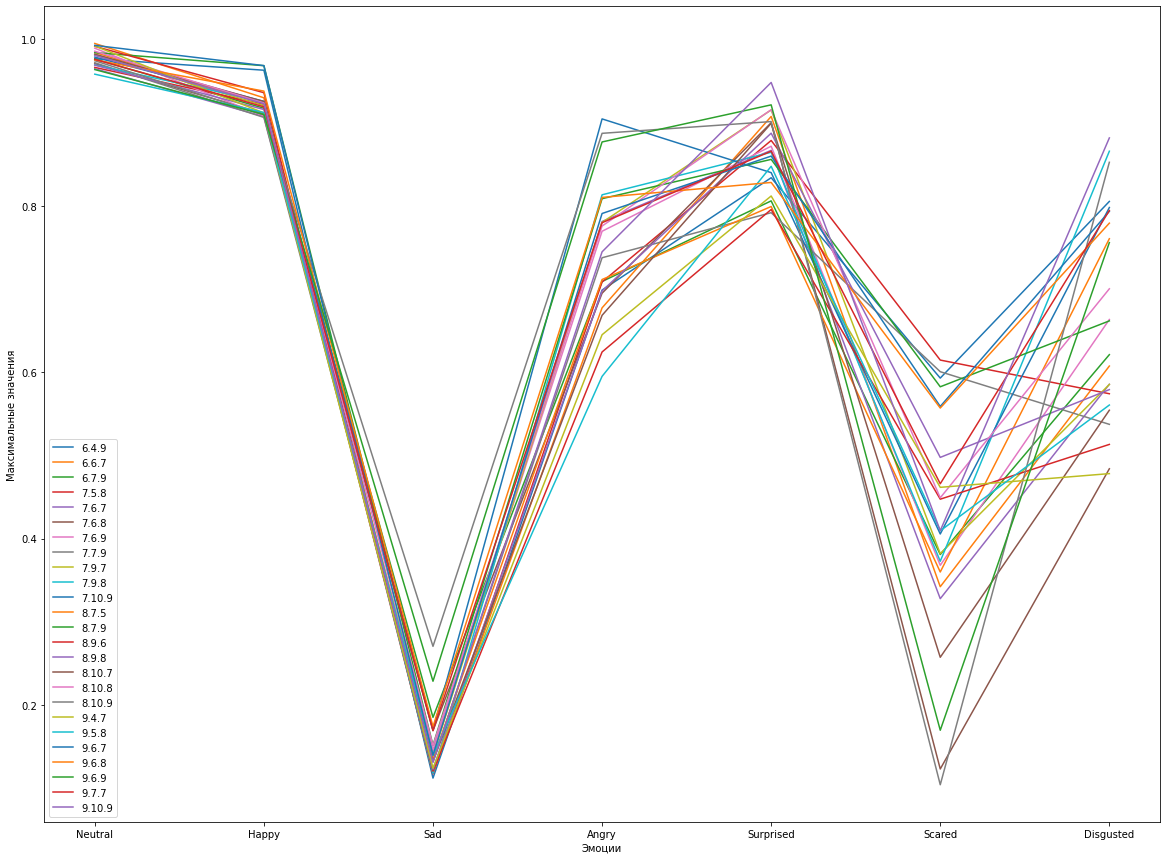

In [873]:
# Старый вариант графика

kwargs = {
    'models': models_5_second_selection, 
    'df_clear': df_clear, 
    'df_metrics': df_clear_metrics_5_second_selection, 
    'df_clear_metrics': df_clear_metrics_5_second_selection,
}

res = plot_emotions(**kwargs)

In [876]:
df_clear.max().values / df_clear.max().values

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

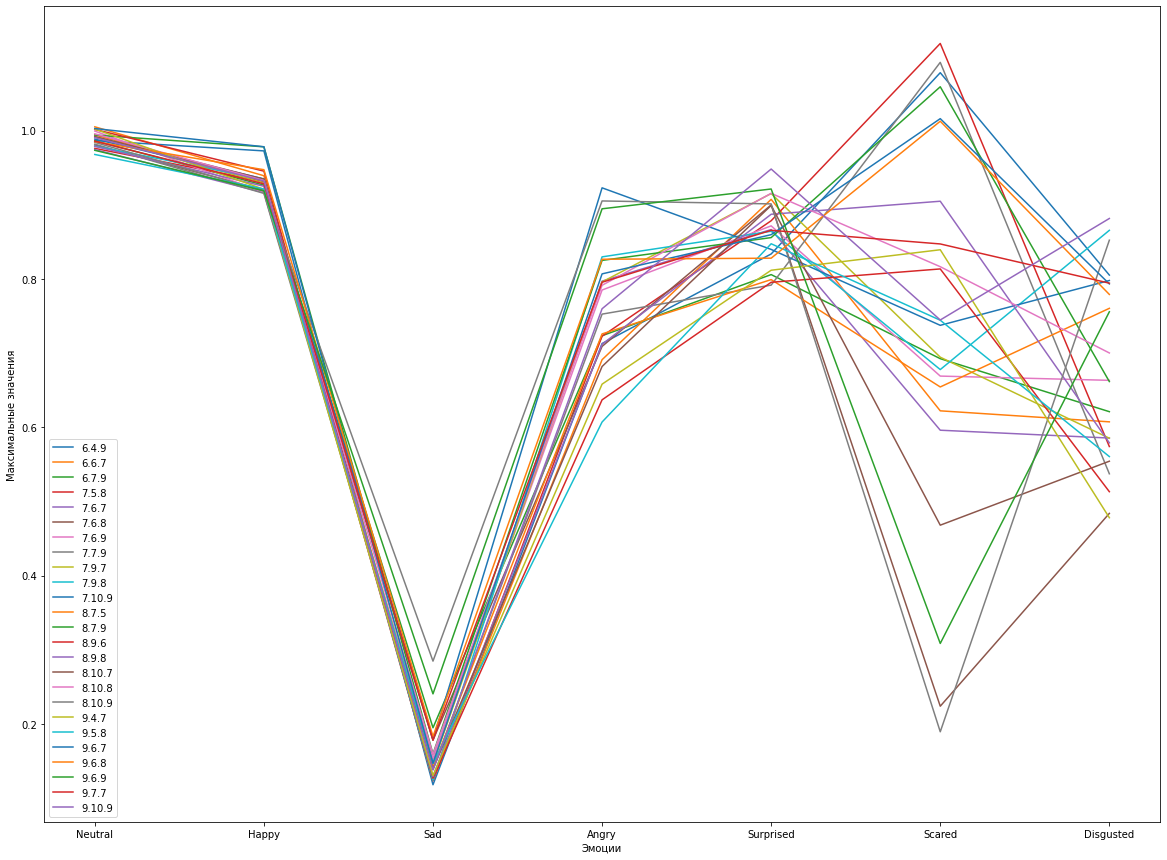

In [872]:
# Новый вариант графика

kwargs = {
    'models': models_5_second_selection, 
    'df_clear': df_clear, 
    'df_metrics': df_clear_metrics_5_second_selection, 
    'df_clear_metrics': df_clear_metrics_5_second_selection,
    'scale': True
}

res = plot_emotions(**kwargs)

In [861]:
df_clear.max()

Neutral      0.99
Happy        0.99
Sad          0.95
Angry        0.98
Surprised    1.00
Scared       0.55
Disgusted    1.00
Valence      0.99
Arousal      0.93
dtype: float64

In [ ]:
df_clear_metrics_5_second_selection

In [810]:
mean_candidate = set(df_clear_metrics_5_second_selection.sort_values('mean')[-13:].index)
mean_candidate

{3, 24, 25, 26, 35, 36, 38, 40, 44, 46, 49, 50, 55}

In [816]:
norm_candidate = set(df_clear_metrics_5_second_selection.sort_values('norm')[-13:].index)
norm_candidate

{3, 24, 25, 26, 28, 35, 36, 38, 40, 46, 49, 50, 55}

In [818]:
only_mean_or_norm = mean_candidate ^ norm_candidate # Симметрическая разность
only_mean_or_norm

{28, 44}

In [820]:
df_clear_metrics_5.iloc[list(only_mean_or_norm)]

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
44  9.4.7  0.991903  0.911526  0.124078  0.644973   0.811685  0.461616   
28  7.7.9  0.971786  0.906099  0.132017  0.737482   0.791620  0.600543   

    Disgusted      mean      norm      stat  
44   0.478098  0.050387  0.139227  0.369624  
28   0.537314  0.049886  0.139715  0.380577

In [822]:
mean_norm_candidate = mean_candidate.intersection(norm_candidate)
len(mean_norm_candidate)

12

In [835]:
df_clear_metrics_5.iloc[list(mean_norm_candidate)].sort_values(['Scared', 'Disgusted'])

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
26   7.6.8  0.970730  0.910606  0.169464  0.694860   0.899672  0.123222   
49   9.6.9  0.963581  0.909555  0.228629  0.876609   0.921181  0.169747   
40  8.10.7  0.982022  0.925121  0.132264  0.668292   0.899037  0.257428   
25   7.6.7  0.964628  0.907122  0.145041  0.781025   0.866505  0.327828   
3    6.6.7  0.994954  0.929664  0.117869  0.677276   0.907227  0.342197   
35   8.7.5  0.984176  0.922825  0.134700  0.711327   0.799054  0.359897   
46   9.5.8  0.958051  0.911926  0.139602  0.594937   0.847371  0.409372   
55  9.10.9  0.980488  0.922544  0.131123  0.744579   0.948096  0.409543   
38   8.9.6  0.991535  0.935798  0.120671  0.624252   0.795454  0.447392   
50   9.7.7  0.975864  0.918847  0.169191  0.779590   0.865507  0.465914   
36   8.7.9  0.983951  0.968261  0.151645  0.808448   0.855677  0.582437   
24   7.5.8  0.966201  0.921879  0.117330  0.708359   0.878390  0.614544   

    Disgusted      mean      norm      stat  
26   0.483926  0.050828  0.140131  0.374835  
49   0.755681  0.050331  0.139999  0.398399  
40   0.554267  0.050531  0.139305  0.381599  
25   0.585477  0.050676  0.141191  0.381497  
3    0.607342  0.050849  0.140907  0.370734  
35   0.760339  0.050604  0.139826  0.377756  
46   0.560517  0.051370  0.142515  0.371640  
55   0.881461  0.050811  0.139837  0.394669  
38   0.513187  0.051521  0.142742  0.364396  
50   0.794257  0.051775  0.143636  0.401213  
36   0.661627  0.050180  0.139627  0.393288  
24   0.574078  0.050452  0.140177  0.383982

In [834]:
df_clear_metrics_5.iloc[list(mean_norm_candidate)].sort_values(['Scared', 'Disgusted']).apply(lambda x: x[['Scared', 'Disgusted']].mean(), axis=1)

26    0.303574
49    0.462714
40    0.405848
25    0.456653
3     0.474769
35    0.560118
46    0.484945
55    0.645502
38    0.480290
50    0.630086
36    0.622032
24    0.594311
dtype: float64

In [799]:
df_clear

Neutral  Happy   Sad  Angry  Surprised  \
Index_                                                                    
00:00:01.300_Смолин Александр_1     0.97   0.00  0.02   0.03       0.01   
00:00:07.575_Керов Андрей_8         0.97   0.01  0.00   0.00       0.04   
00:00:03.000_Боим_9                 0.97   0.01  0.00   0.00       0.04   
00:00:05.700_Provotorov_3           0.97   0.00  0.02   0.03       0.01   
00:00:09.848_Korsakov_9             0.97   0.00  0.00   0.01       0.01   
...                                  ...    ...   ...    ...        ...   
00:00:07.700_Nasyrov_7              0.01   0.00  0.00   0.01       0.00   
00:00:08.200_Nasyrov_7              0.01   0.00  0.00   0.01       0.00   
00:00:07.300_Nasyrov_7              0.01   0.00  0.00   0.00       0.00   
00:00:08.900_Nasyrov_7              0.00   0.00  0.00   0.01       0.00   
00:00:09.100_Nasyrov_7              0.00   0.00  0.00   0.01       0.00   

                                 Scared  Disgusted  Valence  Arousal  
Index_                                                                
00:00:01.300_Смолин Александр_1     0.0       0.01    -0.03     0.23  
00:00:07.575_Керов Андрей_8         0.0       0.00     0.01     0.31  
00:00:03.000_Боим_9                 0.0       0.00     0.01     0.31  
00:00:05.700_Provotorov_3           0.0       0.01    -0.03     0.23  
00:00:09.848_Korsakov_9             0.0       0.01    -0.01     0.30  
...                                 ...        ...      ...      ...  
00:00:07.700_Nasyrov_7              0.0       0.99    -0.99     0.63  
00:00:08.200_Nasyrov_7              0.0       0.99    -0.99     0.63  
00:00:07.300_Nasyrov_7              0.0       0.99    -0.99     0.62  
00:00:08.900_Nasyrov_7              0.0       1.00    -1.00     0.63  
00:00:09.100_Nasyrov_7              0.0       1.00    -1.00     0.63  

[530 rows x 9 columns]

In [946]:
seven_models_ = ['7.9.8', '7.10.9', '8.9.8', '8.10.8', '8.10.9', '9.6.7', '9.6.8']
seven_models = [model_tuple for model_tuple in models_5_second_selection if model_tuple[0] in seven_models_]
seven_models

[('7.9.8',
  '7.9.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa8f5a64dc0>),
 ('7.10.9',
  '7.10.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa8e55990d0>),
 ('8.9.8',
  '8.9.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa881680190>),
 ('8.10.8',
  '8.10.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa865c01b20>),
 ('8.10.9',
  '8.10.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa86d265550>),
 ('9.6.7',
  '9.6.7',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa840819e80>),
 ('9.6.8',
  '9.6.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa849267940>)]

In [947]:
df_seven_models = df_clear_metrics_5_second_selection.query("model in @seven_models_")
df_seven_models

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
30   7.9.8  0.969142  0.925012  0.118063  0.813106   0.864223  0.372780   
33  7.10.9  0.978540  0.925442  0.170040  0.904304   0.839740  0.405584   
39   8.9.8  0.968928  0.915590  0.122892  0.697624   0.887144  0.497585   
41  8.10.8  0.985647  0.923398  0.151236  0.775558   0.915335  0.449049   
42  8.10.9  0.974229  0.909216  0.270570  0.886977   0.901099  0.104270   
47   9.6.7  0.992683  0.968336  0.139871  0.790640   0.859622  0.558804   
48   9.6.8  0.975201  0.937720  0.174152  0.809957   0.827936  0.556891   

    Disgusted      mean      norm      stat  
30   0.865483  0.049126  0.136223  0.396314  
33   0.797849  0.047961  0.133694  0.387689  
39   0.579031  0.049130  0.135990  0.377404  
41   0.700176  0.049758  0.137691  0.388609  
42   0.852168  0.049014  0.136154  0.398614  
47   0.793250  0.048896  0.135041  0.376554  
48   0.779052  0.048610  0.134730  0.397050

In [949]:
other_models = [model_tuple for model_tuple in models_5_second_selection if model_tuple[0] not in seven_models_]
len(other_models)

18

In [951]:
other_models_ = set(df_clear_metrics_5_second_selection.index).difference(set(df_seven_models.index))
len(other_models_)

18

In [954]:
df_other_models = df_clear_metrics_5.iloc[list(other_models_)]
df_other_models

model   Neutral     Happy       Sad     Angry  Surprised    Scared  \
0    6.4.9  0.976621  0.962817  0.112274  0.698618   0.833612  0.592869   
3    6.6.7  0.994954  0.929664  0.117869  0.677276   0.907227  0.342197   
4    6.7.9  0.976276  0.917102  0.185231  0.708941   0.805806  0.380871   
35   8.7.5  0.984176  0.922825  0.134700  0.711327   0.799054  0.359897   
36   8.7.9  0.983951  0.968261  0.151645  0.808448   0.855677  0.582437   
38   8.9.6  0.991535  0.935798  0.120671  0.624252   0.795454  0.447392   
40  8.10.7  0.982022  0.925121  0.132264  0.668292   0.899037  0.257428   
44   9.4.7  0.991903  0.911526  0.124078  0.644973   0.811685  0.461616   
46   9.5.8  0.958051  0.911926  0.139602  0.594937   0.847371  0.409372   
49   9.6.9  0.963581  0.909555  0.228629  0.876609   0.921181  0.169747   
50   9.7.7  0.975864  0.918847  0.169191  0.779590   0.865507  0.465914   
55  9.10.9  0.980488  0.922544  0.131123  0.744579   0.948096  0.409543   
24   7.5.8  0.966201  0.921879  0.117330  0.708359   0.878390  0.614544   
25   7.6.7  0.964628  0.907122  0.145041  0.781025   0.866505  0.327828   
26   7.6.8  0.970730  0.910606  0.169464  0.694860   0.899672  0.123222   
27   7.6.9  0.989266  0.907634  0.145255  0.769295   0.871483  0.367950   
28   7.7.9  0.971786  0.906099  0.132017  0.737482   0.791620  0.600543   
29   7.9.7  0.981848  0.920194  0.138796  0.779979   0.915041  0.381981   

    Disgusted      mean      norm      stat  
0    0.805153  0.049450  0.137629  0.381123  
3    0.607342  0.050849  0.140907  0.370734  
4    0.621036  0.049933  0.138603  0.364481  
35   0.760339  0.050604  0.139826  0.377756  
36   0.661627  0.050180  0.139627  0.393288  
38   0.513187  0.051521  0.142742  0.364396  
40   0.554267  0.050531  0.139305  0.381599  
44   0.478098  0.050387  0.139227  0.369624  
46   0.560517  0.051370  0.142515  0.371640  
49   0.755681  0.050331  0.139999  0.398399  
50   0.794257  0.051775  0.143636  0.401213  
55   0.881461  0.050811  0.139837  0.394669  
24   0.574078  0.050452  0.140177  0.383982  
25   0.585477  0.050676  0.141191  0.381497  
26   0.483926  0.050828  0.140131  0.374835  
27   0.663294  0.049226  0.136545  0.379857  
28   0.537314  0.049886  0.139715  0.380577  
29   0.585248  0.048923  0.134905  0.389270

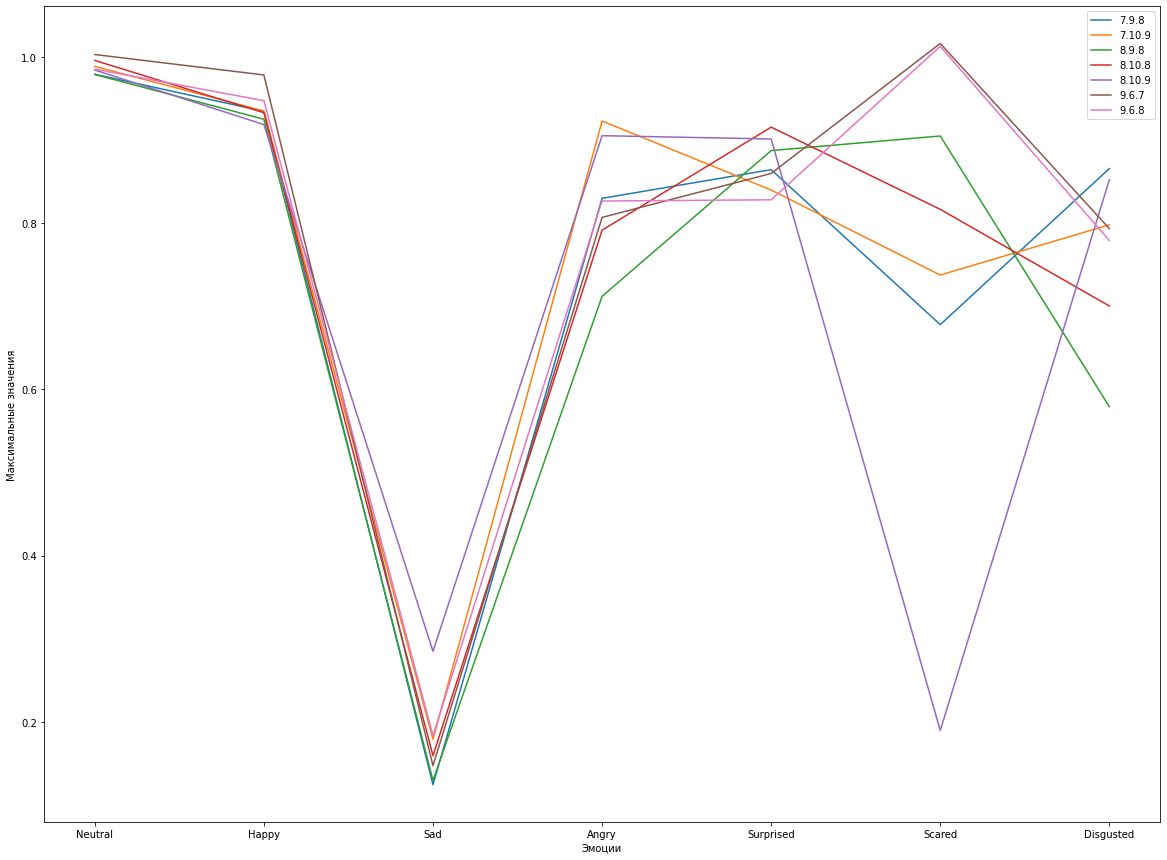

In [890]:
# Давно приметил (7 кандидатов на лучшие)

kwargs = {
    'models': seven_models, 
    'df_clear': df_clear, 
    'df_metrics': df_seven_models, 
    'df_clear_metrics': df_clear_metrics_5_second_selection,
    'scale': True
}

res = plot_emotions(**kwargs)

In [390]:
n = len(df_metrics)

In [874]:
metrics

['mean', 'norm', 'stat']

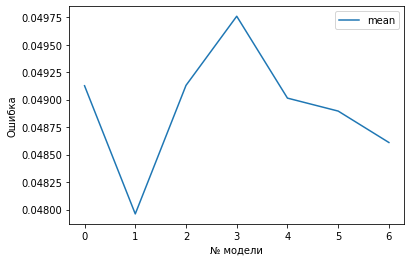

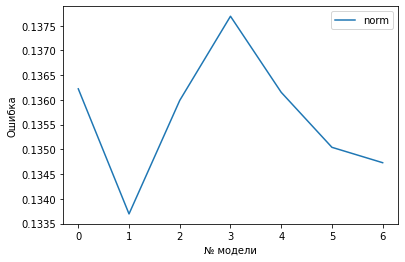

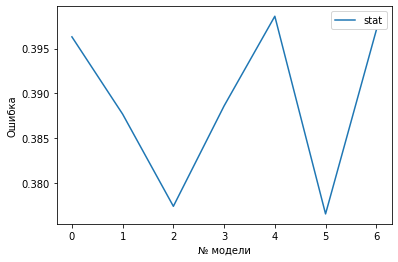

In [887]:
x = []
y = []
for metric in metrics:
    x.append(range(len(df_seven_models)))
    y.append(df_seven_models[metric])
    
for i in range(len(metrics)):
    plt.plot(x[i], y[i], label=metrics[i])
    plt.xlabel("№ модели")
    plt.ylabel("Ошибка")
    plt.legend()
    plt.show()

In [891]:
df_test # Последний тест (v_5). Проверим 7-ку лучших

Neutral  Happy   Sad  Angry  Surprised  \
Index_                                                                       
00:00:00.333_Fomin_2                   0.97   0.00  0.01   0.03       0.00   
00:00:44.000_Aleksashina_1             0.57   0.58  0.00   0.01       0.01   
00:00:05.060_Korsakov_6                0.74   0.00  0.01   0.04       0.08   
00:01:51.000_Бондаренко Денис_2        0.99   0.00  0.01   0.01       0.01   
00:00:10.121_Керов Андрей_9            0.83   0.28  0.00   0.00       0.00   
...                                     ...    ...   ...    ...        ...   
00:00:04.818_Керов Андрей_5            0.57   0.00  0.11   0.00       0.11   
00:00:10.100_Левандовский Кирилл_1     0.78   0.05  0.08   0.16       0.01   
00:00:02.151_Fomin_2                   0.94   0.00  0.02   0.05       0.01   
00:00:02.757_Керов Андрей_5            0.67   0.03  0.06   0.08       0.04   
00:00:06.909_Korsakov_9                0.98   0.00  0.00   0.01       0.01   

                                    Scared  Disgusted  Valence  Arousal  
Index_                                                                   
00:00:00.333_Fomin_2                  0.00       0.00    -0.03     0.25  
00:00:44.000_Aleksashina_1            0.00       0.00     0.57     0.28  
00:00:05.060_Korsakov_6               0.04       0.00    -0.06     0.52  
00:01:51.000_Бондаренко Денис_2       0.00       0.00    -0.01     0.25  
00:00:10.121_Керов Андрей_9           0.00       0.00     0.28     0.41  
...                                    ...        ...      ...      ...  
00:00:04.818_Керов Андрей_5           0.00       0.00    -0.11     0.72  
00:00:10.100_Левандовский Кирилл_1    0.00       0.00    -0.17     0.26  
00:00:02.151_Fomin_2                  0.00       0.01    -0.06     0.29  
00:00:02.757_Керов Андрей_5           0.00       0.04    -0.12     0.50  
00:00:06.909_Korsakov_9               0.00       0.00    -0.01     0.31  

[7536 rows x 9 columns]

In [1000]:
df_test_with_index = df_test
df_test_with_index['Index_'] = df_test_with_index.index
df_test_with_index

Neutral  Happy   Sad  Angry  Surprised  \
Index_                                                                       
00:00:00.333_Fomin_2                   0.97   0.00  0.01   0.03       0.00   
00:00:44.000_Aleksashina_1             0.57   0.58  0.00   0.01       0.01   
00:00:05.060_Korsakov_6                0.74   0.00  0.01   0.04       0.08   
00:01:51.000_Бондаренко Денис_2        0.99   0.00  0.01   0.01       0.01   
00:00:10.121_Керов Андрей_9            0.83   0.28  0.00   0.00       0.00   
...                                     ...    ...   ...    ...        ...   
00:00:04.818_Керов Андрей_5            0.57   0.00  0.11   0.00       0.11   
00:00:10.100_Левандовский Кирилл_1     0.78   0.05  0.08   0.16       0.01   
00:00:02.151_Fomin_2                   0.94   0.00  0.02   0.05       0.01   
00:00:02.757_Керов Андрей_5            0.67   0.03  0.06   0.08       0.04   
00:00:06.909_Korsakov_9                0.98   0.00  0.00   0.01       0.01   

                                    Scared  Disgusted  Valence  Arousal  \
Index_                                                                    
00:00:00.333_Fomin_2                  0.00       0.00    -0.03     0.25   
00:00:44.000_Aleksashina_1            0.00       0.00     0.57     0.28   
00:00:05.060_Korsakov_6               0.04       0.00    -0.06     0.52   
00:01:51.000_Бондаренко Денис_2       0.00       0.00    -0.01     0.25   
00:00:10.121_Керов Андрей_9           0.00       0.00     0.28     0.41   
...                                    ...        ...      ...      ...   
00:00:04.818_Керов Андрей_5           0.00       0.00    -0.11     0.72   
00:00:10.100_Левандовский Кирилл_1    0.00       0.00    -0.17     0.26   
00:00:02.151_Fomin_2                  0.00       0.01    -0.06     0.29   
00:00:02.757_Керов Андрей_5           0.00       0.04    -0.12     0.50   
00:00:06.909_Korsakov_9               0.00       0.00    -0.01     0.31   

                                                                Index_  
Index_                                                                  
00:00:00.333_Fomin_2                              00:00:00.333_Fomin_2  
00:00:44.000_Aleksashina_1                  00:00:44.000_Aleksashina_1  
00:00:05.060_Korsakov_6                        00:00:05.060_Korsakov_6  
00:01:51.000_Бондаренко Денис_2        00:01:51.000_Бондаренко Денис_2  
00:00:10.121_Керов Андрей_9                00:00:10.121_Керов Андрей_9  
...                                                                ...  
00:00:04.818_Керов Андрей_5                00:00:04.818_Керов Андрей_5  
00:00:10.100_Левандовский Кирилл_1  00:00:10.100_Левандовский Кирилл_1  
00:00:02.151_Fomin_2                              00:00:02.151_Fomin_2  
00:00:02.757_Керов Андрей_5                00:00:02.757_Керов Андрей_5  
00:00:06.909_Korsakov_9                        00:00:06.909_Korsakov_9  

[7536 rows x 10 columns]

In [1001]:
df_test_groupby = groupby(df_test_with_index)
df_test_groupby

Neutral  Happy   Sad  Angry  Surprised  \
Index_                                                                    
00:00:00.848_Керов Андрей_5         0.99   0.00  0.00   0.00       0.01   
00:01:38.400_Смолин Александр_1     0.99   0.00  0.00   0.00       0.01   
00:00:02.000_Керов Андрей_5         0.99   0.00  0.00   0.00       0.01   
00:00:01.727_Керов Андрей_2         0.99   0.00  0.00   0.00       0.01   
00:00:02.878_Боим_1                 0.99   0.00  0.01   0.01       0.01   
...                                  ...    ...   ...    ...        ...   
00:00:17.900_Aleksashina_1          0.01   0.98  0.00   0.00       0.00   
00:00:17.700_Aleksashina_1          0.01   0.99  0.00   0.00       0.00   
00:00:16.500_Aleksashina_1          0.01   0.99  0.00   0.00       0.00   
00:00:15.800_Aleksashina_1          0.01   0.98  0.00   0.00       0.00   
00:00:13.300_Aleksashina_1          0.01   0.98  0.00   0.00       0.00   

                                 Scared  Disgusted  Valence  Arousal  
Index_                                                                
00:00:00.848_Керов Андрей_5         0.0        0.0    -0.00     0.25  
00:01:38.400_Смолин Александр_1     0.0        0.0    -0.00     0.25  
00:00:02.000_Керов Андрей_5         0.0        0.0    -0.00     0.25  
00:00:01.727_Керов Андрей_2         0.0        0.0     0.00     0.25  
00:00:02.878_Боим_1                 0.0        0.0    -0.01     0.25  
...                                 ...        ...      ...      ...  
00:00:17.900_Aleksashina_1          0.0        0.0     0.98     0.72  
00:00:17.700_Aleksashina_1          0.0        0.0     0.98     0.73  
00:00:16.500_Aleksashina_1          0.0        0.0     0.98     0.75  
00:00:15.800_Aleksashina_1          0.0        0.0     0.98     0.77  
00:00:13.300_Aleksashina_1          0.0        0.0     0.98     0.80  

[2239 rows x 9 columns]

In [1003]:
a = -40
b = -30
df_test.sort_values('Disgusted')[a:b]

Neutral  Happy   Sad  Angry  Surprised  Scared  \
Index_                                                                        
00:00:03.090_Керов Андрей_7     0.22   0.01  0.02   0.21        0.0     0.0   
00:00:08.727_Керов Андрей_7     0.48   0.01  0.06   0.00        0.0     0.0   
00:00:04.818_Керов Андрей_7     0.41   0.01  0.05   0.07        0.0     0.0   
00:00:04.969_Керов Андрей_7     0.41   0.01  0.05   0.07        0.0     0.0   
00:00:08.606_Керов Андрей_7     0.46   0.01  0.05   0.00        0.0     0.0   
00:00:08.454_Керов Андрей_7     0.46   0.01  0.05   0.00        0.0     0.0   
00:00:08.575_Керов Андрей_7     0.46   0.01  0.05   0.00        0.0     0.0   
00:00:05.060_Керов Андрей_7     0.41   0.01  0.05   0.07        0.0     0.0   
00:00:08.393_Керов Андрей_7     0.46   0.01  0.05   0.00        0.0     0.0   
00:00:04.300_Zaharova_7         0.17   0.01  0.01   0.03        0.0     0.0   

                             Disgusted  Valence  Arousal  \
Index_                                                     
00:00:03.090_Керов Андрей_7       0.64    -0.84     0.31   
00:00:08.727_Керов Андрей_7       0.66    -0.65     0.26   
00:00:04.818_Керов Андрей_7       0.67    -0.73     0.33   
00:00:04.969_Керов Андрей_7       0.67    -0.73     0.33   
00:00:08.606_Керов Андрей_7       0.67    -0.66     0.26   
00:00:08.454_Керов Андрей_7       0.67    -0.66     0.26   
00:00:08.575_Керов Андрей_7       0.67    -0.66     0.26   
00:00:05.060_Керов Андрей_7       0.67    -0.73     0.33   
00:00:08.393_Керов Андрей_7       0.67    -0.66     0.26   
00:00:04.300_Zaharova_7           0.69    -0.68     0.59   

                                                  Index_  
Index_                                                    
00:00:03.090_Керов Андрей_7  00:00:03.090_Керов Андрей_7  
00:00:08.727_Керов Андрей_7  00:00:08.727_Керов Андрей_7  
00:00:04.818_Керов Андрей_7  00:00:04.818_Керов Андрей_7  
00:00:04.969_Керов Андрей_7  00:00:04.969_Керов Андрей_7  
00:00:08.606_Керов Андрей_7  00:00:08.606_Керов Андрей_7  
00:00:08.454_Керов Андрей_7  00:00:08.454_Керов Андрей_7  
00:00:08.575_Керов Андрей_7  00:00:08.575_Керов Андрей_7  
00:00:05.060_Керов Андрей_7  00:00:05.060_Керов Андрей_7  
00:00:08.393_Керов Андрей_7  00:00:08.393_Керов Андрей_7  
00:00:04.300_Zaharova_7          00:00:04.300_Zaharova_7

In [1005]:
a = -30
b = -20
df_test_groupby.sort_values('Disgusted')[a:b]

Neutral  Happy   Sad  Angry  Surprised  Scared  \
Index_                                                                        
00:00:40.400_Aleksashina_1      0.44   0.04  0.05   0.16       0.00    0.00   
00:00:06.600_Nasyrov_4          0.25   0.02  0.00   0.09       0.00    0.01   
00:00:03.400_Nasyrov_4          0.32   0.03  0.00   0.02       0.01    0.00   
00:00:03.090_Керов Андрей_7     0.22   0.01  0.02   0.21       0.00    0.00   
00:00:08.727_Керов Андрей_7     0.48   0.01  0.06   0.00       0.00    0.00   
00:00:04.818_Керов Андрей_7     0.41   0.01  0.05   0.07       0.00    0.00   
00:00:08.606_Керов Андрей_7     0.46   0.01  0.05   0.00       0.00    0.00   
00:00:08.575_Керов Андрей_7     0.46   0.01  0.05   0.00       0.00    0.00   
00:00:04.300_Zaharova_7         0.17   0.01  0.01   0.03       0.00    0.00   
00:00:05.393_Керов Андрей_7     0.47   0.01  0.06   0.00       0.00    0.00   

                             Disgusted  Valence  Arousal  
Index_                                                    
00:00:40.400_Aleksashina_1        0.52    -0.64     0.26  
00:00:06.600_Nasyrov_4            0.60    -0.57     0.57  
00:00:03.400_Nasyrov_4            0.62    -0.59     0.48  
00:00:03.090_Керов Андрей_7       0.64    -0.84     0.31  
00:00:08.727_Керов Андрей_7       0.66    -0.65     0.26  
00:00:04.818_Керов Андрей_7       0.67    -0.73     0.33  
00:00:08.606_Керов Андрей_7       0.67    -0.66     0.26  
00:00:08.575_Керов Андрей_7       0.67    -0.66     0.26  
00:00:04.300_Zaharova_7           0.69    -0.68     0.59  
00:00:05.393_Керов Андрей_7       0.69    -0.68     0.33

In [1014]:
i = 3
seven_models[i][2].model_metric(df_test_groupby.sort_values('Disgusted')[a:b])

0.15588855743408203

In [1015]:
seven_models[i]

('8.10.8',
 '8.10.8',
 <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa865c01b20>)

In [983]:
i = 6
other_models[i][2].predict(df_test.sort_values('Disgusted')[a:b][fields])

Neutral         Happy       Sad     Angry  \
Index_                                                                    
00:00:03.090_Керов Андрей_7  0.262824  5.271140e-30  0.139139  0.211909   
00:00:08.727_Керов Андрей_7  0.451881  2.044933e-25  0.123688  0.273751   
00:00:04.818_Керов Андрей_7  0.331367  1.217805e-27  0.135174  0.269527   
00:00:04.969_Керов Андрей_7  0.331367  1.217805e-27  0.135174  0.269527   
00:00:08.606_Керов Андрей_7  0.444621  1.212623e-25  0.124569  0.270103   
00:00:08.454_Керов Андрей_7  0.444621  1.212623e-25  0.124569  0.270103   
00:00:08.575_Керов Андрей_7  0.444621  1.212623e-25  0.124569  0.270103   
00:00:05.060_Керов Андрей_7  0.331367  1.217805e-27  0.135174  0.269527   
00:00:08.393_Керов Андрей_7  0.444621  1.212623e-25  0.124569  0.270103   
00:00:04.300_Zaharova_7      0.202862  1.366095e-27  0.138765  0.300230   

                                Surprised    Scared  Disgusted  
Index_                                                          
00:00:03.090_Керов Андрей_7  1.605771e-08  0.000124   0.589327  
00:00:08.727_Керов Андрей_7  4.437011e-07  0.000067   0.326821  
00:00:04.818_Керов Андрей_7  8.445151e-08  0.000190   0.460874  
00:00:04.969_Керов Андрей_7  8.445151e-08  0.000190   0.460874  
00:00:08.606_Керов Андрей_7  3.782346e-07  0.000068   0.339396  
00:00:08.454_Керов Андрей_7  3.782346e-07  0.000068   0.339396  
00:00:08.575_Керов Андрей_7  3.782346e-07  0.000068   0.339396  
00:00:05.060_Керов Андрей_7  8.445151e-08  0.000190   0.460874  
00:00:08.393_Керов Андрей_7  3.782346e-07  0.000068   0.339396  
00:00:04.300_Zaharova_7      9.271734e-08  0.008402   0.389684

In [1016]:
# А что все модели скажут?
test_models = []
len(models)

288

In [1017]:
for model_tuple in models:
    test_models.append(model_tuple[2].model_metric(df_test_groupby.sort_values('Disgusted')[a:b]))

In [1018]:
np.min(test_models)

0.14300391333443777

In [1019]:
test_models.index(np.min(test_models))

111

In [1020]:
models[111]

('7.6.9',
 '7.6.9',
 <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa944581d90>)

In [ ]:
models[111]

In [998]:
other_models[i][2].predict(df_test.sort_values('Disgusted')[a:b][fields])

Neutral         Happy       Sad     Angry  \
Index_                                                                    
00:00:03.090_Керов Андрей_7  0.262824  5.271140e-30  0.139139  0.211909   
00:00:08.727_Керов Андрей_7  0.451881  2.044933e-25  0.123688  0.273751   
00:00:04.818_Керов Андрей_7  0.331367  1.217805e-27  0.135174  0.269527   
00:00:04.969_Керов Андрей_7  0.331367  1.217805e-27  0.135174  0.269527   
00:00:08.606_Керов Андрей_7  0.444621  1.212623e-25  0.124569  0.270103   
00:00:08.454_Керов Андрей_7  0.444621  1.212623e-25  0.124569  0.270103   
00:00:08.575_Керов Андрей_7  0.444621  1.212623e-25  0.124569  0.270103   
00:00:05.060_Керов Андрей_7  0.331367  1.217805e-27  0.135174  0.269527   
00:00:08.393_Керов Андрей_7  0.444621  1.212623e-25  0.124569  0.270103   
00:00:04.300_Zaharova_7      0.202862  1.366095e-27  0.138765  0.300230   

                                Surprised    Scared  Disgusted  
Index_                                                          
00:00:03.090_Керов Андрей_7  1.605771e-08  0.000124   0.589327  
00:00:08.727_Керов Андрей_7  4.437011e-07  0.000067   0.326821  
00:00:04.818_Керов Андрей_7  8.445151e-08  0.000190   0.460874  
00:00:04.969_Керов Андрей_7  8.445151e-08  0.000190   0.460874  
00:00:08.606_Керов Андрей_7  3.782346e-07  0.000068   0.339396  
00:00:08.454_Керов Андрей_7  3.782346e-07  0.000068   0.339396  
00:00:08.575_Керов Андрей_7  3.782346e-07  0.000068   0.339396  
00:00:05.060_Керов Андрей_7  8.445151e-08  0.000190   0.460874  
00:00:08.393_Керов Андрей_7  3.782346e-07  0.000068   0.339396  
00:00:04.300_Zaharova_7      9.271734e-08  0.008402   0.389684

In [942]:
len(models_5_second_selection)

25

In [900]:
seven_models

[('7.9.8',
  '7.9.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa8f5a64dc0>),
 ('7.10.9',
  '7.10.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa8e55990d0>),
 ('8.9.8',
  '8.9.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa881680190>),
 ('8.10.8',
  '8.10.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa865c01b20>),
 ('8.10.9',
  '8.10.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa86d265550>),
 ('9.6.7',
  '9.6.7',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa840819e80>),
 ('9.6.8',
  '9.6.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa849267940>)]

In [1242]:
seven_fields

['Neutral', 'Happy', 'Sad', 'Angry', 'Surprised', 'Scared', 'Disgusted']

In [1243]:
test_models_incorrect = [set() for emotion in seven_fields]

In [1244]:
len(models)

288

In [1250]:
emotion = 'Disgusted'
test_ = df_clear.sort_values(emotion)[-12:]
test_

Neutral  Happy  Sad  Angry  Surprised  Scared  \
Index_                                                                          
00:00:05.500_Zaharova_7            0.03   0.01  0.0   0.01        0.0     0.0   
00:00:34.900_Куликов Алексей_1     0.03   0.00  0.0   0.03        0.0     0.0   
00:00:05.200_Zaharova_7            0.02   0.00  0.0   0.00        0.0     0.0   
00:00:05.300_Zaharova_7            0.02   0.00  0.0   0.00        0.0     0.0   
00:00:05.400_Zaharova_7            0.02   0.00  0.0   0.00        0.0     0.0   
00:00:07.000_Nasyrov_7             0.03   0.00  0.0   0.01        0.0     0.0   
00:00:09.300_Nasyrov_7             0.02   0.00  0.0   0.01        0.0     0.0   
00:00:07.700_Nasyrov_7             0.01   0.00  0.0   0.01        0.0     0.0   
00:00:08.200_Nasyrov_7             0.01   0.00  0.0   0.01        0.0     0.0   
00:00:07.300_Nasyrov_7             0.01   0.00  0.0   0.00        0.0     0.0   
00:00:08.900_Nasyrov_7             0.00   0.00  0.0   0.01        0.0     0.0   
00:00:09.100_Nasyrov_7             0.00   0.00  0.0   0.01        0.0     0.0   

                                Disgusted  Valence  Arousal  
Index_                                                       
00:00:05.500_Zaharova_7              0.96    -0.95     0.86  
00:00:34.900_Куликов Алексей_1       0.96    -0.95     0.55  
00:00:05.200_Zaharova_7              0.96    -0.96     0.85  
00:00:05.300_Zaharova_7              0.97    -0.96     0.86  
00:00:05.400_Zaharova_7              0.97    -0.97     0.86  
00:00:07.000_Nasyrov_7               0.97    -0.97     0.62  
00:00:09.300_Nasyrov_7               0.98    -0.98     0.62  
00:00:07.700_Nasyrov_7               0.99    -0.99     0.63  
00:00:08.200_Nasyrov_7               0.99    -0.99     0.63  
00:00:07.300_Nasyrov_7               0.99    -0.99     0.62  
00:00:08.900_Nasyrov_7               1.00    -1.00     0.63  
00:00:09.100_Nasyrov_7               1.00    -1.00     0.63

In [1280]:
df_clear_without_Neutral_Happy = df_clear.sort_values('Neutral')[:-200].sort_values('Happy')[:-200]
df_clear_without_Neutral_Happy

Neutral  Happy   Sad  Angry  Surprised  Scared  \
Index_                                                                          
00:00:09.100_Nasyrov_7            0.00   0.00  0.00   0.01       0.00     0.0   
00:00:07.000_Nasyrov_7            0.03   0.00  0.00   0.01       0.00     0.0   
00:00:10.200_Nasyrov_7            0.06   0.00  0.01   0.02       0.00     0.0   
00:00:40.000_Бушунов Виктор_1     0.07   0.00  0.00   0.97       0.00     0.0   
00:00:09.600_Zaharova_3           0.07   0.00  0.89   0.00       0.00     0.0   
...                                ...    ...   ...    ...        ...     ...   
00:00:07.400_Zaharova_5           0.27   0.02  0.00   0.00       0.90     0.0   
00:00:08.500_Zaharova_5           0.19   0.02  0.00   0.00       0.93     0.0   
00:00:07.300_Zaharova_5           0.25   0.02  0.00   0.00       0.91     0.0   
00:00:08.600_Zaharova_5           0.18   0.08  0.00   0.00       0.92     0.0   
00:00:08.700_Zaharova_5           0.17   0.17  0.00   0.00       0.91     0.0   

                               Disgusted  Valence  Arousal  
Index_                                                      
00:00:09.100_Nasyrov_7              1.00    -1.00     0.63  
00:00:07.000_Nasyrov_7              0.97    -0.97     0.62  
00:00:10.200_Nasyrov_7              0.93    -0.93     0.69  
00:00:40.000_Бушунов Виктор_1       0.00    -0.97     0.76  
00:00:09.600_Zaharova_3             0.13    -0.89     0.65  
...                                  ...      ...      ...  
00:00:07.400_Zaharova_5             0.00     0.01     0.78  
00:00:08.500_Zaharova_5             0.00     0.02     0.73  
00:00:07.300_Zaharova_5             0.00     0.01     0.79  
00:00:08.600_Zaharova_5             0.00     0.07     0.72  
00:00:08.700_Zaharova_5             0.00     0.16     0.72  

[130 rows x 9 columns]

In [1302]:
# test_ = df_clear
test_ = df_clear_without_Neutral_Happy
test_

Neutral  Happy   Sad  Angry  Surprised  Scared  \
Index_                                                                          
00:00:09.100_Nasyrov_7            0.00   0.00  0.00   0.01       0.00     0.0   
00:00:07.000_Nasyrov_7            0.03   0.00  0.00   0.01       0.00     0.0   
00:00:10.200_Nasyrov_7            0.06   0.00  0.01   0.02       0.00     0.0   
00:00:40.000_Бушунов Виктор_1     0.07   0.00  0.00   0.97       0.00     0.0   
00:00:09.600_Zaharova_3           0.07   0.00  0.89   0.00       0.00     0.0   
...                                ...    ...   ...    ...        ...     ...   
00:00:07.400_Zaharova_5           0.27   0.02  0.00   0.00       0.90     0.0   
00:00:08.500_Zaharova_5           0.19   0.02  0.00   0.00       0.93     0.0   
00:00:07.300_Zaharova_5           0.25   0.02  0.00   0.00       0.91     0.0   
00:00:08.600_Zaharova_5           0.18   0.08  0.00   0.00       0.92     0.0   
00:00:08.700_Zaharova_5           0.17   0.17  0.00   0.00       0.91     0.0   

                               Disgusted  Valence  Arousal  
Index_                                                      
00:00:09.100_Nasyrov_7              1.00    -1.00     0.63  
00:00:07.000_Nasyrov_7              0.97    -0.97     0.62  
00:00:10.200_Nasyrov_7              0.93    -0.93     0.69  
00:00:40.000_Бушунов Виктор_1       0.00    -0.97     0.76  
00:00:09.600_Zaharova_3             0.13    -0.89     0.65  
...                                  ...      ...      ...  
00:00:07.400_Zaharova_5             0.00     0.01     0.78  
00:00:08.500_Zaharova_5             0.00     0.02     0.73  
00:00:07.300_Zaharova_5             0.00     0.01     0.79  
00:00:08.600_Zaharova_5             0.00     0.07     0.72  
00:00:08.700_Zaharova_5             0.00     0.16     0.72  

[130 rows x 9 columns]

In [1265]:
# test_models = []
# for model_tuple in models:
#     test_models.append(model_tuple[2].predict(test_)[emotion].mean() / test_[emotion].mean())

In [1296]:
test_models = []
for model_tuple in models:
    test_models.append(model_tuple[2].model_metric(test_, 'stat'))

In [1297]:
# np.max(test_models)
np.min(test_models)

0.2775039

In [1298]:
test_models

[0.3408897,
 0.3048168,
 0.33987358,
 0.3015474,
 0.301802,
 0.30451092,
 0.34073636,
 0.33497033,
 0.31295323,
 0.31123087,
 0.30362058,
 0.29815447,
 0.30712226,
 0.28150305,
 0.30726123,
 0.28376755,
 0.32976657,
 0.29417318,
 0.3058676,
 0.30318323,
 0.30395368,
 0.30191144,
 0.28759637,
 0.29594868,
 0.30309224,
 0.30586386,
 0.302141,
 0.30234233,
 0.30152723,
 0.30136076,
 0.2891417,
 0.29062113,
 0.2956047,
 0.3067416,
 0.30302212,
 0.28912756,
 0.29197103,
 0.29552633,
 0.28439507,
 0.29234603,
 0.3075357,
 0.2959415,
 0.29600617,
 0.2952607,
 0.28804868,
 0.3110512,
 0.28661162,
 0.2924765,
 0.30503818,
 0.29905668,
 0.2927727,
 0.2989651,
 0.30287346,
 0.28851843,
 0.29554135,
 0.29078114,
 0.3385583,
 0.31215444,
 0.28705007,
 0.28611726,
 0.30021185,
 0.30254126,
 0.29117388,
 0.3194664,
 0.30706003,
 0.30430394,
 0.30320483,
 0.30676675,
 0.28909948,
 0.30306485,
 0.28827435,
 0.2964651,
 0.34057555,
 0.29672197,
 0.34068114,
 0.300726,
 0.29154187,
 0.2923362,
 0.3397842

In [1299]:
# i = test_models.index(np.max(test_models))
i = test_models.index(np.min(test_models))
i

154

In [1300]:
models[i]

('8.3.4',
 '8.3.4',
 <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa8e53ee430>)

In [1301]:
models[i][2].predict(test_[fields])

Neutral         Happy       Sad     Angry  \
Index_                                                                      
00:00:09.100_Nasyrov_7         0.085479  2.407895e-16  0.080512  0.572757   
00:00:07.000_Nasyrov_7         0.092871  6.388742e-16  0.085551  0.567296   
00:00:10.200_Nasyrov_7         0.097935  2.292273e-15  0.087703  0.548239   
00:00:40.000_Бушунов Виктор_1  0.084368  6.141885e-16  0.077857  0.547587   
00:00:09.600_Zaharova_3        0.111164  8.483301e-15  0.096723  0.544648   
...                                 ...           ...       ...       ...   
00:00:07.400_Zaharova_5        0.315848  3.424892e-02  0.022798  0.037380   
00:00:08.500_Zaharova_5        0.345880  4.596838e-02  0.015605  0.028682   
00:00:07.300_Zaharova_5        0.310317  3.333664e-02  0.023584  0.038126   
00:00:08.600_Zaharova_5        0.359892  1.023996e-01  0.005256  0.012148   
00:00:08.700_Zaharova_5        0.340694  2.308444e-01  0.000842  0.002835   

                               Surprised    Scared  Disgusted  
Index_                                                         
00:00:09.100_Nasyrov_7          0.003871  0.005931   0.401367  
00:00:07.000_Nasyrov_7          0.004580  0.006712   0.399472  
00:00:10.200_Nasyrov_7          0.006002  0.007545   0.387110  
00:00:40.000_Бушунов Виктор_1   0.004951  0.006192   0.382954  
00:00:09.600_Zaharova_3         0.007396  0.009034   0.387748  
...                                  ...       ...        ...  
00:00:07.400_Zaharova_5         0.556111  0.012572   0.014957  
00:00:08.500_Zaharova_5         0.507257  0.009641   0.010071  
00:00:07.300_Zaharova_5         0.562928  0.012757   0.015428  
00:00:08.600_Zaharova_5         0.428250  0.003618   0.002918  
00:00:08.700_Zaharova_5         0.317642  0.000633   0.000370  

[130 rows x 7 columns]

In [1255]:
models[i][2].predict(test_[fields])[emotion].mean() / test_[emotion].mean()

0.6239511491492822

In [1256]:
df_clear_metrics[df_clear_metrics.model == models[i][0]]

model   Neutral     Happy       Sad    Angry  Surprised    Scared  \
17  9.10.9  0.980976  0.933078  0.155704  0.69176   0.891243  0.051588   

    Disgusted      mean      norm      stat  
17   0.628569  0.052117  0.142763  0.368249

In [1257]:
seven_models

[('7.9.8',
  '7.9.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa8f5a64dc0>),
 ('7.10.9',
  '7.10.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa8e55990d0>),
 ('8.9.8',
  '8.9.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa881680190>),
 ('8.10.8',
  '8.10.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa865c01b20>),
 ('8.10.9',
  '8.10.9',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa86d265550>),
 ('9.6.7',
  '9.6.7',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa840819e80>),
 ('9.6.8',
  '9.6.8',
  <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa849267940>)]

In [1306]:
i = 0
seven_models[i][2].statistics(test_, with_mean=True)

min_Neutral  max_Neutral  mean_abs_Neutral  min_Happy  max_Happy  \
0    -0.044413      0.48861          0.072443  -0.015746   0.058533   

   mean_abs_Happy   min_Sad   max_Sad  mean_abs_Sad  min_Angry  ...  \
0        0.002747 -0.856994  0.118063      0.144042  -0.252655  ...   

   mean_abs_Angry  min_Surprised  max_Surprised  mean_abs_Surprised  \
0        0.193568      -0.908585       0.005935            0.051554   

   min_Scared  max_Scared  mean_abs_Scared  min_Disgusted  max_Disgusted  \
0   -0.440537    0.020113         0.026978       -0.75787       0.762886   

   mean_abs_Disgusted  
0            0.218474  

[1 rows x 21 columns]

In [1258]:
# test_seven_models = []
# for model_tuple in seven_models:
#     test_seven_models.append(model_tuple[2].predict(test_)[emotion].mean() / test_[emotion].mean())

In [1282]:
test_seven_models = []
for model_tuple in seven_models:
    test_seven_models.append(model_tuple[2].model_metric(test_))

In [1283]:
test_seven_models

[0.15771326756739354,
 0.16697236784211883,
 0.185517329960079,
 0.1788528610061813,
 0.16603782569969094,
 0.18669161953768887,
 0.17698307246952266]

In [1284]:
seven_models[4]

('8.10.9',
 '8.10.9',
 <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa86d265550>)

In [1285]:
seven_models[6][2].predict(test_[fields])[emotion].mean() / test_[emotion].mean()

1.2456389646370003

In [1286]:
# test_other_models = []
# for model_tuple in other_models:
#     test_other_models.append(model_tuple[2].predict(test_)[emotion].mean() / test_[emotion].mean())

In [1287]:
test_other_models = []
for model_tuple in other_models:
    test_other_models.append(model_tuple[2].model_metric(test_))

In [1288]:
test_other_models

[0.1945047567178915,
 0.20524080716646634,
 0.18975591973944025,
 0.20143942361349587,
 0.188379392519102,
 0.20422931713062328,
 0.18603240631438875,
 0.20090430961860406,
 0.18277430272364353,
 0.19164582975618133,
 0.18100381369119162,
 0.20942092727828812,
 0.19766719943874486,
 0.21339040902944711,
 0.20989195435911745,
 0.17013150728665866,
 0.17401017409104566,
 0.16655602088341345]

In [1249]:
other_models[-2]

('9.7.7',
 '9.7.7',
 <NeuralNetwork.neural_network.NeuralNetwork at 0x7fa8406ebdc0>)